# Introduction

This project aims to determine the most mentioned players in articles from the `nba.com` website for the period from 12.10.2020 to 07.03.2024. For this purpose, I extracted the **id**, **title**, **excerpt** and **date** of the last 10000 articles from the website. Further using `nltk` I will determine the most mentioned players in fragments of these articles: 
1. I break the excerpt into words and clean it from such words as *in*, *is*, and *an*.
2. Using `StanfordPOSTagger`, I extract words with the tag **PERSON** from the fragment and add them to the person list.
3. I process the list as follows: replace **Nikola** with **Nikola Jokic** and **Victor** with **Victor Wembanyama** (these are the most obvious cases where `StanfordPOSTagger` made a mistake and didn't fully recognize the person, because sometimes it didn't see the last name, and sometimes it designated the first name and last name as two different people, I still take into account adding the same player twice in the previous step), and further search on `basketball-reference.com` for the player who was determined by `StanfordPOSTagger` (to unify and check if it determined everything correctly, and also with such an action instead of adding **Bryant** to the final list after the search it will add **Kobe Bryant**, so on the one hand it could have been not Kobe but Thomas Bryant, but I think that the probability of Kobe's appearance in the article is much higher), moreover I withdraw the names of the teams from the list (I also pulled this list from `basketball-reference.com`).
4. Finally, I remove such players as **]** , **Kia Nurse**, **Dan Issel**, **Jeff Halliburton**, **Rudy LaRusso**, **John Brisker** and **Lenny Wilkens**) because they are wrongly added players, for example **Kia Nurse** - a very cool canadian basketball player, but unfortunately she ended up here because the car manufacturer **KIA** is the sponsor of the MVP award, and `StanfordPOSTagger` determined **KIA** as a person, and then a search on `basketball-reference.com` recognized this person as **Kia Nurse**.
5. Well, and in the retest we determine the frequency distribution for 100 with a chart for 20.

# Data Scrpaing

We import the necessary libraries.

In [1]:
import requests
import bs4
from time import sleep
import pandas as pd
import json
from pandas.errors import SettingWithCopyWarning
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from os.path import expanduser
from nltk.tag.stanford import StanfordPOSTagger
import os
from time import sleep

We define the functions that we will use later.

In [2]:
def parseArticlesDataFromPage(i):
    headers = {
        'authority': 'content-api-prod.nba.com',
        'accept': '*/*',
        'accept-language': 'en-US,en;q=0.9',
        'origin': 'https://www.nba.com',
        'referer': 'https://www.nba.com/',
        'sec-ch-ua': '"Not A(Brand";v="99", "Google Chrome";v="121", "Chromium";v="121"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-site',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36',
    }

    params = {
        'page': i,
        'count': '100',
        'types': 'post',
        'region': 'international',
    }

    response = requests.get('https://content-api-prod.nba.com/public/1/leagues/nba/content', params=params, headers=headers)
    return response.content


def handleColumnsMissing(e, df):
    wrong_columns_amount = str(e).count(',') + 1
    wrong_columns_list = []
    for j in range(1, wrong_columns_amount + 1):
        wrong_column = str(e).split("'")[2*j-1]
        wrong_columns_list.append(wrong_column)
    df = df[[el for el in default_columns if el not in wrong_columns_list]]
    for wrong_column in wrong_columns_list:
        df[wrong_column] = ''
    return df


def searchPlayer(query):
    headers = {
        'Referer': 'https://www.basketball-reference.com/players/',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36',
        'sec-ch-ua': '"Not A(Brand";v="99", "Google Chrome";v="121", "Chromium";v="121"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
    }

    params = {
        'hint': '',
        'search': query,
        'pid': '',
        'idx': '',
    }

    response = requests.get('https://www.basketball-reference.com/search/search.fcgi', params=params, headers=headers)
    players = bs4.BeautifulSoup(response.text, 'html.parser')
    try:
        player = players.find_all('div', class_='search-item')[0]
        pl = str(player.find_all('a')).split('>')[1].split('<')[0].split('(')[0].rstrip()
    except IndexError:
        player = players.find_all('h1')
        pl = str(player).split('>')[2].split('<')[0].rstrip()
    return pl


def getTeamsList():
    response = requests.get('https://www.basketball-reference.com/teams/')
    teams_page = bs4.BeautifulSoup(response.text, 'html.parser')
    teams_table = teams_page.find_all('tbody')[0]
    teams = teams_table.find_all('tr', class_='full_table')

    return [str(team.find_all('a')).split('>')[1].split('<')[0] for team in teams]


def processPersons(persons):
    teams_list = getTeamsList()
    processed_persons = []
    for person in persons:
        print(person)
        person_list = person.split()
        person_list = ['Nikola Jokic' if p == 'Nikola' else p for p in person_list]
        person_list = ['Victor Wembanyama' if p == 'Victor' else p for p in person_list]
        person_list = [p for p in person_list if not any(p in element for element in teams_list)]
        if len(person_list) == 1:
            print(person_list[0])
            processed_persons.append(searchPlayer(person_list[0]))
        else:
            not_unique_persons = [searchPlayer(cor_p) for cor_p in person_list]
            for unique_persons in list(set(not_unique_persons)):
                print(unique_persons)
                processed_persons.append(unique_persons)
        print('-------------------------------------------------------------------')
        sleep(5)
    return processed_persons

Extracting the ids, titles, excerpts and dates of the last 10000 articles from the `nba.com` website.

In [3]:
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


full_df = pd.DataFrame()
for i in range(1, 101):
    articles_data = parseArticlesDataFromPage(i)
    data_str_decoded = articles_data.decode('utf-8')
    data_json = json.loads(data_str_decoded)
    items = data_json['results']['items']
    df = pd.json_normalize(items)
    default_columns = ['id', 'title', 'excerpt', 'date']
    try:
        df = df[default_columns]
    except KeyError as e:
        df = handleColumnsMissing(e, df)
    full_df = pd.concat([full_df, df])
    sleep(3)
full_df.to_csv('nba_articles.csv', index=False)

In [4]:
full_df

,id,title,excerpt,date
0,1297409,"Starting 5, March 7: Wednesday was night of bi...",Last night saw four teams rally from 15+ point...,2024-03-07T14:43:30Z
1,1309690,Thunder's Bismack Biyombo appears to collapse ...,"Biyombo, who fell as the team went to the side...",2024-03-07T04:57:55Z
2,1309380,Cavaliers' Evan Mobley to miss at least 1 week...,The 6-foot-11 center suffered the ankle injury...,2024-03-07T01:08:48Z
3,1309277,NBA Fantasy: Yahoo DFS for Mar. 6,RotoWire breaks down the top Yahoo daily fanta...,2024-03-06T21:08:59Z
4,1309272,"Hornets introduce Jeff Peterson, new executive...",The 35-year-old replaces longtime executive Mi...,2024-03-06T18:48:58Z
...,...,...,...,...
95,196214,Bubble Wrap: Who became a legit star in the bu...,Our scribes chime in on which player took a le...,2020-10-13T14:50:06Z
96,196207,Bubble Wrap: Who was the MVP inside the bubble?,Our scribes chime in on which player stood out...,2020-10-13T14:49:34Z
97,196212,Bubble Wrap: Will Miami's path to The Finals i...,Our scribes assess the Heat's chances of winni...,2020-10-13T14:49:01Z
98,196205,Bubble Wrap: Will the Lakers' path to The Fina...,Our scribes assess L.A.'s chances of winning b...,2020-10-13T14:48:39Z


# NLP

I'll be using `StanfordPOSTagger` instead of standard, because it's better recognize persons.

In [6]:
java_path = r"C:\Program Files\Java\jre-1.8\bin\java.exe"
os.environ['JAVAHOME'] = java_path

nltk.download('punkt')
nltk.download('stopwords')
nltk.download("maxent_ne_chunker")
nltk.download("words")
nltk.download("averaged_perceptron_tagger")
nltk.download('wordnet')

home = expanduser("~")
_path_to_model = home + '/stanford-postagger/models/english-bidirectional-distsim.tagger'
_path_to_jar = home + '/stanford-postagger/stanford-postagger.jar'
st = StanfordPOSTagger(model_filename=_path_to_model, path_to_jar=_path_to_jar)
stop_words = set(stopwords.words("english"))

persons_list = []
full_quote = ''
for quote in full_df['excerpt'].to_list():
    print(quote)
    full_quote += ' ' + quote
    words_in_quote = word_tokenize(quote)
    words_in_quote = [word for word in words_in_quote if word.casefold() not in stop_words]
    pos_tags_in_quote = st.tag(words_in_quote)
    quote_tree = nltk.ne_chunk(pos_tags_in_quote)
    persons = list(" ".join(i[0] for i in t) for t in quote_tree if hasattr(t, "label") and t.label() == "PERSON")
    print(persons)
    if len(persons) > 1:
        for person in persons:
            persons_list.append(person if person != list() else '')
    else:
        persons_list.append(persons[0] if persons != list() else '')

processed_persons_list = processPersons(persons_list)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bogdan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bogdan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\bogdan\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bogdan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bogdan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bogdan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is alrea

Last night saw four teams rally from 15+ points down to win, while the Warriors gave the Bucks their first loss since All-Star.
['Warriors', 'Bucks']
Biyombo, who fell as the team went to the sideline in a timeout, was helped off and headed for the locker room.
[]
The 6-foot-11 center suffered the ankle injury during the 3rd quarter of Tuesday's game against the Celtics.
[]
RotoWire breaks down the top Yahoo daily fantasy players at each position for Wednesday's 8-game NBA slate.
[]
The 35-year-old replaces longtime executive Mitch Kupchak, who stepped down to take an advisory role.
['Mitch Kupchak']
The former standout guard for the Boston Celtics was last in the NBA during the 2021-22 season.
[]
Victor Wembanyama continued his assault on the NBA and was named NBA Rookie of the Month for February.
['Victor']
B/R's Jonathan Wasserman has a full 2-round Mock Draft as the college postseason gets underway
['Jonathan Wasserman']
Cleveland became the first team to beat Boston in over a mont

['Heat']
Thrust into a bigger role every season amid roster changes, Maxey continues to exceed expectations in Philadelphia.
['Maxey']
RotoWire breaks down the best players to start at each position heading into Week 19 of the fantasy basketball season.
[]
Boston maintains its lead at No. 1 while Oklahoma City, Denver and Milwaukee are among the teams climbing this week.
['Denver Milwaukee']
Nikola Jokic makes some more history, Victor Wembanyama delivers a monster highlight and more from Sunday's slate.
['Nikola', 'Victor Wembanyama']
The Clippers' new uniforms, logo and court will pay homage to the team's history as it prepares to open the Intuit Dome in 2024-25.
['Clippers']
Miami's Thomas Bryant and New Orleans' Jose Alvarado receive multi-game suspensions for leaving the bench during the altercation and fighting.
['Thomas Bryant New Orleans', 'Jose Alvarado']
Atlanta's All-Star point guard will have surgery after suffering a tear of the radial collateral ligament (RCL) in the fift

[]
RotoWire breaks down the top players to consider on the waiver wire heading into Week 18 of the 2023-24 NBA season.
[]
Our writers predict whether the East or West will win the All-Star Game and who will earn MVP honors (8 ET, TNT).
[]
Our writers make their picks for each of the competitions during State Farm All-Star Saturday Night.
['Farm']
Our writers reveal their winning picks for the 2024 Panini Rising Stars.
['Panini Rising Stars']
All-Star Weekend 2024 is upon us - get ready for all the action with the Starting 5!
[]
An abundance of top candidates, including Luka Doncic and Shai Gilgeous-Alexander, will vie over the closing weeks. 
['Luka Doncic Shai']
An 8-time All-Star, Dave DeBusschere was a defensive stopper and the heart soul of the Knicks teams that won 2 NBA titles in the early 1970s.
['Dave']
From the NBA court to the pilot's seat, Coach Rick Carlisle reaches new heights.
['Coach Rick Carlisle']
Thompson thrives as a backup after making 727 consecutive regular-season

[]
Who will win Super Bowl LVIII? Kansas City Chiefs or San Francisco 49ers? NBA.com spoke with 8 players about their picks.
['Super Bowl', 'Kansas City Chiefs San Francisco']
Joel Embiid's injury has opened the door for a new face to join a Top 5 chase that is suddenly more fluid.
['Joel', 'Embiid']
Thursday included a trade deadline, Kobe's statue unveiling, All-Star Saturday participants announced, Steph's 11 3s and more. 
['Kobe', 'Steph']
The camp will bring together 40 top high school-aged prospects from 22 countries and territories.
[]
Highsmith, who was not injured, was going home after Miami's game against Orlando on Tuesday night when the accident happened.
['Miami', 'Orlando']
Take a closer look at all the action with every update from a busy NBA trade deadline.
[]
Gordon Hayward, an All-Star in 2016-17 with the Jazz, is headed back to the West to play for the Thunder.
['Gordon Hayward', 'Thunder']
The veteran big man is headed to Sacramento, where he is expected to be waive

['Cureton']
The French superstar adds to his growing list of accolades with Rookie of the Month honors & a Rising Stars roster spot. 
['Rookie Month']
The Milwaukee staff gets the All-Star nod because Joe Mazzulla of East-leading Boston is ineligible after coaching in the game last year.
['Joe Mazzulla']
The 2-time All-Star is expected to have surgery on his right foot next week, and he will be out 4-6 months.
[]
With this milestone, Westbrook joins LeBron James as the only other player to amass 25,000 points, 9,000 assists and 8,000 rebounds.
[]
The league will partner with Special Olympics of Indiana and Boys & Girls Clubs of Indianapolis as part of the 2024 NBA All-Star Game.
['Girls Clubs Indianapolis']
RotoWire breaks down the top players to consider on the waiver wire heading into Week 16 of the 2023-24 NBA season.
[]
Virginia Union and Winston-Salem State will each receive $100,000 as HBCU Classic's partnership with AT&T enters 3rd consecutive year.
[]
Nikola Jokic and Shai Gilg

['Cavs']
RotoWire breaks down the top 6 players to consider on the waiver wire heading into Week 15 of the 2023-24 NBA season.
[]
The Bucks star is being recognized for his local efforts during the NBA's Season of Giving.
[]
Lebron earns 20th straight All-Star start, while a trio earns their first All-Star starts in a jam-packed Thursday night
[]
Jayson Tatum climbs, Joel Embiid dominates and Giannis Antetokounmpo earns All-Star captain honors.
['Jayson', 'Tatum', 'Joel Embiid', 'Giannis Antetokounmpo']
LeBron James surpasses Kareem Abdul-Jabbar again, this time for most All-Star selections in NBA history.
['James', 'Kareem Abdul-Jabbar']
NBA Launchpad is a league initiative to source, evaluate and pilot emerging technologies that advance its top basketball and business priorities.
[]
FantasyPros breaks down the top DraftKings and FanDuel daily fantasy players for the Thursday's 7-game slate.
[]
In the 2nd Victor Wembanyama vs. Chet Holmgren showdown, the Spurs rookie proved why he is 

['Alex']
Golden State's game in Utah on Jan. 17 has been postponed after the sudden death of assistant coach Dejan Milojević.
['Golden', 'Utah', 'Dejan Milojević']
Breaking down the effectiveness of the players who turn it on in the clutch at the season's midpoint.
[]
Victor Wembanyama still reigns, but next week's showdown vs. Chet Holmgren could spark a change in our rookie rankings.
['Victor', 'Chet Holmgren']
The Pacers acquire All-Star Pascal Siakam from the Raptors in a trade that also involves the Pelicans.
[]
The Mavs-Lakers matchup will be the 3rd of 5 straight NBA Wednesdays on ABC primetime during January.
[]
Embiid wins MVP duel with Jokic, Suns close on a 32-8 run to shock Kings, and Paul George drops season-high 38 points vs. OKC. 
['Jokic', 'Paul George']
The Minnesota guard talks about the importance of family, the root of his competitiveness and describes his playing style
[]
Denver's plane was delayed after the engines were frozen by cold weather. 
[]
The All-Star gua

['Block Panther', 'Rock']
The Pacers lost Tyrese Haliburton, but still knocked off the NBA-leading Celtics. Plus, a photo history of the NBA in Paris. 
['Tyrese Haliburton', 'Celtics', 'Plus']
The Kings received the NBA Team of the Year Award for their achievements across team business operations.
[]
The two-time All-Star was averaging 25.1 points per game this season since returning from a league-mandated suspension.
[]
The Knicks guard and Rockets center take home the honors for Week 11.
[]
O NBA CrunchTime apresenta todos os destaques dos melhores jogos da liga em um só programa. 
[]
RotoWire breaks down the best players to start at each position heading into Week 12 of the fantasy basketball season.
[]
FantasyPros breaks down the top DraftKings and FanDuel daily fantasy players for the NBA's 6-game slate on Monday.
[]
Oklahoma City moves past Boston for the top spot as the West continues to hold an edge over the East this season.
[]
The NBA App original series, which premieres on J

['Heat', 'Jamie Jaquez Jr.']
The NBA on Wednesday approved Mark Cuban’s sale of a controlling interest in the Mavericks to the Adelson and Dumont families
['Mark Cuban', 'Mavericks Adelson Dumont']
The former Democratic U.S. senator from Wisconsin bought the Bucks in 1985 and owned them until 2014.
['Wisconsin']
RotoWire breaks down the top Yahoo daily fantasy players at each position for Wednesday's 6-game NBA slate.
[]
Denver's high-flying big man is out indefinitely after suffering his injuries on Christmas Day.
['Christmas']
The Grizzlies keep rolling with Ja Morant in the mix and a big anniversary is here for Luka Doncic
['Ja Morant', 'Luka Doncic']
Oklahoma City's star big man and Miami's standout wing continue to shine in the latest rookie rankings.
['Miami']
The NBA Board of Governors has approved the sale from Mark Cuban to the Adelson and Dumont families. 
['Board Governors', 'Mark Cuban Adelson Dumont']
Detroit's 27th consecutive defeat sets a new NBA single-season mark.
[]


['James Naismith']
Embiid drops a season-high 51 points against Minnesota, the Clippers stays undefeated in December and the Celtics roll.
['Minnesota', 'Clippers']
The offseason blockbuster trade of Paul George for Shai Gilgeous-Alexander in 2019 is still being felt by both teams.
['Paul George Shai']
Check out the all-time leaders for points and single-game scoring on Christmas Day.
['Christmas']
Take a look back at the results from every Christmas Day game in NBA history, starting with those played in the 1946-47 season.
[]
Joel Embiid's run is NBA's longest such streak since Kareem Abdul-Jabbar did it in 16 straight games during the 1971-72 season.
['Joel', 'Embiid', 'Kareem']
The arena is home to more than just Magic basketball. Last year it drew 1.3 million guests to 233 events.
['Magic']
The Nets say Simmons has shown consistent strength improvement in his back over the past 2 weeks.
['Simmons']
RotoWire breaks down the top Yahoo daily fantasy players at each position for Wednes

[]
Doncic became the youngest player to reach 1,000 3-pointers in NBA history. Also, Bradley Beal is expected to return on Tuesday.
['Doncic', 'Bradley Beal']
From the rise of the Magic to the surge of LeBron James, these things stand out at the season's quarter mark.
['Magic']
The NBA's Christmas Day brand campaign 'The Gift of Game' celebrates the timeless tradition and captures the magic of holiday hoops.
['Christmas']
RotoWire discusses the best players to start at each position heading into Week 8 of the fantasy basketball season.
[]
The NBA's leading offensive rebounder will be evaluated to return in 8-10 weeks.
[]
FantasyPros breaks down the top DraftKings and FanDuel daily fantasy players for the NBA's 13-game slate on Monday. 
[]
The inaugural All-Tournament Team, selected by a panel of media members, is based off performances throughout the Tournament. 
[]
Minnesota stays hot to rise to the top while the Lakers and Pacers climb into the Top 10.
[]
Before a 13-game night, catc

['Giannis', 'Kia MVP']
Kevin Durant is 17 points away from passing Moses Malone to reach the Top 10 in scoring. He could get there tonight.
['Kevin', 'Moses Malone']
Group Play games in the In-Season Tournament across ESPN and TNT averaged 1.5 million viewers.
['Group']
FantasyPros breaks down the top DraftKings and FanDuel daily fantasy players for Thursday's nine-game NBA slate.
[]
Breaking down the players who have seen a rise or fall in shooting accuracy to begin this season.
[]
The OKC big man went from a season-ending injury to a starring role. Here's how the time off shaped him.
[]
Checking in on the state of the Clippers after the first month with James Harden.
['James Harden']
The reigning Kia MVP, who is averaging 32.0 points and 11.3 rebounds, was ruled out about 30 minutes before tipoff.
['Kia MVP']
The Adelson and Dumont families have entered an agreement with Mark Cuban to purchase the franchise.
['Adelson', 'Mark Cuban']
RotoWire breaks down the top Yahoo daily fantasy p

['Jazz', 'James']
Mitchell, averaging 29.2 points this season, has been bothered by his right hamstring since the first week, sitting out three total games.
[]
As losing streak hits 8 games, young Spurs embrace learning experiences and the road ahead.
[]
The new In-Season Tournament is underway and the race for its MVP award is on.
[]
The rook gets an early iconic moment against the Warriors, as he and SGA combine for 76 to win in OT. Giannis, Wemby make history. KAT comes up clutch.
['Giannis', 'Wemby']
Harden’s clutch 4-point play in closing seconds highlights In-Season Tournament night 4.
[]
The Memphis guard suffered the injury in Tuesday's 134-107 loss to the Lakers in Los Angeles. 
[]
RotoWire breaks down the top six players to target on the waiver wire heading into Week 5.
[]
The Suns' guard last played on Nov. 12 and has been dealing with a back injury all season.
[]
Breaking down the records of teams with key victories against the 14 teams currently with winning records.
[]
Al

[]
FantasyPros considers the best player values for DraftKings and FanDuel NBA DFS for Thursday's two-game slate.
[]
Examining how several players who switched teams last summer are faring so far.
[]
Jokic goes off (again) as Nuggets halt. Dame drops 18 in 4th. Knicks, Nets get wins & the Mexico City game awaits.
['Dame', 'Knicks']
Victor Wembanyama is held to 14 points in a difficult Madison Square Garden debut as the Spurs lose, 126-105.
['Victor', 'Madison Square Garden']
Atlanta (4-3) and Orlando (4-3) will tip off the NBA's 32nd game in Mexico City.
['Mexico City']
Denver's star guard suffered the injury on Nov. 4 and the team will reportedly take a cautious approach in his recovery.
[]
Kessler, a first-team all-rookie selection last season, was injured during a season-opening loss to the Sacramento Kings on Oct. 25.
['Kessler']
Williamson leads the Pelicans in scoring, averaging 21.8 points through the team's first seven games of the season.
['Williamson']
The former All-Star sco

['Playhouse Square']
An ode to the Miami Heat’s franchise, the 2023-24 City Edition uniform puts “HEAT Culture” at the front and center of the team’s on-court identity.
['Miami Heat']
The Boston Celtics 2023-24 City Edition uniform is a nod to the origin of the game and the continued commitment to the craft.
[]
Pride and resiliency in Orlando continue to show the rise to conquer the basketball world through this year’s City Edition uniform.
['Orlando']
The Toronto Raptors 2023-24 City Edition uniform is an ode to Toronto’s vibrancy and passion for the game of basketball
[]
The Brooklyn Nets City Edition Jersey collaborates with renowned Brooklyn-based artist and Nets fan, KAWS.
[]
The 2023-24 Bulls' City Edition uniform pays homage to the old Chicago Stadium.
[]
The Detroit Pistons City Edition uniform takes inspiration from the team’s iconic championship history and pays tribute to the original fan-made “Detroit Bad Boys” logo.
['Detroit Bad']
The Philadelphia 76ers are proud to celeb

[]
The participation policy requires teams to demonstrate an approved reason for a star to miss national TV games.
[]
Viewership of the season-opening doubleheader featuring Celtics-Knicks and Mavericks-Spurs was up 80% from last year.

[]
NBA CrunchTime is back for another season, bringing you all the highlights from around the league in 1 place. 
[]
Phoenix will be without both of its star guards in a matchup against the Lakers in Los Angeles.
[]
Ayo Dosunmu spent his offseason working to bridge the gap of access to opportunity with more than 1,500 Chicago youth.
['Ayo', 'Dosunmu']
Milwaukee's new star duo should find plenty of creative ways to score. How will teams defend them? 
['Milwaukee']
Kevin Durant has changed teams twice since he last faced off against LeBron James in the regular season.
['Kevin', 'Durant']
Indiana coach Rick Carlisle is staying put after agreeing to an extension with the team.
['Rick Carlisle']
Catch up on everything that's happening in the NBA with the Sta

['Joel', 'Embiid Chet Holmgren']
Commissioner Silver says the league is looking at possibly returning to the traditional East vs. West All-Star Game format.
[]
The Sixers' star had hoped to try to play in Philadelphia's final preseason game on Friday.
[]
20-year NBA veteran Jamal Crawford answers 20+ questions to preview the 2023-24 season.
['Jamal Crawford']
Zion Williamson, Cade Cunningham and Chet Holmgren lead the list of impact players returning from injuries.
['Zion', 'Cade Cunningham Chet Holmgren']
The 1st quadruple-double. Boston 3 party. Early impressions of CP3/Poole. 5 players on All-Star cusp. WNBA Finals Game 4.
['Boston']
Devin Booker, Kevin Durant and Bradley Beal give Phoenix a star-rich lineup and options galore in the West.
['Devin', 'Kevin Durant Bradley Beal', 'Phoenix']
Peloton members subscribed to NBA League Pass will have access to live and on-demand NBA games directly on Peloton Bikes, Treads and Row
[]
The Thunder get 2 future second-round picks in trade with

[]
Breaking down the expectations for Minnesota before the 2023-24 season tips off.
[]
Breaking down the expectations for Memphis before the 2023-24 season tips off.
[]
Breaking down the expectations for Atlanta before the 2023-24 season tips off.
[]
Breaking down the expectations for Chicago before the 2023-24 season tips off.
[]
Breaking down the expectations for Cleveland before the 2023-24 season tips off.
[]
Breaking down the expectations for Toronto before the 2023-24 season tips off.
[]
Breaking down the expectations for Indiana before the 2023-24 season tips off.
[]
Breaking down the expectations for Houston before the 2023-24 season tips off.
[]
Breaking down the expectations for New York before the 2023-24 season tips off.
[]
Breaking down the expectations for Detroit before the 2023-24 season tips off.
[]
Breaking down the expectations for Milwaukee before the 2023-24 season tips off.
[]
Breaking down the expectations for Miami before the 2023-24 season tips off.
[]
Breaking

[]
The former Spurs draft pick was suspended by the league for conduct detrimental to the league.
[]
Cleveland's coach is excited about the team's new additions, having Year 2 with Donovan Mitchell and more.
['Donovan Mitchell']
The Suns add coach Frank Vogel and Bradley Beal in hopes of finding the final pieces of a championship-level squad.
['Frank Vogel Bradley Beal']
Lakers GM Rob Pelinka believes he has a roster in place that will help LeBron James get more rest this season.
['Rob Pelinka']
A day after being traded, Lillard takes time to thank everyone who made his 11 seasons in Portland memorable.
['Lillard']
The Timberwolves are banking on Rudy Gobert and Karl-Anthony Towns meshing better together in Year 2.
['Rudy Gobert']
RotoWire breaks down the biggest fantasy basketball risers and fallers from players on new teams for 2023-24.
[]
Perlmutter will oversee the league’s business and competition operations.
[]
New Orleans' coach believes his team has what it takes to battle thro

['Jamal Crawford', 'Kobe Bryant', 'Allen Iverson']
Take a look back at every induction class for the Naismith Memorial Basketball Hall of Fame.
['Naismith Memorial Basketball Hall Fame']
Adding Marcus Smart to Memphis' core may prove to be a vital offseason move for more than 1 reason.
['Marcus Smart Memphis']
The 2-time Kia MVP has added a new partner to his workout regime, announcing he's heading to Houston to train with Hakeem Olajuwon.
['Kia MVP', 'Houston', 'Hakeem Olajuwon']
Standouts in the NBA G League, Queen and Williams will compete for roster spots during training camp.
['Standouts', 'Queen Williams']
Big man Tristan Thompson is headed back to Cleveland for his 2nd career stint with the team.
['Tristan Thompson']
RotoWire breaks down the top rookies heading into the 2023-24 fantasy basketball season.
[]
After a flurry of moves this offseason, Houston faces a major test of piecing it all together in 2023-24.
['Houston']
The Houston guard was arrested Monday after allegedly at

[]
A career 40.3% shooter from 3-point range, Mykhailiuk joins his 7th team since entering the NBA in 2018.
['Mykhailiuk']
RotoWire breaks down the seven tiers of forwards to draft in the 2023-2024 fantasy basketball season.
[]
Take a look at the players who stood out the most during FIBA World Cup play on Aug. 31.
[]
Kristaps Porzingis remains a matchup nightmare on both ends, but is he the missing piece to Boston's championship puzzle?
['Kristaps', 'Porzingis', 'Boston']
The NBA announced that referee Eric Lewis has retired effective immediately. 
['Eric Lewis']
20-year NBA veteran Jamal Crawford answers your questions about the FIBA World Cup, the evolution of the NBA and more. 
['Jamal Crawford']
Anthony Edwards shines as Team USA dominates Jordan to finish 3-0 in the first round of Group Play in the FIBA World Cup.
['Anthony', 'Team USA', 'Group Play']
Take a look at the players who stood out the most during FIBA World Cup play on Aug. 30.
[]
The Oct. 10 matchup will pit Mavs All-

['Team USA']
The LA Clippers head coach joins an all-time great coaching staff set to represent Team USA in the FIBA World Cup.
['Team USA']
Burke and Rivers will join Mike Breen on ESPN and ABC’s top NBA broadcast crew.
['Burke', 'Mike Breen']
The competition will be fierce, but a few teams have what it takes to break back into the postseason. 
[]
Jalen Brunson scores 22 points and Jaren Jackson Jr. adds 14 as the U.S. takes control in the 4th quarter for the 98-88 win in Malaga.
['Jalen', 'Jaren Jackson', 'Malaga']
The new jersey represents Minnesota's rich culture of fun with family and friends on the water. 
['Minnesota']
Here's everything you need to know as USA faces Spain in an exhibition match on Sunday. 
[]
Selflessness, disbelief and a few tears are shared as 12 new members enter the Naismith Memorial Basketball Hall of Fame.
['Naismith Memorial Basketball Hall Fame']
Europeans Dirk Nowitzki, Tony Parker and Pau Gasol starred in the NBA, earning enshrinement in the Hall of Fa

[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-te

['Summer League Final']
The Cleveland Cavaliers and the Houston Rockets are set to face off in the Summer League Championship Monday night.
['Summer League']
Veteran guard Cameron Payne has been dealt to San Antonio, while Phoenix also reportedly picks up Bol Bol in a separate transaction.
['Cameron Payne', 'San Antonio', 'Phoenix', 'Bol Bol']
With the closeout games beginning at the NBA 2K24 Summer League, Denver's Julian Strawther and Phoenix's Toumani Camara finish strong.
['Denver', 'Julian Strawther Phoenix', 'Toumani Camara']
No. 52 overall pick Toumani Camara drops a game-high 20 points, along with 10 rebounds, one assist and two blocks in the Suns' victory.
['Toumani Camara']
No. 29 overall pick Julian Strawther complements 25 points with nine rebounds, two assists, one steal and one block in Denver's win.
['Julian Strawther', 'Denver']
Days after announcing he'll be returning for a 21st season, LeBron James reveals he's going back to his original number.
[]
Jordan Walsh racks 

['Sam', 'Merrill']
Opening day of the 2023 NBA 2K24 Las Vegas Summer League on ESPN is the most-watched on record.
[]
General manager Joe Cronin reveals he hasn't spoken with the All-Star guard since he asked to be traded from Portland. 
['Joe Cronin']
The No. 1 pick played a combined 54 minutes in 2 games with the Spurs in Las Vegas. 
['Spurs Las Vegas']
The 38-year-old point guard says he has no intention of stepping away from the game any time soon. 
[]
From major signings to trades, here are some key storylines to follow after the 1st 10 days of free agency.
[]
The annual summer gathering continues to reach new heights for teams, players and fans.
[]
No. 1 overall pick Victor Wembanyama drops 27 points and 12 rebounds in a loss while Jabari Smith Jr. contributes 38 points on Sunday.
['Victor Wembanyama', 'Jabari Smith']
Dereon Seabron's 10-point 4th quarter closed out Day 3 with a win over the Warriors.
['Dereon', 'Seabron']
The Hawks strong 2nd quarter and offensive rebounding hel

[]
Bol played in 70 games last season with Orlando.
['Bol', 'Orlando']
Murray shot 8-for-17 from the field and hit an impressive 10-for-11 from the foul line.
['Murray']
Chet Holmgren's long-awaited return headlined a strong collective showing by members of the 2022 Draft class.
['Chet']
The former No. 2 overall pick made his presence felt on both ends in his Summer League return.
['Summer League']
Miami rides 58-40 first half to an easy win over Los Angeles in Summer League opener. 
[]
Julian Champagnie drops 30 points against No. 2 overall pick Brandon Miller and the Charlotte Hornets.
['Champagnie', 'Brandon Miller Charlotte Hornets']
Kenneth Lofton Jr. pours in 21 points and 13 rebounds in Memphis' narrow victory over Philadelphia.
['Kenneth', 'Lofton Jr.', 'Memphis']
Sacramento has revealed its Icon and Association Edition uniforms for next season.
['Icon Association']
Bridges will be eligible to become an unrestricted free agent next summer after signing a $7.9 million qualifying

[]
After 6 seasons with Atlanta, John Collins is headed to Utah in exchange for Rudy Gay and a future second-round pick.
['Atlanta', 'John Collins', 'Utah', 'Rudy Gay']
Will Chris Paul fit with the Warriors? What about Bradley Beal in Phoenix? Here are the key stats on players and teams involved. 
['Chris', 'Paul', 'Bradley Beal Phoenix']
No. 1 pick in 2023 Draft says he will not play in FIBA World Cup, but was not pressured by Spurs at all in his choice.
[]
The backup big man, who went undrafted in 2019, has inked a new contract to stay in Minnesota.
[]
Bilal Coulibaly and Rayan Rupert are two examples of the basketball renaissance in France that goes beyond just Victor Wembanyama.
['Bilal', 'Coulibaly Rayan Rupert', 'Victor Wembanyama']
Victor Wembanyama's 1st 24 hours in San Antonio includes a rally at the iconic River Walk and dinner with Spurs legends.
['Victor', 'San Antonio']
The San Antonio Spurs have officially introduced their No. 1 pick Victor Wembanyama to the city and thei

['Jamal Crawford', 'Denver']
Despite its lack of hardware, Denver boasts a rich hoops history including such legendary players as David Thompson, Dan Issel and Alex English. 
['Denver', 'David Thompson', 'Dan Issel Alex English']
Williams will assume leadership of a promising young core featuring Cade Cunningham, Jaden Ivey and Jalen Duren.
['Williams', 'Cade Cunningham', 'Jaden Ivey Jalen Duren']
Rajakovic, 44, replaces Nick Nurse, who was fired after Toronto went 41-41 and lost in the opening round of the Play-In Tournament.
['Nick Nurse', 'Toronto']
NBA Draft 2023 presented by State Farm will be held on June 22 at 8 ET (ABC/ESPN).
[]
NBA playoff games account for 9 of the 10 most-watched programs across all of television since the beginning of May.

[]
Attention turns to New York City, where on June 22, the San Antonio Spurs will be on the clock with the No. 1 pick.
['San Antonio']
Fans of the Finals MVP in Sombor, Serbia also were elated by tennis star Novak Djokovic's French Open 

['Jimmy Butler Jamal Murray', 'Miami']
The 100th edition of the world's most prestigious endurance race will begin this Saturday in France.
[]
Miami was able to pick apart Denver in Game 2, thanks to some poor switching and defensive lapses that led to easy buckets for the Heat.
['Denver']
Denver has proven it can persevere when its cornerstone rests, but those minutes without Jokic will bear watching as the Finals wear on. 
['Denver']
An NBA assistant for the past 15 years, Adrian Griffin began his coaching career in Milwaukee under Scott Skiles in 2008.
['Adrian Griffin', 'Milwaukee Scott Skiles']
Bleacher Report's Jonathan Wasserman predicts all 58 picks for the 2023 NBA Draft.
['Jonathan Wasserman']
NBA Commissioner Adam Silver says the league doesn't have a preference where Victor Wembanyama makes his Summer League debut.
['Victor Wembanyama', 'Summer League']
Fred VanVleet, Draymond Green, James Harden and Austin Reaves could potentially change teams this offseason.
['Fred', 'Dra

['Miami']
Nick Nurse, who led Toronto to its 1st NBA title in 2019, replaces Doc Rivers as coach in Philadelphia. 
['Nick', 'Doc Rivers']
RotoWire considers the best player values in Yahoo fantasy leagues for Game 7 of the Eastern Conference Finals.
[]
FantasyPros considers the best player values in Yahoo fantasy leagues for Game 7 of the Eastern Conference Finals.
[]
Boston's top reserve, Malcolm Brogdon, missed Game 6 due to a right forearm injury.
['Malcolm Brogdon']
Cerebral dominance, sincerity, court vision and a dash of humor are all a big part of who Nikola Jokic is.
['Nikola Jokic']
iHeartPodcasts and the NBA introduce "Four Years of Heat," an eight-episode podcast series hosted by Israel Gutierrez, centered around the "Big 3" dynasty in Miami.
['Years Heat', 'Miami']
The Celtics are the 4th team in NBA history to force Game 7 after losing the first 3 games of a best-of-7 playoff series.
[]
With one more victory, the Celtics will become the 1st team in NBA history to win a pla

['Jimmy', 'Miami']
Even if chances are slim, competitive and confident guard wants to try and convince the Spurs that he's the player to select.
['Spurs']
Team president discusses the decision to fire Doc Riers, wanting to bring back James Harden and the desire for a championship.
['Doc Riers', 'James Harden']
With the ability to post up, shoot from the outside and create for others, Denver's star center has all the skills necessary to unlock any defense. 
['Denver']
Keep an eye on these notable foreign prospects during the Microsoft Surface NBA Draft Combine 2023. 
['Microsoft Surface']
FantasyPros considers the best player values in Yahoo fantasy leagues for Game 1 of the Eastern Conference Finals.
[]
RotoWire considers the best player values in Yahoo fantasy leagues for Game 1 of the Eastern Conference Finals. 
[]
The 20-year NBA veteran answers 20+ questions in the latest edition of the NBA Mailbag.
[]
The late-night skit on TNT has been sending NBA teams on vacation for more than 

['Kevon Looney']
Expect major minutes for Devin Booker and Kevin Durant with Chris Paul and Deandre Ayton ruled out for Game 6.
['Devin Booker Kevin Durant Chris', 'Paul Deandre Ayton']
The NBA will host the AAPI Sports and Culture Symposium for the first time at the NBA’s New York office to celebrate Asian American & Pacific Islander representation in the sports world.
['Pacific Islander']
RotoWire considers the best player values in Yahoo fantasy leagues for Wednesday's 2-game slate of NBA playoff matchups.
[]
FantasyPros considers the best player values in Yahoo fantasy leagues for Wednesday's 2-game slate of NBA playoff matchups.
[]
Vote for your favorite nominee of the 2022-23 Bob Lanier Community Assist Award from May 10 at Noon ET through May 21 at 11:59 p.m. ET. 
['Bob Lanier Community Assist Award']
20-year NBA veteran Jamal Crawford answers 20+ questions on the playoffs, moments from his career and more.
['Jamal Crawford']
In his new role, the Hall of Fame coach will provide 

[]
FantasyPros considers the best player values in Yahoo fantasy leagues for Wednesday's Game 2 playoff matchup between the Celtics and 76ers.
[]
Three-time Sixth Man of the Year Jamal Crawford responds to playoff questions in the 2nd edition of the NBA Mailbag.
['Sixth Man Year Jamal Crawford']
Thanks to Monte McNair's roster moves, the Kings went from a lottery team in 2021-22 to the Pacific Division champs in 2022-23.
['Monte McNair', 'Kings', 'Pacific Division']
The 2022-23 Kia MVP, who missed the previous 2 playoff games, led the league with 33.1 points per game this season.
[]
Anthony Davis is too much for the Warriors while Stephen Curry isn't quite enough as the Lakers steal home-court advantage in Game 1.
['Anthony', 'Davis', 'Stephen Curry']
Julius Randle and Jalen Brunson grind through injuries with great games and New York shreds Miami's vaunted zone defense to even the series at 1-1. 
['Julius', 'Randle Jalen Brunson', 'Miami']
Chris Paul exited the Suns’ Game 2 road loss 

[]
The 7-year agreement will take effect on July 1, 2023, and run through the 2029-30 season.
[]
With Jokic-Murray-Porter trifecta healthy and delivering, Denver looks to get past Kevin Durant, Devin Booker and Suns.
['Kevin Durant', 'Devin Booker']
Udoka takes over a team that made the playoffs in 8 straight seasons before the trade of James Harden in 2021 led to a rebuild.
['James Harden']
The New Orleans guard also will focus on rehab for a right shoulder injury, which will not require surgery.
[]
The Nike NBA Select Series is a celebration of players that fully immerse themselves on the court and in the paint. 
['Nike']
RotoWire considers the best player values in Yahoo fantasy leagues for Wednesday's 4-game slate of NBA playoff matchups.
[]
Enjoy Basketball provides insight on the remainder of the first-round matchups.
[]
FantasyPros considers the best player values in Yahoo fantasy leagues for Wednesday's 4-game slate of NBA playoff matchups.
[]
The team, which will reveal its na

['Kia Sixth Man']
FantasyPros considers the best player values in Yahoo fantasy leagues for Thursday's 3-game slate of NBA playoff matchups.
[]
Kate Fagan talks about her basketball upbringing, working with Seimone Augustus and the future of women's hoops. 
['Kate', 'Seimone Augustus']
Even as the Bucks tie a playoff record for 3-pointers, Brook Lopez amasses a throwback game inside to establish a domineering paint presence.
['Brook Lopez']
Dillon Brooks doesn't hold back in his words or actions in guarding LeBron James throughout Game 2 and says afterward of the matchup: 'I poke bears.'
['Dillon', 'Brooks']
Sheppard -- who was given an extension in November 2021 -- is let go after Washington missed the postseason for the 2nd straight season.
[]
Mike Brown beats out finalists Mark Daigneault and Joe Mazzulla to become 1st recipient of the Red Auerbach Trophy.
['Mike', 'Brown', 'Mark Daigneault Joe Mazzulla']
RotoWire considers the best player values in Yahoo fantasy leagues for Wednesd

['Bucks']
The Michael H. Goldberg NBCA Coach of the Year Award is voted on by the head coaches of all 30 teams.
['Michael', 'Award']
Breaking down some of the sets playoffs teams rely on to create offense.
[]
Breaking down the 2023 NBA Awards ballot submitted by 1 NBA senior writer.
[]
Sacramento is back in the playoffs for the first time since 2006 and is ready to make up for lost time.
[]
Key storylines to follow as Bulls-Heat and Thunder-Wolves compete in the 2023 AT&T Play-In Tournament on Friday.
[]
Diar DeRozan could be heard throughout the Play-In game with her adamant screams.
['Diar']
The veteran forward injured his ankle in the regular-season finale against the Timberwolves.
[]
Follow ABC Fighters coach Liz Mills and her adverse journey to becoming a trailblazer in the BAL. 
['Liz Mills']
RotoWire considers the best player values in Yahoo fantasy leagues for Wednesday's Play-In slate.
[]
The multi-part series tips off April 15 and will feature behind-the-scenes access from th

[]
The Lakers and Clippers will face off in a key Western Conference matchup in Los Angeles.
[]
No. 1 overall pick Paolo Banchero continues to make an impact for Orlando as the Kia Rookie of the Year chase nears its finale.
['Paolo Banchero', 'Orlando Kia Rookie']
Former All-Star swingman Andrew Wiggins, who has not played since Feb. 13, could suit up later this week.
['Andrew Wiggins']
FantasyPros considers the best player values for DraftKings and FanDuel NBA DFS on Tuesday's slate.
[]
RotoWire considers the best player values in Yahoo fantasy leagues for Tuesday's slate.
[]
Enjoy Basketball highlights the star power of 6 Eastern Conference teams as we close in on this season's Play-In Tournament. 
[]
After playing in Europe for 10 years, Simone Fontecchio is establishing a name for himself with the Jazz.
['Simone Fontecchio']
Bleacher Report's Jonathan Wasserman predicts all 60 picks for the 2023 NBA Draft.
['Jonathan Wasserman']
Embiid leads Doncic by 0.22 points per game, setting 

[]
Simmons is currently sidelined with what the Nets say is a nerve impingement in his back.
[]
Kawhi Leonard says LA has to 'dial in deeper' and 'come into these games more focused' due to Paul George's absence. 
['Kawhi', 'Leonard', 'Paul George']
Taking a look at players on losing teams who are set to put up big numbers in the final 2 weeks of the regular season.
[]
Season 3 of the Basketball Africa League (BAL) is underway, with no shortage of high-octane action.
['Africa League']
Luka Doncic has been docked for his "inappropriate and unprofessional" gesture near the end of Dallas' recent loss to Golden State.
['Luka', 'Doncic', 'Dallas', 'Golden State']
The Suns' coach was fined for his postgame comments after a loss to the Lakers.
[]
FantasyPros highlights some players who may be available on your waiver wires.
[]
FantasyPros considers the best player values for DraftKings and FanDuel NBA DFS on Friday's slate.
[]
RotoWire considers the best player values in Yahoo fantasy leagues

[]
The No. 1 overall pick maintains his lead, while Walker Kessler rises to No. 3 in the latest ranking.
['Walker Kessler']
Sacramento's Trey Lyles was suspended 1 game and Milwaukee's Brook Lopez was fined $25,000 for their on-court altercation on March 13.
['Trey Lyles', 'Milwaukee', 'Brook Lopez']
FantasyPros considers the best player values for DraftKings and FanDuel NBA DFS for Wednesday's slate.
[]
Karl-Anthony Towns has been out of Minnesota's lineup since late November.
[]
Former lottery pick signs with Utah after two 10-day contracts.
[]
The 76ers duo could become the first teammates to lead the NBA in scoring and assists since 1981-82.
[]
Leonard played in 5 games with the Bucks this season while on two 10-day contracts.
['Leonard']
RotoWire considers the best player values in Yahoo fantasy leagues for Tuesday's slate.
[]
Australia's Josh Green never thought he'd make it to the NBA. Now, he's a key piece of a Dallas Mavericks squad vying for a title.
['Josh Green']
FantasyPro

['Pau Gasol']
The Knicks' franchise guard was sidelined against the Celtics due to soreness in his left foot.
['Knicks']
Grizzlies coach Taylor Jenkins reveals that there isn't a timetable for Morant's return.
['Taylor Jenkins', 'Morant']
Curry has missed the past 11 games after injuring his left leg Feb. 4 against the Mavericks. 
['Curry']
From a Durant-Irving reunion to a red-hot Warriors team in the 2nd matchup, Sunday's doubleheader has plenty to offer.
[]
Dragić, who has appeared in 60 playoff games, has averaged 13.3 points, 4.7 assists over his 15-year career.
[]
Looking at 5 key stats heading into Saturday's clash between top East teams Philadelphia and Milwaukee. 
['Philadelphia Milwaukee']
Brooks will serve his 1-game suspension Sunday when the Grizzlies visit the Clippers. 
[]
The Memphis forward sustained the injury Friday night during the 1st quarter of the Grizzlies’ 113-97 loss to the Nuggets.
[]
The Grizzlies say their star guard will be away from the team for 'at least

['Berries Virtue']
The Lakers' new starting point guard does not return after getting hurt in the 1st quarter.
[]
Orlando punctuates its promising future with a buzzer-beating win over Detroit.
['Detroit']
RotoWire considers the best player values in Yahoo fantasy leagues as the league returns to action Thursday.
[]
FantasyPros considers the best player values for DraftKings and FanDuel NBA DFS.
[]
The stretch run begins, potential debuts of All-Stars with new teams, marquee matchups and more.
[]
The push for the playoffs and Play-In Tournament will be a tight race in the West over the final 6 weeks.
[]
The playoffs and Play-In Tournament are within reach for most teams in the East over the final 6 weeks.
[]
The Golden State guard dishes on Stephen Curry's advice and coach Steve Kerr's observations.
['Golden', 'Stephen Curry', 'Steve Kerr']
From Alta Adams to Roscoe’s Chicken and Waffles, we spotlight locations to eat in the L.A. area.
['Alta', 'Adams Roscoe', 'Waffles']
Take a look ba

['Adam Silver']
Ja Morant, Jayson Tatum and Luka Doncic are among the players paving a path to potential hoops immortality. 
['Jayson Tatum Luka Doncic']
New personalized options would be part of future live game streaming experience
[]
The hometown Team Jazz, comprising Jordan Clarkson, Walker Kessler and Collin Sexton, takes home the hardware.
['Team Jazz', 'Jordan Clarkson', 'Walker Kessler Collin Sexton']
With perfect scores on 3 of his 4 attempts, Sixers guard Mac McClung outshines Trey Murphy to claim the Slam Dunk title.
['Mac McClung', 'Trey Murphy', 'Slam Dunk']
Damian Lillard knocks off 2020 winner Buddy Hield and his Pacers teammate, Tyrese Haliburton, in 3-man final round.
['Buddy Hield', 'Tyrese Haliburton']
From Grey Sweater to Spunkie's Soul Food, we spotlight locations to eat in the OKC area. 
['Sweater Spunkie', 'Soul Food']
A matchup of the best U.S. players vs. the best international players would be a treat for NBA fans everywhere.
[]
As the All-Star Game and All-St

[]
From Ben’s Chili Bowl to Ooh’s & Aahh’s, we spotlight locations to eat in the DMV area.
['Chili Bowl Ooh']
Gary Payton II, who missed 35 games this year with a core injury, reportedly fails a physical, putting his return to the Warriors in jeopardy.
['Gary', 'Payton II']
Jayson Tatum, Jaylen Brown and the rest of Boston's core are letting the sting of a 4-2 Finals loss in 2022 drive their focus.
['Jayson', 'Jaylen Brown', 'Boston']
Thomas was being interviewed after Brooklyn's victory over Chicago on Thursday night, and used a gay slur before later apologizing on social media.
['Thomas', 'Chicago']
Jaylen Brown was diagnosed with a maxillary fracture after an inadvertent elbow from teammate Jayson Tatum.
['Jaylen', 'Brown', 'Jayson Tatum']
Dee and Jimmy Haslam, who purchased the Browns in 2012, are in talks to buy a minority stake in the Bucks, according to Sportico. 
['Dee', 'Jimmy Haslam']
After parting ways with veteran center Mason Plumlee at the trade deadline, Charlotte looks 

['Willie Mae']
Honorary coaches Pau Gasol, Deron Williams and Joakim Noah selected their squads on Feb. 7.
['Pau Gasol', 'Deron Williams Joakim Noah']
Courtside seats for a pair of tickets to the Lakers' next 2 home games are rising in anticipation of a historic NBA moment.
[]
The sale of the Suns and Mercury to a group led by Mat Ishbia is expected to close this week.
['Mat Ishbia']
Brooklyn has officially agreed to trade All-Star guard Kyrie Irving to Dallas for 2 players and 3 future Draft picks.
['Kyrie Irving']
The league and the Players Association have agreed to extend the deadline to March 31, 2023. 
[]
Salt Lake City is hosting All-Star Weekend for the 1st time since 1993.
['Salt']
Two other scheduling changes were made to ensure that neither team plays three games in three nights.
[]
Portland's All-Star leader and Milwaukee's two-time Kia MVP take home the honors for Week 16.
['Milwaukee']
RotoWire walks through which players to start and sit for Week 17 in Yahoo Fantasy Bask

[]
The 9-time All-Star becomes just the third active player to crack the top 10 in all-time assists.
[]
Twelve total players in Monday's game, 7 for the Spurs and 5 for the Wizards, were not yet born the last time Washington triumphed in San Antonio.
['San Antonio']
The Warriors' star guard added another record to his growing list of career accolades in Monday's win vs. OKC.
[]
The Celtics clinched the best record in the Eastern Conference before the All-Star break on Jan. 30.
['Celtics']
The 23-year-old superstar will play tonight after missing 1 game due to a left ankle sprain. 
[]
The superstars in Milwaukee and Portland take home the honors for Week 15.
['Milwaukee Portland']
RotoWire walks through which players to start and sit for Week 16 in Yahoo Fantasy Basketball.
[]
RotoWire considers the best player values in Yahoo fantasy leagues for Monday's slate.
[]
The 2022-23 scoring boom continues, LeBron’s other all-time climb, All-Star reserves to be announced and more.
[]
The NBA l

[]
When asked if he wanted to be traded, the 24-year-old Hachimura paused several seconds before saying: “I don’t know.”
['Hachimura']
Schonely served as the team’s play-by-play voice for nearly 30 years. 
['Schonely']
Referees and security intervene to settle the confrontation as several Grizzlies players gather to approach the Hall of Fame football player.
['Hall Fame']
With the reigning 2-time Kia MVP sidelined, Jamal Murray posts his 1st career triple-double as Denver extends its winning streak to 9 games.
['Jamal Murray', 'Denver']
Golden State will not have Stephen Curry, Klay Thompson, Draymond Green or Andrew Wiggins in the lineup.
['Golden', 'Stephen Curry', 'Klay Thompson', 'Draymond Green', 'Andrew Wiggins']
These players have stood out the most in fantasy basketball thus far in the 2022-23 season.
[]
RotoWire strategizes the best way to structure lineups in Yahoo daily fantasy contests for Friday night's slate.
[]
FantasyPros highlights some players who may be available on 

[]
LeBron James, Kevin Durant, Stephen Curry and Kyrie Irving remain the leaders at their respective position groups.
['James', 'Kevin Durant', 'Stephen Curry Kyrie']
Breaking down stats and film on LA's difficulties, Brooklyn's upcoming stretch and this season's top late-game shooters.
[]
RotoWire considers the best player values in Yahoo fantasy leagues for Thursday's slate.
[]
FantasyPros considers the best player values for DraftKings and FanDuel NBA DFS.
[]
Dallas forward Christian Wood talks about settling into life with the Mavs, his varied role there and more.
['Christian Wood']
Grizzlies star gives young fan his game-worn jersey and Ja 1 Nike shoes, which haven’t been released to the public yet.
[]
The veteran exchanged words with coaches on the sideline Tuesday, then swatted a massage gun onto the court during play.
[]
Jonathan Isaac tore the anterior cruciate ligament in his left knee while playing in the NBA’s bubble on Aug. 2, 2020.
['Jonathan', 'Isaac']
Indiana's star gua

['Vaughn']
Charlotte swingman Kelly Oubre Jr. is averaging a career-best 20.2 points this season.
['Charlotte']
The New Orleans and Brooklyn coaches take home the honors for December.
['Orleans Brooklyn']
The international superstars take home the honors for the month of December.
[]
The standout rookies take home the honors for the month of December.
[]
RotoWire gives insight on the best DFS picks for Yahoo fantasy basketball.
['Yahoo']
FantasyPros considers the best player values for DraftKings and FanDuel NBA DFS.
[]
Examining expectations and goals for five squads as the 2022-23 season ramps up in the new calendar year. 

[]
New Orleans' big man left Monday's game due to a right hamstring strain.
[]
Warriors big man puts back his own miss after corralling Klay Thompson's errant 3, marking the season's 11th game-winning buzzer-beater.
['Klay Thompson']
The Cleveland guard becomes just the 7th player in NBA history to score at least 70 points in a game.
[]
Cavaliers All-Star Donovan 

['Kia MVP']
New York's 2 NBA squads have pulled themselves from slow starts and are on stable ground -- for now.
[]
Wanda Durant discusses the recent partnership with HBCU Bowie State University and the importance of giving back to your community.
['Wanda']
FantasyPros suggests some players you should trade for and analyzes what they've been worth in Yahoo leagues.
[]
The Nuggets spent time with kids who have been affected by trauma.
['Nuggets']
Nine NBA media members predict Sunday's 5-game slate.
['Nine']
ESPN analysts Mike Breen, Jeff Van Gundy and Doris Burke weigh in on key storylines surrounding the teams playing on Christmas Day.
['Mike Breen', 'Jeff Van Gundy Doris Burke', 'Christmas']
The Hornets, in conjunction with local organizations, helped several families and residents this month.
[]
Breaking down stats and film on Golden State's defense, Brooklyn's mid-range mastery and all those comebacks.
['Golden State']
RotoWire takes you through the best player values for Yahoo on 

[]
Charlotte point guard LaMelo Ball had been out of the team's lineup since reinjuring his ankle in mid-November.
['Charlotte']
After reaching in for a steal on Pacers big man Jalen Smith, Stephen Curry immediately grabs his left shoulder in pain.
['Jalen Smith', 'Stephen Curry']
The Orlando Magic become only the 9th team in NBA history to score 50 or more points in the 1st quarter.
['Orlando']
RotoWire walks through the best Yahoo DFS plays for Wednesday night's 10 game slate.
['Yahoo DFS']
RotoWire takes you through the best player values for Yahoo.
['Yahoo']
Managing director Grant Hill says there's been 'positive momentum' around building a roster for 2023 and 2024.
['Grant Hill']
The former No. 1 pick and Kia MVP had his prime cut short by injuries. Now he returns to Chicago for back-to-back games as a completely different player.
['Kia MVP']
FantasyPros considers the best player values for DraftKings and FanDuel NBA DFS.
[]
Since December 14th is NBA Jersey Day, we spotlight thi

['Yahoo']
RotoWire walks through the best FanDuel DFS plays for Tuesday night's three game slate.
[]
Examining which players have excelled with the game on the line thus far in the 2022-23 season.
[]
FantasyPros walks through the best player values for DraftKings and FanDuel NBA DFS.
[]
Half of the league is currently hovering around .500. Which direction is each team headed?
[]
Selecting the All-Stars for the guard position in the East could prove to be a difficult task in 2023.
['East']
Discover the stories and meet some of the greats that inspired the NBA's newest trophy designs.
[]
Giannis Antetokounmpo lost his 2nd free throw attempt after failing to take a shot within the allotted 10 seconds during Monday's game in Orlando. 
['Giannis', 'Antetokounmpo', 'Orlando']
The company suspended its relationship with Irving a month ago and confirmed Monday that he's 'no longer a Nike athlete.'
[]
Atlanta coach Nate McMillan clarified that he never told Trae Young to skip Friday's game agai

[]
Kemba Walker, who has dealt with several knee injuries, could help with ball-handling duties in Dallas.
['Kemba', 'Dallas']
The 13-year veteran missed 8 consecutive games earlier this month after suffering a left shoulder contusion on November 2.
[]
RotoWire sheds light on overlooked players that could be available in your Yahoo league.
[]
RotoWire walks through the best player values for FanDuel NBA DFS.
[]
FantasyPros walks through the best player values for DraftKings and FanDuel NBA DFS.
[]
RotoWire walks through the best player values for Yahoo.
['Yahoo']
James has missed six games this season for the Lakers, who have the league’s fifth worst record at 5-11.
['James']
Nikola Jokic surges up a spot and Stephen Curry enters the top 5 in our latest look at key contenders for Kia MVP.
['Nikola', 'Stephen Curry', 'Kia MVP']
In addition to CJ McCollum, forward Trey Murphy is questionable for Friday's game with a right foot contusion.
['Trey Murphy']
The Lakers guard has been suspende

[]
The injury is to the same ankle that caused Ball to miss a portion of the preseason and the first 13 games of the regular season.
[]
Marcus Smart was ruled out with right ankle inflammation, while Malcolm Brogdon missed his 4th straight game with an ailing right hamstring.
['Marcus', 'Smart', 'Malcolm Brogdon']
Windler, who has missed 12 games this season, recently received a PRP injection and will need at least one month to recover.
[]
RotoWire walks through the best player values for Yahoo.
['Yahoo']
RotoWire walks through the best player values for Yahoo.
['Yahoo']
FantasyPros walks through the best player values for DraftKings and FanDuel NBA DFS.
[]
RotoWire walks through the best player values for FanDuel NBA DFS.
[]
The No. 6 overall pick could have a shot at Kia Sixth Man of the Year if he keeps up his current pace.
['Kia Sixth Man Year']
With an impressive 2022-23, Milwaukee's star could join the likes of Michael Jordan, Kobe Bryant and others for the best 5-season stretche

['Bill Russell']
The Minnesota Timberwolves 2022-23 City Edition uniform is a colorful representation of the creative community across the great state of Minnesota.
['Minnesota']
Under the bright lights of the Dome, the All-Stars donned the uniforms that would inspire the San Antonio Spurs' 2022-23 City Edition uniform - rich turquoise, retro accents and all.
['Dome', 'San Antonio']
The Chicago Bulls 2022-23 City Edition uniform is an ode to Chicago’s iconic architecture – this time through the lens of the Chicago Municipal “Y” symbol introduced back in 1917.
['Chicago Municipal']
This City Edition uniform proudly pays homage to the Portland International Airport's carpet which reached local icon status in the ‘90’s.
['City']
The Milwaukee Bucks 2022-23 City Edition uniform is inspired by one of the most diverse and distinctive neighborhoods in the city, Bronzeville.
[]
Mavs' City Edition uniform is inspired by the retro-fashion aesthetic of the late 70s and early 80s of the North Texa

[]
Two-time Kia MVP claims center record from Wilt, now chasing LeBron James and the five players with more than 100 career triple-doubles.
['Kia MVP', 'Wilt']
Bridges pleaded guilty to one felony count of injuring a child’s parent, agreeing to do so in exchange for three years probation and no jail time.
[]
Team announces Thursday that 'Kyrie will serve a suspension without pay until he satisfies a series of objective remedial measures.'
[]
Hours after Kyrie failed to issue an apology for posting a link to antisemitic work, the team says Irving is 'currently unfit to be associated with the Brooklyn Nets.'
[]
The former MVP guard has a right foot injury that reportedly will sideline him for a month.
[]
A former Spurs performance psychologist claims Primo exposed himself to her multiple times.
['Primo']
The teams failed to disclose the injury status of players in an accurate and timely manner.
[]
Breaking down stats and film on key storylines throughout the league after the first 2 week

['Nets']
Portland's star point guard suffered the injury at the end of the 3rd quarter in the Blazers' matchup with Miami.
['Miami']
Memphis' second-year small forward who was the 10th overall pick in 2021 out of Stanford has yet to play this season.
['Memphis']
The Los Angeles guard has been ruled out for Wednesday's game against Denver.
['Denver']
Ujiri has been fined for approaching the scorer's table and directing inappropriate remarks toward a game official.
['Ujiri']
RotoWire gives insight on key players and values for Yahoo NBA DFS ahead of tonight's 10-game slate.
['Yahoo NBA']
NBA issues suspension after Grant Williams' incident with a game official in an Oct. 24 game vs. Chicago.
['Grant Williams']
FantasyPros sheds light on the best plays for NBA DFS on DraftKings and FanDuel.
[]
Paolo Banchero and Bennedict Mathurin lead the way as several first-year players shine in Week 1.
['Paolo']
Andrew Wiggins discusses his contract extension, Steve Kerr’s evaluation, how he handled D

['Golden State']
It's not money that brings Zion Williamson happiness. It's the game of basketball, which was taken away for 17 months. Now, he's back.
['Zion Williamson']
Jayson Tatum has confidence-booster game, James Harden shows lethal touch and 76ers' new faces have rough debuts.
['Jayson', 'James Harden']
The WNBA star is awaiting a hearing in Russia later this month for her appeal of a 9-year prison sentence for drug possession.
[]
The commemorative rings feature 7 carats of yellow cushion cut diamonds on the bezel to represent the team’s 7 titles.
[]
From video tributes and No. 6 patches to memorable performances, the franchise takes the opportunity to remember its greatest player.
[]
The 5-foot-11 guard played alongside Luka Doncic at Real Madrid in the EuroLeague.
['Luka Doncic Real Madrid EuroLeague']
The Raptors boast 8 international players, which again leads the NBA, while the Mavs, Pacers and Kings are tied for 2nd-most with 7 international players each.
[]
Ahead of toni

['Bob Myers']
The 7-foot-4 French prospect more than showed why he is one of the most hyped NBA prospects in recent memory.
[]
NBA commissioner spoke with international reporters before Thursday's preseason game in Abu Dhabi.
['Abu Dhabi']
 Stephen Curry, Damian Lillard and LaMelo Ball are among several players to appear in new spots for brand campaign.
['Stephen', 'Curry', 'Damian Lillard']
The former 3-time Kia Sixth Man of the Year Award winner will serve as an analyst on NBA TV, TNT and on social media platforms.
['Kia Sixth Man Year Award']
The 4-time Kia MVP said in June that he wants to own a team and revealed his plans to have it in Las Vegas.
['Kia MVP', 'June', 'Las Vegas']
Team officials are reviewing the episode and are considering disciplinary action toward Draymond Green.
['Draymond Green']
From do-it-all swingmen like Desmond Bane to non-traditional big men, know which players will net you the most worth in fantasy.
['Desmond Bane']
Get ready for your fantasy basketball 

['Edmonton Montreal']
Giannis Antetokounmpo and Milwaukee have the pieces -- and depth -- to win another title.
['Giannis']
2022 No. 2 overall pick: 'I've never had a serious injury in my life, so I didn't really know. I didn't imagine anything like this.”
[]
These key facts & figures jump off the page from the Warriors' and Wizards' inaugural trip to Japan.
[]
A pair of sold-out games at Saitama Super Arena draw 15 marketing partners as league opens 2022 preseason abroad.
['Saitama Super Arena']
The Thunder and Rockets shake up their respective training camps with a multi-player deal.
[]
NBA Real Training Camp with the Dallas Mavericks will take place on Fri., Sept. 30.
['Camp Dallas']
The 28-year-old center was sworn in as an American citizen 2 weeks ago in Philadelphia.
[]
The Los Angeles wordmark designed by L.A. tattoo artist Mister Cartoon returns to a Clippers uniform.
['Mister Cartoon']
Ben Simmons will finally make his long-awaited debut with the Nets alongside Kevin Durant an

[]
NBA Commissioner Adam Silver says he 'fully supports' Robert Sarver's plan to sell the Suns and Mercury.
['Robert Sarver']
The Future Stars Program enables recent graduates to build a career in the business side of the NBA.
['Future', 'Stars Program']
Oklahoma City's standout guard has a grade 2 left MCL injury and will be reevaluated in 2 weeks.
[]
Phoenix Suns and Mercury owner Robert Sarver says he has started the process to sell both teams.
['Robert Sarver']
Taking stock of which team's offseason moves helped it the most as 2022-23 nears.
[]
Steve Clifford returns as coach as the Hornets continue their search for suitable wingmen to surround All-Star LaMelo Ball.
['Steve', 'Clifford']
From Nikola Jokic to Evan Fournier, take a look at the fantasy landscape across the league.
['Nikola', 'Jokic Evan Fournier']
The NBA fined Minnesota's Anthony Edwards for using derogatory and offensive language on social media.
['Minnesota', 'Anthony Edwards']
Assessing whether John Wall (Clippers

[]
The coverage will begin on Sept. 10 at 6 ET with the Red Carpet Show, followed at 7 ET with live coverage of the HoF enshrinement ceremony.
['Carpet Show']
The 3-time All-Star guard adds a new dimension to Cleveland's young and versatile roster.
['Cleveland']
With the departure of Jalen Brunson, how will the Mavs' new additions play alongside superstar Luka Doncic?
['Jalen Brunson', 'Mavs', 'Luka Doncic']
Resolute, confident, fair and helpful both as a referee and a colleague, Hugh Evans officiated more than 2,100 games in his NBA career.
['Hugh Evans']
Bradley Beal had a front-row seat to celebrate Frances Tiafoe's win in the U.S. Open quarterfinals.
['Bradley', 'Frances Tiafoe']
Just as in 2021-22, how the Lakers' star trio fares (and actually plays) together will shape this season's outlook.
[]
After a breakout season in 2021-22, Cleveland has the look of a serious contender with All-Stars Donovan Mitchell and Darius Garland running the show.
['Donovan Mitchell Darius Garland']
P

['James']
Take a look at the complete regular-season schedule for all 30 teams.
[]
Programming includes MLK Day Doubleheader, new NBA Rivals Week, NBA Mexico City Game 2022 & NBA Paris Game 2023.
['Week']
TNT will televise a doubleheader on Oct. 18 (76ers-Celtics and Lakers-Warriors) to tip off its 65-game schedule for the 2022-23 regular season.
[]
The game, which will take place on Dec. 17, will be the league's 31st contest in Mexico -- more than than any country outside the United States and Canada.
[]
No. 59 overall pick in 2020 NBA Draft last played for the Raptors on a two-way contract in 2020-21. 
[]
All 30 teams will play the day before Election Day as teams are being encouraged to share election information with fans.
[]
The complete game and national TV schedules will be unveiled at 3 p.m. ET on Wednesday.
[]
Simmons was seeking a portion of the nearly $20 million that was withheld after he refused to suit up for the 76ers last season.
[]
The Hall of Fame coach spent 10 seaso

['Curry']
The versatile swingman is coming off a season in which he posted career highs in points (9.5), minutes (26.5) and 3-point percentage (39.5%).
[]
Sacramento's top pick is named MVP of Summer League and also leads the way on the NBA 2K23 All-Summer League 1st Team.
[]
From the top picks to some undrafted gems, several players made a solid first impression in their Summer League run.
['Summer League']
Cleveland is the latest team bringing an updated look to the floor next season.
[]
The All-Star is looking for big things from the 76ers after taking less salary in his contract this season to help the team improve.
[]
Jared Butler leads the way with 14 points and 6 assists as Utah defeats Denver to close out Summer League.
['Jared', 'Butler', 'Utah', 'Denver', 'Summer League']
Trendon Watford and Brandon Williams lead Portland to a Summer League title while an undrafted 7-footer has a perfect shooting performance.
['Trendon', 'Watford Brandon Williams']
Jaime Echenique's double-do

['Vegas']
Charlotte's 2022 Draft picks shine as Bryce McGowens and Mark Williams combine for 36 points to outlast Cleveland in Vegas.
['Charlotte', 'Bryce McGowens', 'Mark Williams', 'Cleveland Vegas']
The MLB legend is enjoying his transitions from baseball to basketball and from player to executive.
[]
Led by Sandro Mamukelashvili's game-high 18 points, Milwaukee gets double-figure scoring from 5 players in Wednesday's win against Minnesota.
['Led', 'Sandro Mamukelashvili', 'Milwaukee']
Two-time NBA champion JR Smith premiered 'HBCUs Rising', a new series highlighting the importance of HBCUs.
[]
The Jr. NBA Leagues are set to tip off in 11 markets this November before expanding nationwide.
[]
Nico Harrison also weighs in on Luka Doncic's offseason, Tim Hardaway Jr.'s recovery and whether the team can return to the West finals.
['Nico', 'Harrison', 'Luka Doncic', 'Tim Hardaway']
Santi Aldama scores 31 as Memphis ties Summer League record, while Bennedict Mathurin delivers another soli

['Louis', 'Ish Wainright', 'Phoenix', 'Scotty Pippen Jr']
No. 45 pick Josh Minott stuffed the stat sheet with 22 points and 10 rebounds as the Timberwolves defeated the Nuggets.
['Josh Minott', 'Timberwolves', 'Nuggets']
Quentin Grimes and Moses Moody battled it out as the Knicks cruised past the Warriors.
['Quentin', 'Grimes Moses Moody', 'Knicks']
No. 24 pick MarJon Beauchamp contributes 16 points to help the Bucks defeat the Nets, 94-90.
['Nets']
The 5-time All-Star joins Paul George and Kawhi Leonard in LA, following a two-year stint with the Rockets.
['Paul George Kawhi Leonard LA']
No. 6 pick Bennedict Mathurin scores 23 points in his Summer League debut win over the Hornets.
['Bennedict Mathurin', 'Summer League']
All-Star guard: 'I want to win a championship and I want to do it here. I believe that we can win in D.C.'
[]
RJ Nembhard Jr. leads the Cavaliers past the Spurs on Day 2 of the NBA 2K23 Summer League.
['Nembhard Jr.', 'Spurs']
Second-year player Marko Simonovic tallies

['Minnesota']
Keep up with the latest news and reports from around the league as the offseason rolls along.
[]
International competition continues June 30-July 4 with several NBA players participating in FIBA World Cup 2023 qualifiers. 
[]
Social media was abuzz on Thursday afternoon after the news of Brooklyn star Kevin Durant reportedly requesting a trade.
['Kevin Durant']
Walker, 23, spent the first four years of his career in San Antonio.
['San Antonio']
The minimum team salary, which is set at 90% of the salary cap, is $111.290 million for the 2022-23 season.
[]
The 23-year-old guard averaged a career-high 17.2 points and 4.2 rebounds with Oklahoma City last season. 
['Oklahoma City']
Milwaukee has agreed to a long-term deal with the dynamic forward.
['Milwaukee']
The 5th-year guard averaged career highs in scoring, rebounds and assists last season with the Lakers. 
[]
In his 27 appearances after becoming a full-time starter, Portland's rising star averaged 23.4 points, 2.7 reboun

[]
The addition of young NBA prospects, potential contract extensions and more key decisions for Golden State as it looks to ensure another championship run. 

['Golden State']
With Thursday's draft here, NBA TV's panel of experts project the picks and break down the depth and potential of this year's class.
[]
According to the police report, Carter's wife and her 2 children were inside the home at the time of the robbery on Sunday. 
['Carter']
Portland acquires Jerami Grant and the No. 46 overall pick in the 2022 draft in a trade with Detroit.
['Jerami Grant', 'Detroit']
Charlotte, which has the 13th and 15th picks in the first round of the 2022 NBA Draft, returns to a coaching search.
['Charlotte']
Take a look back at 20 of the top individual performances from the 2021-22 NBA season.
[]
The marker pays tribute on the 55th anniversary of the press conference held by a prominent group of professional black athletes in 1967.
[]
Michael Rubin was part of the ownership group that purchase

['Golden']
Boston's All-NBA forward seeks some 2nd-half solutions, while Klay Thompson arrives at an anniversary to forget and more leading up to Monday's Game 5.
['Klay Thompson']
Deadlocked at 2-2 in the NBA Finals, the Celtics and Warriors are both searching for what could be a championship-deciding edge.
[]
Boston has been torched to the tune of 34.3 points on 50% shooting by Golden State's sharpshooter in the Finals. 
['Golden State']
Never an offensive dynamo, Golden State's sparkplug is struggling mightily in the Finals (4.3 points per game, 23% shooting).
['Golden State']
Breaking down key moments from clutch time during Golden State's Game 4 win in Boston.
['Golden State']
Golden State's superstar goes off for 43 points and seven 3-pointers to take over the top spot before Game 5.
['Golden']
Boston's leading scorer is shooting just 34.1% from the floor in 4 games against the Warriors. 
[]
With the series shifting back to Boston for Game 6, one of Adam Silver's earliest edicts 

['Draymond']
Jaylen Brown, Marcus Smart and other Celtics teammates donned black and orange shirts that read 'We Are BG' ahead of Saturday's practice.
['Jaylen', 'Marcus Smart']
Breaking down Boston's wide-open attack from deep and the attention Jayson Tatum drew in Game 1.
['Jayson Tatum']
KSE Vice Chairman believe organization entering exciting, pressure-filled new era in the wake of lead executive Tim Connelly's departure.
['Tim Connelly']
Potential topic of discussion at league's July meetings could involve G League version of the rule, which has been in place since 2018.
['G League']
Take a closer look at Boston's 120-108 victory over Golden State in Game 1 with a deep dive into all aspects of the box score.
['Golden State']
Boston's veteran center headlines the way-too-early top 5 of the Finals MVP Ladder.
[]
Golden State is banking on its Finals experience and resiliency to help it rebound from a dismal finish to Game 1.
['Golden']
ESPN reporter Cassidy Hubbarth’s balance of mot

['Yahoo DFS']
Which players should you target tonight in DraftKings and FanDuel DFS?
[]
How well the players around Luka Doncic step up may shape whether or not the Warriors clinch another West title.
['Luka Doncic']
Here's an in-depth recap of the Semifinal-round play in the BAL Playoffs.
[]
The 2-time All-Star is expected to make a full recovery after having left knee arthroscopic surgery on Tuesday.
[]
Dallas' red-hot start, Luka Doncic's near triple-double and more help the Mavericks stave off elimination in Game 4.
['Dallas', 'Luka Doncic']
Both teams had already warmed up for the 2nd half before workers at American Airlines Center spotted the 2 leaks.
[]
Injury woes could once again impact both teams as the wildly unpredictable series shifts back to Miami for a critical Game 5 tied at 2-2.
['Miami']
Warriors coach Steve Kerr spoke about the Texas school shooting before Game 4 of the Western Conference finals in Dallas.
['Steve Kerr', 'Dallas']
The Kia All-NBA 1st Team is made up 

[]
The Warriors will host the fourth annual California Classic at Chase Center from July 2-5 along with the Lakers, Heat and Kings.
[]
Karl-Anthony Towns, Jrue Holiday, Fred VanVleet, Reggie Bullock and Jaren Jackson Jr. are the finalists for the 2021-22 season.
['Jrue', 'Fred VanVleet', 'Reggie Bullock Jaren Jackson']
The 9-time All-Star finished his career in Milwaukee, where he made an immediate impact on the team — and the local writers.
['Milwaukee']
A look at the full Draft board and every reported deal as Paolo Banchero goes No. 1 to Orlando
['Paolo Banchero']
Luka Doncic's elimination-game dominance, the Suns go frigid, and a difference in approach proves pivotal as the Mavericks win the series.
['Luka', 'Doncic']
The battle-tested Warriors dispatched a feisty Grizzlies team, but Luka Doncic has been on an all-time tear and turned back the once-vaunted Suns.
['Luka Doncic']
Miami has home-court advantage, while Boston has depth and enters the East finals riding a stifling defen

['Jimmy', 'Butler', 'Joel Embiid']
Stephen Curry is in a class of his own after making his 500th career playoff 3-pointer.
['Stephen', 'Curry']
Top-seeded Phoenix is struggling in every area that was a strength in the regular season.
['Phoenix']
Mike Brown will serve as Golden State's acting head coach during Kerr's absence.
['Mike', 'Brown', 'Golden State', 'Kerr']
Memphis coach Taylor Jenkins announced Morant would miss Game 4 after suffering a knee injury late in Saturday's Game 3 loss. 
['Taylor Jenkins', 'Morant']
Monty Williams helped guide Phoenix to a franchise-record 64 wins and the league's top record.
['Monty', 'Williams', 'Phoenix']
The elite defender returns for Sunday's win-or-go-home game against Milwaukee in Boston.
['Milwaukee Boston']
The Memphis guard returns to the team after serving a 1-game suspension for his Game 2 foul.
[]
The sharpshooting guard is expected to be fully recovered by training camp.
[]
Which players should you target in Yahoo DFS tonight?
['Yahoo 

['Golden']
Chris Paul has averaged 8.5 assists in 135 playoff games over 14 seasons with 5 different teams. 
['Chris', 'Paul']
Milwaukee's franchise player has managed to avoid the injuries that have slowed down other NBA superstars.
['Milwaukee']
Which players should you target in DraftKings, FanDuel and Yahoo DFS tonight?
[]
The Hall of Fame player and veteran team executive will oversee all Basketball Operations matters for the NBA.
['Hall']
Relive when the 'Run TMC'-era Warriors faced Magic Johnson and the Lakers in the 1991 West semifinals.
['Relive', 'Magic Johnson']
As the conference semifinals begin, these storylines have stood out with the 1st round behind us.
[]
Jordan Poole's continued emergence, Stephen Curry's underrated defense and more help the Warriors steal home-court advantage from the Grizzlies.
['Poole', 'Stephen Curry']
Warriors star forward sent to the locker room following a hard foul on Grizzlies big Brandon Clarke, limiting his impact on Game 1 vs. Memphis.
['B

['Kia']
Staring a 3-0 deficit in the face, Atlanta rallies from 16 down to take Game 3 thanks to Trae Young's clutch go-ahead bucket.
['Atlanta', 'Trae Young']
The Nets face an unenviable decision: They can score on the vaunted Celtics, but their best complementary shooters are defensive liabilities. 
[]
Memphis must avoid yet another poor start, while Minnesota has to pick up the pieces after its unbelievable 26-point collapse.
['Minnesota']
Tipoff was delayed by nearly an hour as police investigated and removed the package, which did not contain explosives. 
['Tipoff']
Examining a key head-to-head showdown for each series in the 2022 NBA Playoffs.
[]
Boston's standout big man has been out of the lineup since late March after having surgery on his torn left meniscus.
[]
There had been optimism Simmons could debut in Game 4, but Brooklyn -- facing a 3-0 series deficit -- has pushed back his return.
['Simmons']
The award honors the player who best represents the ideals of sportsmanship 

['Basketball', 'Africa League', 'Nile Conference Cobra Sports Club', 'Cape Town Tigers']
Denver's big man narrowly edges Joel Embiid and Giannis Antetokounmpo in what will likely end up as one of the closest MVP races in history.
['Joel Embiid Giannis Antetokounmpo']
Cleveland's All-Star center has been sidelined for nearly 6 weeks with a finger injury.
[]
Golden State's top scorer and star point guard has not played in a game since spraining a ligament in his left foot on March 16.
['Golden']
The Play-In Tournament is providing fans and players a Game 7 feel as teams play for their playoff lives. 
[]
The incident occurred after the Charlotte forward received 2 technical fouls and was ejected in a 132-103 loss to the Hawks.
['Charlotte']
A 2-time NBA champion, Hakeem 'The Dream' Olajuwon is considered a pioneer among international players who helped transform the NBA in quality of play as well as global popularity. 
['Hakeem']
Golden State's top scorer and star guard has not played in 

['Shaquille']
The Celtics' starting center has not played since suffering a torn meniscus on March 27.
['Celtics']
Miami's starting center was a late scratch after entering the league-wide protocols.
[]
The veteran forward will be sidelined for the Play-In Tournament due to discomfort in his left foot. 
[]
The 3rd year forward previously signed a 10-day contract with Boston. 
[]
The Basketball Africa League continues as FAP (Cameroon) takes on BC Espoir Fukash (Dem. Rep. of Congo). 
['Basketball', 'Africa League']
The 2nd-round pick has played 47 games with Brooklyn on a 2-way contract this season.
[]
These are the latest scenarios for playoff clinching, seeding and elimination.
[]
Memphis' All-Star point guard was in midseason form after missing 9 games with right knee soreness.
['Memphis']
All 3 players received technical fouls & were ejected for the incident that occurred in the 4th quarter of the Hornets' win over the Magic on April 7. 
['Magic']
Kawhi Leonard's absence hasn't dent

['San Antonio']
Saturday's loss to North Carolina in the Final Four matchup marks the end of Krzyzewski's Hall of Fame coaching career at Duke.
['Krzyzewski', 'Duke']
The 6-foot-8 forward was 1 of 5 finalists for the 2022 Julius Erving Award, given to the nation’s top small forward.
['Julius Erving Award']
The loss of Dragic leaves the Nets’ backcourt thin, as starting shooting guard Seth Curry is also out (ankle) for Saturday's game against Atlanta.
['Dragic', 'Seth Curry', 'Atlanta']
Manu Ginobili, Tim Hardaway, George Karl and Swin Cash lead a group of 13 members who will enter the Basketball Hall of Fame in 2022.
['Manu Ginobili', 'Tim Hardaway', 'George Karl Swin Cash']
NBA honors Trae Young for his ongoing efforts to normalize conversation around mental health & promoting overall well-being. 
['Trae Young']
Manu Ginobili joins 13 inductees headed to the Naismith Memorial Basketball Hall of Fame.
['Manu', 'Ginobili', 'Naismith Memorial Basketball Hall Fame']
With Stephen Curry out

['Shaquille', 'Steph Curry', 'Lusia Harris Academy Award']
The Oscar-winning tale of Lusia Harris, one of the best female basketball players ever, is detailed in the documentary, 'The Queen of Basketball.'
['Lusia Harris']
Utah's All-Star big man will be absent for a game with enormous playoff implications.
[]
The incident occurred at the end of the 3rd quarter during Minnesota's 116-95 win over Dallas on March 25. 
['Minnesota', 'Dallas']
A great rebounder and defender in the paint, Nate Thurmond was selected to play in seven All-Star Games.
[]
The Australian playmaker ends his rookie season with averages of 12.5 points, 7.8 rebounds and 6.4 assists in 54 games.
[]
Toronto's game against Indiana on Saturday was suspended for about 70 minutes and the arena evacuated because of a fire in a speaker hanging over the stands.
['Indiana']
The incident occurred in the final minute of the Bulls' 126-109 loss to the New Orleans Pelicans on March 24. 
['Bulls']
Stockton will forever be known as 

['Phoenix']
The former Dallas GM alleges he was fired in retaliation for reporting sexual misconduct. 
['Dallas GM']
Several NBA Academy Players will be taking center stage during the NCAA Tournament.
[]
Indiana forward T.J. Warren has not played in an NBA game since Dec. 23, 2020 while recovering from a variety of injuries.
['Warren']
'Inside the NBA's' Charles Barkley is truly a one-of-a-kind talent.
['Charles Barkley']
The 2022 All-Star MVP will be reevaluated in 2 weeks as he recovers from a sprained ligament in his left foot.
[]
Spencer Dinwiddie answers Kevin Durant's would-be dagger with a last-second 3-pointer to send Dallas past Brooklyn.
['Spencer', 'Dinwiddie', 'Kevin Durant', 'Dallas']
Hed coach Steve Nash said the team will see how Simmons responds to the injection before making a plan for the next steps in his rehab.
['Steve Nash', 'Simmons']
Once Brooks’ 2nd 10-day deal expires, Toronto will have to either sign him for the rest of the season or let him walk,
[]
The Rocke

['Miami January']
Beasley went 11-for-17 from the field -- all of them 3-point attempts -- to break teammate Anthony Edwards' team record of 10 set in December.
['Beasley', 'Anthony Edwards']
New Orleans' leading scorer will be re-evaluated in 7-10 days as the Pelicans look the maintain their grip on the No. 10 seed in the West.
[]
The Miami All-Star has been ruled out for Wednesday's game against Phoenix.
['Miami', 'Phoenix']
The stage is set for a must-see Eastern Conference clash in Philadelphia on Thursday night.
['Philadelphia']
The incident occurred during the 4th quarter of Sacramento's loss to New York on March 7.
[]
Suns star Devin Booker had missed the last 4 games after being placed in the NBA's Health & Safety Protocols.
['Devin Booker']
The 2021 Draft class keeps shining as Cleveland’s big continues to cruise and the No. 1 overall pick reaches a new level with Detroit.
['Detroit']
The Basketball Africa League continues as AS Sale (Morocco) takes on Clube Ferrovario de Beir

[]
Paul Pierce was a 10-time All-Star, a four-time All-NBA selection and Finals MVP as he powered the Celtics to the 2008 NBA title.
['Paul', 'Pierce', 'Finals MVP']
Zion Williamson's fractured right foot shows signs of 'improved bone healing.'
['Zion', 'Williamson']
Nets star Kevin Durant has been sidelined for 6-plus weeks due to a sprained MCL in his left knee.
['Kevin Durant']
Murray was ejected for the incident, which occurred during the Spurs’ 118-105 loss to Memphis on Monday.
['Murray', 'Memphis']
Booker misses Wednesday's clash against the Trail Blazers as he goes through league protocols.
['Trail Blazers']
The incident occurred following Smith’s ejection with 7:04 remaining in the third quarter of the Pacers’ 119-103 loss to the Orlando Magic on Monday.
['Smith', 'Orlando Magic']
The race for the Kia Rookie of the Year award might be coming down to a 3-man chase.
['Kia Rookie']
Known as the 'Big Dipper', Wilt Chamberlain changed the game at every level with his strength, athl

[]
Memphis is trying to match Ja Morant's individual ascent to create a special opportunity. 
[]
Cleveland's young core and unique roster weren't expected to do this much this soon.
[]
The former WNBA player is 1 of 7 women to serve as assistants in the NBA this season.
[]
The former All-Star is staying in Denver for the rest of the 2021-22 season. 
['Denver']
The 3-time NBA Champion had a penchant for converting seemingly impossible layups in crowds around the basket in clutch situations.
[]
Take a closer look at 5 storylines to follow as the post All-Star break stretch begins. 
[]
The 13-year veteran guard is heading to Brooklyn where he reunites with former Suns teammate and coach Steve Nash. 
['Steve Nash']
Which players should fantasy basketball owners have their eye on for Week 19? Here's a look at some waiver-wire candidates.
[]
See where all 30 teams rank as the season picks back up after the 2022 All-Star break.
[]
Honoring current and historic stars, the 2022 NBA All-Star Gam

['James Harden']
No decision has been made yet about the status of the Bulls' star for Sunday's NBA All-Star Game.
['Bulls']
Phoenix's Mikal Bridges climbs to No. 2 in the latest ranking as Memphis' Jaren Jackson Jr. also joins the group.
['Memphis', 'Jaren Jackson']
The Brooklyn Nets' new addition says he hopes to be playing in time for a March 10 game against his former team, the Philadelphia 76ers.
[]
The state of the 76ers and Lakers are popular topics as Mark Medina answers your NBA questions.
['Mark Medina']
Here are some numbers and tidbits pertaining to NBA All-Star 2022 which will reach fans in 215 countries and territories in a record 60 languages.
[]
The 72nd NBA All-Star Game will be played Feb. 19, 2023 in Salt Lake City, Utah.
[]
Since 1984, when former NBA commissioner David Stern implemented All-Star Weekend, 13 NBA 75 members have taken home hardware.
['David Stern']
A standout scorer at 6-foot-2, Hal Greer won an NBA title, was a 10-time All-Star and seven-time All-NB

['Antonio', 'Dragic']
The former No. 2 overall pick heads to Detroit, while the defending champs add a veteran big man.
['Detroit']
Recap all of the reported deals and rumblings from a wild and frantic NBA trade deadline.
['Recap']
LeBron James selects Giannis Antetokounmpo and Stephen Curry with his first 2 picks, and Kevin Durant counters with Joel Embiid and Ja Morant.
['James', 'Giannis Antetokounmpo Stephen Curry', 'Kevin Durant', 'Joel Embiid Ja Morant']
The former Kia MVP was officially listed as a game-time decision before being ruled out about an hour before tip-off. 
[]
The 10-time All-Star has missed the last 3 games with a hamstring injury as the Nets' losing streak extends to 9 games.
['Nets']
The Charlotte forward has been fined for directing profane language toward the spectator stands.
['Charlotte']
Take a closer look at the top five-man lineups across the NBA prior to the All-Star break.
[]
The Thunder acquire the forward from the Heat for a second-round pick in 2026.


['Bill Fitch', 'Larry Bird Boston Celtics NBA']
After four 10-day contracts with the Pacers, the veteran forward reportedly earns a permanent spot to stay in Indiana. 
[]
Denver was without its All-Star center along with Aaron Gordon and DeMarcus Cousins in Wednesday's loss to Utah.
['Aaron Gordon', 'Utah']
The veteran coach has returned to the team on a full-time basis after 2-plus months of cancer treatment.
[]
The Phoenix and Cleveland coaches take home the honors for January.
['Phoenix']
The standout big men take home the honors for the month of January.
[]
The rookie guards take home the honors for the month of January.
[]
The No. 1 overall pick overtakes Cavs forward Evan Mobley for the top spot after a strong week of action.
['Cavs', 'Evan Mobley']
Memphis' sophomore guard has a chip on his shoulder after being drafted 30th overall.
['Memphis']
Nicknamed the 'Human Highlight Film,' Dominique Wilkins was a prolific scorer in the 1980s who electrified fans with his dunks.
['Nickna

[]
The countdown is on as LeBron James begins to close in on one of the NBA's legendary records.
[]
Elvin Hayes reflects on his go-to move, playing against other legendary big men and Washington's title run in 1978.
['Elvin', 'Hayes']
The Suns' general manager has overseen the team's rise into the elite of the Western Conference.
[]
A look at the Lakers' options as the Feb. 10 trade deadline nears and more as Mark Medina answers your NBA questions.
['Mark Medina']
The Assist: Support your favorite team with a selection of NBA Face masks
[]
The Assist: Shop for the latest signature models with our buying guide
[]

[]
The All-Star guard helped make up for other injuries that have depleted the rejuvenated Bulls.
['Bulls']
Utah was without its four regular starters while Phoenix was also missing two key players in Monday's showdown. 
['Phoenix']
The All-Star forward scored 8 points in his return as the Lakers defeated the Nets 106-96 on Tuesday night. 
[]
Here are some of this week's top m

['Phoenix Cleveland']
Slick handles, incredible passes, jersey swaps and more from Week 13 in the NBA.
[]
Here are some of Week 14's top matchups, available exclusively on NBA League Pass.
[]
See where all 30 teams rank after the first 13 weeks of the 2021-22 season.
[]
The New Orleans-based non-profit organization, which has been around since 2004, received $200,000 from the NBA Foundation.
[]
Dig into some of the key numbers for this year's Martin Luther King Day matchups on TNT and NBA TV.
['Martin Luther']
Specialists determined that Green's ongoing calf issue has been exacerbated by the 'involvement' of a disc in his lower back. 
['Green']
Everything you need to know for Monday's 12-game slate, including 4 nationally-televised matchups.
[]
The Suns' starting center suffered an ankle injury in the 1st quarter vs. Pistons on Sunday. 
[]
Robertson organized 27 players to participate in an exhibition game and raise money for Dr. King's Southern Christian Leadership Conference. 
['Robe

['Kia MVP']

[]
An MRI completed Wednesday showed no significant damage to Larry Nance Jr.'s right knee.
['Larry Nance']
A decade of dominance hasn't worn the shine off the league's defining superstars.
[]
RJ Barrett shakes off his poor shooting to seal a victory after New York trails by as many as 25 points on Evan Fournier's career night.
['Barrett', 'Evan Fournier']
Kings assistant GM Wilcox left his seat to confront operations personnel at the scorer’s table about their handling of a clock procedure during a jump ball.
['Wilcox']
A closer look at the top 10 players in drives per game so far this season.
[]
Curry (quad) and Green (hip) will be sidelined for Thursday's contest in New Orleans.
[]
The 3-time Kia Defensive Player of the Year joins teammate Joe Ingles in league protocols.
['Kia Defensive Player Year', 'Joe Ingles']
Over the next six months, NBA Launchpad portfolio companies will work alongside league and team advisors on R&D projects
[]
Washington announcer Glenn Consor 

['Kobe Bryant']

[]
LeBron James, Draymond Green and other stars took to social media to pay tribute to the Hall of Fame coach and iconic broadcaster.
['James', 'Draymond Green', 'Hall Fame']
The NBA's all-time 3-point leader reached another milestone and tied his own record for consecutive games with at least 1 made 3-pointer.
[]
Thunder coach Mark Daigneault joins 4 other coaches in protocols as of Tuesday. 
['Mark Daigneault']
The veteran point guard injured his knee on a non-contact stop in the lane with 2:20 left in the 4th quarter.
[]
Take a closer look at this season's top 10 scorers inside the paint.
[]
Cleveland's top scorer has entered the NBA's Health and Safety Protocols as its star rookie returns to the team.
['Health Safety']
A shorter return-to-play plan should result in fewer sidelined players.
[]
Nets star Kevin Durant has been out of the team's lineup since Dec. 18 because of Health and Safety Protocols.
['Kevin Durant']
The forward along with Gorgui Dieng and Malik E

[]
Actor Forest Whitaker and best-selling author Dr. Dambisa Moyo join group of NBA Africa investors.
['Actor Forest Whitaker', 'Dambisa Moyo']
Morant, the Grizzlies' leading scorer at 24.1 points per game, hadn't played since spraining his left knee on Nov. 26. 
['Grizzlies']
Relieve an epic performance with then-Knicks Head Coach Hubie Brown and player Ernie Grunfeld about Bernard King scoring 60 points on Christmas vs. the Nets in Madison Square Garden.
['Hubie Brown', 'Ernie Grunfeld Bernard', 'Christmas']
Here are some of this week's top matchups, available exclusively on NBA League Pass.
[]
The 15-year NBA veteran last played during the 2019-20 season with Washington.
[]
The standout frontcourt players take home the honors for Week 9.
[]
Curry makes 3-point history, incredible buzzer-beaters, Cleveland continues to roll, plus more from Week 9.
['Curry']
The NBA's COVID-19 protocols have resulted in the following games being postponed.
[]
The Warriors' coach will lead the USA Men'

['Curry']
Chicago's games against Detroit on Dec. 14 and in Toronto on Dec. 16 are postponed.
['Detroit']
See where all 30 teams rank after the first 8 weeks of the 2021-22 season.
[]
The star guard reinjured his ankle in the 2nd half of the Mavericks' 106-93 loss to the Pacers on Friday and has been ruled out of Sunday's game vs. Thunder. 
[]
LaVine and Brown Jr. join DeMar DeRozan, Matt Thomas, Coby White, Javonte Green, Derrick Jones Jr., Ayo Dosunmu and Stanley Johnson in health and safety protocols. 
['Brown', 'Matt Thomas', 'Coby White', 'Javonte Green', 'Derrick Jones Jr.', 'Ayo Dosunmu Stanley Johnson']
The incident occurred during the 2nd quarter of Brooklyn's win in Atlanta on Friday.
['Brooklyn', 'Atlanta']
The frontcourt players missed Sunday's home game against the Bucks.
[]
Philadelphia limits Curry to only 3 makes from long range, leaving him 7 shy of Ray Allen's all-time NBA record for 3-pointers.
['Curry', 'Ray Allen']
A finalist for the NBA's Most Improved Player awar

[]
Get ready for Thursday's NBA TV doubleheader with five key stats about each matchup.
[]
The veteran big man has been sidelined with a back injury since the first game of the season.
[]
The standout rookies take home the honors for the months of October and November.
[]
The Cavaliers forward received recognition for his efforts to destigmatize anxiety and depression.
[]
Impactful trades and signings are paying off for several organizations.
[]
"The Iceman" looks back on his career as one of three Spurs legends to make the NBA's 75th Anniversary Team.
[]
In celebration of the NBA’s 75 years, Bleacher Report commissioned a line-up of talented, diverse artists from a range of disciplines to create original works of art inspired by the league.
['Bleacher']
The star center scored 34 points for the Wolves before exiting the game late in the 4th quarter with a lower back injury. 
[]
The Blazers All-Star will be re-evaluated in 10 days for the injury setback.
['Blazers']
Get ready for NBA TV

[]
Phoenix's win streak, some stats milestones and other events marked Week 5 in the NBA.
[]
See where all 30 teams rank after the first five weeks of the 2021-22 season.
[]
Based loosely off of Kevin Durant's life, 'Swagger' is a story about a teenage basketball player's rise to stardom. 
['Kevin Durant']
Kyle Lowry expects to be emotional in his 1st game back in Toronto in February.
['Kyle', 'Lowry']
The outspoken Mavs owner shares his thoughts on Dallas' start, coaching & front office changes, Dirk Nowitzki’s jersey retirement & more. 
['Dallas', 'Dirk Nowitzki']
The Lakers star is ejected for just the 2nd time in his career following an altercation in Sunday's game with the Pistons.
[]
Alvin Gentry will serve as interim coach for the Kings following Luke Walton's departure from Sacramento after two-plus seasons as coach.
['Alvin', 'Luke Walton']
Cleveland's leading scorer is sidelined for the rest of the campaign after tearing cartilage in his knee.
[]
Reigning Kia MVP has been dom

['Headbands Hope Buff']
Add some flair to your Game Room, Basement, or Man Cave with Victory Tailgate’s Officially Licensed Dart Board Cabinet!
['Man Cave Victory Tailgate', 'Dart Board Cabinet']
Check out the limited edition BOSS x NBA capsule collection.
[]
Play basketball with NBA legends and pull off some over the top shooting in this classic arcade game.
[]
Celebrate your NBA fandom by customizing and personalizing products.
[]
BLK & Bold, the first black-owned nationally distributed coffee company in the US, teamed up with the NBA and created a medium roast for the All-Star in you!
[]
Pistons' offseason addition was injured in the 4th quarter of Wednesday's game against the Rockets.
[]
Watch every NBA game from the comfort of your Zipchair Recliner, or turn up the heat in a Gaming Chair
['Recliner']
Officially licensed NBA electronic arcade basketball game Pop-A-Shot available in all 30 NBA teams.
[]
Elevate your trim with a The Multi-Logo NBA PRO Barber Cape.
[]
Shop this unique

['Kia MVP']
The incident occurred during the third quarter against New Orleans on Wednesday.
[]
Miami's new guard (left ankle) and Boston's star swingman (hamstring) each suffer injuries, ending their night.
[]
Mitchell suffered an ankle injury at the end of the first half vs. Kings on Tuesday. 
['Mitchell', 'Kings']
Most of the allegations in the report are from anonymous sources but a few are on the record.
[]
The league has directed the Wachtell Lipton law firm to commence a comprehensive investigation.
[]
The Lakers' star forward missed his third game of the season after sitting out two straight games in late October.
[]
Former NBA standouts Quentin Richardson and Jamal Crawford will provide commentary during Thursday's Lakers-Thunder matchup on League Pass.
['Quentin Richardson Jamal Crawford', 'League Pass']
The blue, white and gold Nike Air Zoom Huarache 2K4s are expected to fetch more than $38,000 at auction.
['Nike Air Zoom Huarache']
Breaking down style of play changes around

['Milwaukee', 'Barack Obama']
The incident occurred during the third quarter against Indiana on Friday.
['Indiana']
The NBA Store in NYC recently reopened with a new layout, new in-store activations and new product. 
['Store NYC']
It's early, but the No. 3 pick is drawing praise - from LeBron James himself - for being ahead of the curve in his rookie season.
[]
The seven-time All-Star is the 7th active player to reach the milestone, joining LeBron, Carmelo, Durant, Harden, Westbrook and CP3.
['Carmelo', 'Harden']
Turner Sports is heartbroken over the passing of Ernie and Cheryl's beloved son. 
['Ernie Cheryl']
Reigning Kia MVP Nikola Jokic is set to play tonight; Kristaps Porzingis will miss his second consecutive game with a lower back injury. 
['Kia MVP Nikola Jokic', 'Kristaps Porzingis']
The incident occurred in the second quarter of the Hawks' 122-111 loss to the Wizards on Oct. 28. 
['Hawks', 'Wizards']
Indiana's 24-year-old rookie is proving his worth and silencing his pre-Draft

['Golden State']
The Bucks completed the championship checklist last season -- now they must decide how to open their title defense.
['Bucks']
Milwaukee's star guard exited early following second-quarter injury, having scored 12 points in 18 minutes.
['Milwaukee']
Milwaukee's players received their commemorative rings on Tuesday after delivering the franchise its second title in July.
['Milwaukee']
The first 25 players on the NBA's 75th Anniversary Team have been revealed, and here's how the NBA family reacted on social media.
[]
The overall No. 1 draft pick did not play in the preseason because of a right ankle injury suffered early in training camp.
[]
Washington acquired the 23-year-old center via trade in March.
[]
The NBA's 75th anniversary season tips off on Tuesday, Oct. 19 and NBA League Pass has you covered for all of the action with a free preview for the opening week.
[]
The Raptors boast 10 international players, while the Mavs and Thunder are second with seven such players

[]
The Lakers forward is expected to make a full recovery and will be reevaluated in approximately 8 weeks. 
[]
The policy to not randomly test players for marijuana has been in place since the Orlando restart and will continue this season. 
[]
Officials said the problem was a false alarm caused by a sprinkler in a non-public area.
[]
New York has a mandate requiring COVID-19 vaccinations for athletes who play in or practice in the city.
[]
Marfan syndrome stopped Isaiah Austin from an NBA playing career, but he's still living out his dream with the league.
['Isaiah Austin']
Pau Gasol retired from basketball on Tuesday and is expected to soon have his jersey retired by the Lakers.
['Pau', 'Gasol']
Get ready for the start of the 2021-22 NBA season with 1 key stat to know for each team.
[]
The NBA's decision-makers tab the deep and talented Nets to win the title and Kevin Durant to win his second career Kia MVP.
['Kevin Durant', 'Kia MVP']
If Spencer Dinwiddie can return to health and be

['Golden State', 'Chase Center']
The Bucks face the ultimate challenge this season: winning back-to-back NBA championships.
[]
Gregg Popovich and San Antonio start the season with optimism and excitement despite a roster filled with youth and no clear-cut star.
['Popovich San Antonio']
Third-year forward made a significant leap in his second season on the court, and the Nuggets lock in another core piece.
[]
The Assist: Shop for the best new treadmills to stay fit when the weather turns cold.
[]
Irving repeatedly asked for privacy when pressed about his vaccination status, says status will be cleared up at the appropriate time.
[]
New coach Willie Green: "The timeline is that we're hopeful he can start the season."
['Willie Green']
Keep up with the latest news from around the NBA as players and teams close in on the start of training camp.
[]
The Suns said Sunday the two-time All-Star won’t participate in Monday’s media day, with no further updates until he’s ready for camp.
['Suns']
S

['Kareem']
Ralph Sampson's off-balance jumper in Game 5 sends the Rockets to their second Finals in six seasons. 
['Ralph', 'Sampson']
Michael Jordan went 22-for-41 from the field and 19-for-21 from the free-throw line en route to his 63-point performance.
['Michael', 'Jordan']
Larry Bird's remarkable steal shifts momentum in series, allowing Boston to win Game 5 and go on to claim the series in 7 games.
['Larry']
Michael Jordan scores a perfect 50 on his free-throw line dunk to defeat Dominique Wilkins.
['Michael', 'Dominique Wilkins']
Two of the league's brightest stars put on the ultimate showdown in a winner-take-all Game 7.
[]
In Game 6 of the 1988 Finals, Isiah Thomas defined perseverance through pain.
['Isiah Thomas']
Not since the mighty Bill Russell Celtics had an NBA team won back-to-back titles.
['Bill Russell Celtics NBA']
Jordan's mystique took a leap with a gravity-defying, series-winning buzzer beater in the playoffs.
[]
Jordan's left hand-to-right switch is one play tha

['Kevin', 'Golden State']
The Warriors defeated the Chicago Stags 4-1 to win the 1947 NBA title.
['Chicago Stags']
As the first African-American players in the NBA, the roles that Cooper, Clifton and Lloyd served went far beyond the court.
['Cooper', 'Clifton Lloyd']
In the days before the 24-second shot clock, the game was played drastically different.
[]
After losing to the nemesis Celtics in the 1957 Finals, St. Louis wins the rematch a year later.
[]
In Game 3 of the 1970 Finals, Jerry West connected on a 60-foot rainbow to force overtime.
['Jerry West']
In Game 7 of the 1970 Finals, Willis Reed hobbled back to the floor and inspired the Knicks to a Game 7 win.
['Willis Reed']
Rick Barry was the well-deserved MVP of a series that saw the Warriors sweep to the 1975 NBA title.
['Rick', 'Barry']
In Game 5 of the 1976 Finals, Garfield Heard's wild shot forced the first triple overtime in Finals history.
['Garfield Heard']
In Game 4 of the 1980 Finals, Julius Erving made this amazing ba

['Houston']
Dave DeBusschere is remembered for his tenacious efforts on the court and helping the Knicks win titles in 1970 and '73. 
['Dave']
The dominant offensive force was inducted into the Hall of Fame in 2008.
['Hall Fame']
The legendary player and coach was named the ABA MVP for the 1972-73 season.
[]
The Celtics legend won the NBA MVP during his third season in the league.
[]
The Celtics legend helped usher the game into a new era with his dribbling and passing skills.
[]
There will never be another player like the 'Big Dipper', who changed the game with his strength, athleticism and skill.
[]
The early NBL and NBA legend won titles as both a player and coach.
[]
The Celtics' legendary playmaker is the only person in NBA history to win MVP, Coach of the Year and Executive of the Year in a career.
['Celtics', 'Coach Year Executive']
The 7-time All-Star won the Rookie of the Year Award for the 1966-67 season.
[]
Drafted at No. 1 overall in 1961, Walt Bellamy made four straight Al

['Warriors']
Take a look back at the 2013-14 NBA season, in which the Spurs emerged as NBA champions.
['Spurs']
Take a look back at the 2012-13 NBA season, in which the Heat repeated as NBA champions.
['Heat']
Take a look back at the 2011-12 NBA season, in which the Heat emerged as NBA champions.
['Heat']
Take a look back at the 2010-11 NBA season, in which the Mavericks won their first NBA championship.
[]
Take a look back at the 2009-10 NBA season, in which the Lakers repeated as NBA champions.
[]
Take a look back at the 2008-09 NBA season, in which the Lakers emerged as NBA champions.
[]
Take a look back at the 2007-08 NBA season, in which the Celtics emerged as NBA champions.
['Celtics']
Take a look back at the 2006-07 NBA season, in which the Spurs emerged as NBA champions.
['Spurs']
Take a look back at the 2005-06 NBA season, in which the Heat emerged as NBA champions.
['Heat']
Take a look back at the 2004-05 NBA season, in which the Spurs emerged as NBA champions.
['Spurs']
Take

['Tim Duncan Shaquille']
Allen Iverson scores 25 points to power the East to a victory against the West.
['Allen']
Kobe Bryant goes off for 31 points to help the West cruise past the East.
['Kobe']
Kevin Garnett scores a game-high 37 points to power the West to a victory over the East.
['Kevin']
Shaquille O'Neal comes off the bench to notch 24 points, 11 rebounds to power the West to a victory.
['Shaquille']
Kobe Bryant puts on a show in front of Los Angeles fans to lead the West to the win.
['Kobe']
All-Star MVP Kevin Durant was the star of stars in game in which several All-Star records were set. 
['Kevin Durant']
Chris Paul finishes with 20 points and 15 assists to win the 2013 All-Star Game MVP.
['Chris', 'Paul']
Kyrie Irving becomes the youngest player ever to win All-Star MVP honors as the East gets past the West.
['Kyrie']
Russell Westbrook runs wild off the bench, scoring 41 points to power the West to a 163-158 win against the East.
['Westbrook']
Russell Westbrook scores 31 po

['Naismith Memorial Basketball Hall Fame']
Minnesota reportedly retains two successful prospects on multi-year contracts.
[]
Gasol, 36, will look to complete his career in his native Spain after reportedly agreeing to a buyout with the Grizzlies. 
['Spain']
Trae Young was back on the big stage in the Big Apple, and he enjoyed the reaction.
['Trae']
Trades and free agency afforded different, winding journeys for Springfield's latest group of basketball legends.
['Springfield']
The Raptors will return to Scotiabank Arena for the first time in nearly 20 months.
['Scotiabank Arena']
The military veteran shares his thoughts on today being 20 years since the devastating Sept. 11 attacks.
[]
Since 1969, the NBA has honored the NBA Finals' best performer.
[]
Get to know 2020-21 Jr. NBA Coach of the Year, Clarence 'Mugsy' Leggett. 
['Clarence', 'Leggett']
Jordan, 33, inks a deal with Los Angeles after agreeing to a buyout with Detroit.
['Detroit']
The Indiana guard will be out indefinitely afte

['Season']
Live game schedule to tip off Saturday, Oct. 23, with five games in three nights featuring Kevin Durant, James Harden, Kyrie Irving, Chris Paul, Devin Booker, Paul George, Damian Lillard, Jayson Tatum, Kyle Lowry & Jimmy Butler
['Kevin Durant', 'James Harden', 'Kyrie Irving', 'Chris Paul', 'Devin Booker', 'Paul George', 'Damian Lillard', 'Jayson Tatum', 'Kyle Lowry', 'Jimmy Butler']
The team announces that all employees must be in the process of becoming fully vaccinated against COVID-19 by Sept. 1.
[]
Boston's busy offseason reportedly continues with another extension for a player the franchise drafted and developed.
[]
The 2021-22 regular-season schedule pays tribute to the NBA's history for its 75th Anniversary Season, which tips off Oct. 19.
['Season']
Hamidou Diallo arrived in Detroit before the March trade deadline and became a rotation player immediately after returning from injury.
['Hamidou', 'Diallo', 'Detroit March']
Josh Hart averaged 9.2 points, 8.0 rebounds and

['Jonathan Kuminga', 'Golden State', 'Rob Edwards']
With Batum locked up, LA has retained all of its free agents who helped lead it to its first Western Conference finals appearance.
['Batum']
The 2nd-year guard finishes with a game-high 22 points to power New Orleans; rookie Evan Mobley finishes with 8 points, 11 rebounds for Cleveland.
['Evan Mobley']
DeMar DeRozan sees a team poised to make a jump, and that explains why the Chicago Bulls were an attractive destination.
[]
The 2nd-year forward finishes with a double-double to lead Utah; Omer Yurtseven turns in double-double for Miami.
['Omer Yurtseven']
Jaylen Nowell drops 26 points to spark Minnesota's rout of Milwaukee.
['Jaylen', 'Minnesota', 'Milwaukee']
The No. 5 overall pick will be sidelined out of 'precautionary measures.'
[]
Tre Jones hits the game-winner vs. the Hornets, while Cam Thomas delivers in sudden death to lift the Nets.
['Tre', 'Jones', 'Cam Thomas']
Phoenix's 2nd-year big man finishes with 21 points, 11 rebounds 

['Austin Reaves']
Pistons rookie Cade Cunningham doesn't shoot well but otherwise flashes all the versatility and leadership that made him the No. 1 pick in this year's draft. 
['Cade Cunningham']
Chicago trades Garrett Temple, Tomas Satoransky, a 2024 second-round Draft pick and cash considerations to New Orleans.
['Garrett Temple', 'Tomas Satoransky']
Theo Maledon scores 15 points to lead Thunder; Saddiq Bey records double-double in Pistons' loss. 
['Saddiq Bey']
Ball averaged 14.6 points, 5.7 assists, 4.8 rebounds and 1.5 steals last season with the New Orleans Pelicans.
[]
The No. 2 pick poured in 23 points to lead all scorers; Isaac Okoro leads Cavs with 17 points and 3 rebounds
['Isaac Okoro']
Blakeney, a second-year guard, led all scorers with 27 points; Kai Jones records a double-double in Summer League debut.
['Kai Jones']
The second-year guard out of Oregon led all scorers with 23 points in Boston's victory. 
['Oregon']
The No. 4 Draft pick finished with 18 points and 10 rebo

['Udoka', 'Justin Turner']
Desmond Bane (14 points) and Xavier Tillman (11 points, 13 rebounds) also star for Grizzlies; Joe Chealey's 15 points lead Jazz Blue.
['Xavier Tillman', 'Joe Chealey', 'Jazz Blue']
Breaking down some key storylines around the NBA after an active first day of NBA free agency.
[]
There is no shortage of veterans on the revamped roster in Los Angeles.
[]
Chicago is landing DeRozan via sign-and-trade, per multiple reports.
[]
The 18-year veteran flourished in a bench role last season with the Blazers, averaging 13.4 points in 24.5 minutes while shooting 40.9% from deep.
[]
Curry makes history with another lucrative contract extension.
['Curry']
The former All-Star big man heads to the Philadelphia 76ers to play alongside Joel Embiid.
['Joel Embiid']
Keep track of every reported move before deals can be officially signed starting on Aug. 6.
[]
Team USA continues its quest for a fourth straight Olympic gold against Australia, while Slovenia faces France in the othe

[]
Keep track of all the reported deals from Draft night, including Russell Westbrook to the Lakers.
['Draft']
The Pistons are reportedly sending Plumlee and the 37th pick to the Hornets. 
['Plumlee']
Cleveland adds a veteran presence and natural floor leader with Rubio.
['Rubio']
A look at the full Draft board and every reported deal as Cade Cunningham goes No. 1 to Detroit.
['Cade Cunningham']
Shamet would add extra perimeter shooting to a Suns team fresh off a Finals appearance.
[]
The Pelicans receive cash consideration from the 76ers in the deal.
[]
Mavericks star Luka Doncic scores 25 points as Slovenia defeats Japan in Group C matchup.
['Luka Doncic']
The name change takes effect immediately, with exterior signage to be completed in time for the start of the 2021-22 season.
[]
Two-time NBA Coach of the Year reportedly will continue to explore future head coaching opportunities.
[]
Australian playmaker is rapidly climbing to the top of NBA Draft boards

[]

[]
All 75 games of the

[]
Adebayo wants to see his banner hang and help provide 'a little light' to people in Miami.
['Miami']
The current foes will become teammates this weekend as Team USA begins preliminary play.
['Team USA']
Get ready for Tuesday's Game 6 of the 2021 NBA Finals with five key stats to know about the Suns-Bucks matchup.
[]
The Bucks can't relax with two chances to win their first title in 50 years, while the Suns must channel every ounce of determination they can to stay alive.
[]
The Wolves forward was originally sidelined with a dislocated left shoulder.
[]
The three-time defending gold medalist team is traveling to Tokyo with 8 of the 12 players.
[]
USA Basketball is hopeful the Bulls guard will be able to join the team in Tokyo later this week.
['Tokyo']
The gathering place outside of Fiserv Forum will be expanded to hold 65,000 fans for Game 6.
['Fiserv Forum']
The U.S. men overcome a slow start behind Damian Lillard's team-high 19 points and an energetic performance from newcomer Kel

[]
The veteran assistant coach worked with Dallas for the past seven seasons and helped the Mavericks reach the NBA playoffs four times.
['Dallas']
Ball becomes the 6th NBA player to win the award, joining LeBron James, Dwyane Wade, Chris Paul, Blake Griffin and Donovan Mitchell.
['Dwyane Wade', 'Chris Paul', 'Blake Griffin Donovan Mitchell']
Nigeria makes twice as many 3-pointers as Team USA and keeps superstars like Kevin Durant in check. 
['Team USA', 'Kevin Durant']
Giannis Antetokounmpo is keeping the mood light despite the Bucks' 2-0 deficit, while Chris Paul says the Suns need to maintain a must-win mentality.
['Giannis', 'Bucks', 'Chris Paul']
The NBA's deadline for early entry withdrawal is July 19, 2021 at 5 p.m. ET.

[]
Phoenix drilled a record number of 3s in Game 2, but don't lose sight of its ability to flourish from 15 feet.
['Phoenix']
Much has changed in Milwaukee since the Bucks won their last NBA title a half-century ago.
['Milwaukee']
Longtime NBA assistant spent th

[]
Back in 1993, the NBA Finals were an MJ vs. Barkley affair in a world (and NBA) that was markedly different.
['Barkley']
After 16 long years, the star guard is going to The Finals for the first time while helping the Suns end their long Finals drought.
[]
Chris Paul erupts for 41 points as the Suns eliminate the Clippers and return to the NBA Finals for the first time since 1993.
['Chris', 'Paul']
The series is now a best-of-three, and players who aren't used to being thrust into the spotlight will likely be counted on heavily in Game 5.
[]
Young is recovering from a bone bruise in his right ankle, while Capela has right eye inflammation after taking an elbow to his face.
[]
Carlisle says the Pacers are in "win-now mode" as he looks to finish what he started.
[]
Haslem thanked first responders and said "Our hearts are broken for those who have passed."
['Haslem']
The two-time Kia MVP is suffering from a hyperextended left knee and did not play in Milwaukee's Game 5 win vs. Atlanta.


['Las Vegas']
The latest inclusions means USA Basketball now has a full 12-man roster for the Tokyo Games.
[]
Bulls forward Thaddeus Young led all NBA players in charges drawn and offensive loose balls recovered on a per-minute basis.
['Thaddeus Young']
In the final update before Draft night, the top is becoming settled, but then uncertainty abounds as teams make their final decisions.
['Draft']
The former Brooklyn assistant coach is getting his first shot at an NBA coaching job.
[]
The NBA and NBPA have announced results for players tested since June 16.
[]
The Suns' third-year center dropped 24 points on the Clippers in Game 2. Here's how he stole victory with an alley-oop at the close.
['Clippers']
Even the guys who do this for a living couldn't believe the execution on Deandre Ayton's game-winning alley-oop in the final second of Game 2. 
['Deandre Ayton']
Kobe Byrant's widow agrees to settlement outside of court 
['Kobe', 'Byrant']
The Detroit Pistons win the first overall pick. H

[]
Atlanta's stunning come-from-(far-)behind victory puts the Sixers in a 3-2 series hole.
[]
The No. 3 overall pick edges Anthony Edwards and Tyrese Haliburton to take home top honors among first-year players.
['Anthony Edwards Tyrese Haliburton']
The NBA and NBPA have announced results for players tested since June 9.

[]
The Nets will have the chance to close out the Bucks during Thursday's matchup in Milwaukee.
['Bucks', 'Milwaukee']
The coaching carousel and big injury information takes the spotlight on a busy news day in the NBA.
[]
Nelson joined Dallas in 1998 and has been with the team for the past 24 seasons.
['Nelson']
The All-Star guard will miss his fifth straight game with a right hamstring strain.
[]
The series is tied 2-2 before a must-see Game 5 in Philadelphia on Wednesday.
[]
Washington was unable to come to an agreement on a contract extension with the veteran coach.
[]
Get ready for a pair of Game 5s Wednesday on TNT with five key stats to know about each matchup.
[

[]
Phoenix's star point guard delivers 15-plus assists without a turnover for a playoff-record third time.
[]
A 39-point loss re-oriented expectations for Milwaukee vs. Brooklyn. Can the Bucks rediscover their mojo?
['Milwaukee']
Joel Embiid is finding his rhythm as series moves to Atlanta, where Hawks have won 13 straight games at home
['Joel', 'Atlanta']
In edging out Ben Simmons and Draymond Green, Utah's star center becomes the fourth player to win the award at least three times.
['Ben Simmons Draymond Green', 'Utah']
Hunter will have surgery on his right knee to repair the injury.
[]
Get ready for Wednesday's Game 2 between the Nuggets and Suns on TNT with five key stats to know about the matchup.
[]
The NBA and NBPA announce results for players tested since June 2.
[]
The Brooklyn All-Star guard will sit out when the Nets travel to Milwaukee for Game 3.
['Milwaukee']
The fine stems from comments Riley made about Lakers star LeBron James.
['Riley']
Bjorkgren posted a 34-38 record 

['Utah', 'Grizzlies']
While Trae Young was the star of the series, Atlanta's defense deserves a lot credit for shutting down New York.
['Trae', 'Atlanta']
Philadelphia proves it can win without its star center, but the road will only get tougher vs. Atlanta.
[]
The Celtics are moving coach Brad Stevens into the role of team president.
['Brad Stevens']
When it comes to a first-round series, LeBron James has never lost (14-0).
[]
Get ready for tonight's four Game 5s with five key stats to know about each matchup.
[]
Beilein will work closely with the team’s coaching staff to execute player skill development programs.
[]
The legendary Duke coach had strong ties to the NBA and the U.S. Men's National Team.
[]
The NBA and NBPA have announced results for players tested since May 26.

[]
Bonnell was a writer at The Charlotte Observer for more than 30 years, covering the Hornets since their inaugural season.
['Charlotte Observer']
The 21-year-old man pleaded not guilty to a charge of assault a

['Marc Lore', 'Alex Rodriguez']
The NBA says an enhanced fan code of conduct will be vigorously enforced.
[]
The new deal includes plans to make 'significant capital improvements and upgrades throughout STAPLES Center.'
[]
Patriots and Ferroviaro de Maputo finish up Day 2 of BAL Quarterfinals in Rwanda.
['Patriots']
The fan who threw popcorn at Westbrook will have his season tickets revoked.
[]
The NBA's second-youngest team showed its inexperience in the first half -- and its resilience in the second half.
[]
Joel Embiid continues to come up big in the playoffs, carving up Washington's frontline in Game 2.
['Joel']
New York rallies past Atlanta in Game 2 to even the series in front of an electric crowd at Madison Square Garden.
['Atlanta', 'Madison Square Garden']
The 2-time All-Star missed the final 16 games of the regular season and the first game of the playoffs with a sprained right ankle. 
[]
Adding insult to injury, a fan dumped popcorn on Westbrook’s head as he left the game to

[]
The No. 8 seed in the Western Conference is at stake Friday when Golden State hosts Memphis.
['Golden State']
With the launch of its new global campaign, the NBA is putting a new spin on this phrase, using it as a celebration of great NBA moments that raise the bar for what happens on the court, in communities across the globe and in the culture at large.
[]
The chase for the Most Valuable Player award has come to an end. How do the contenders stack up against each other? 
['Valuable Player']
A determined Russell Westbrook propels Washington past Indiana and into a first-round matchup against the 76ers.
[]
Nikola Jokic’s sidekick in last year’s playoffs was Jamal Murray. This year, it’ll be Michael Porter Jr. 
['Nikola', 'Jamal Murray', 'Michael Porter Jr']
The league announces the finalists for six awards that honor top performers for the 2020-21 regular season.
[]
Despite an up-and-down season, the veteran guard knows his team is capable special things since they are now healthy.


[]
Golden State's star point guard would be the second-oldest player to claim the league's scoring lead for a full season.
['Golden']
Kobe Bryant's widow, Vanessa, accepted on his behalf with a wrenching speech that kept audiences -- in person and at home -- rapt.
['Kobe', 'Bryant']
From solidifying the playoff bracket to settling the 2020-21 scoring race, there's still plenty to play for in Sunday's regular season finale. 
[]
The Basketball Africa League tips off Sunday with Patriots Basketball Club facing Rivers Hoopers at Kigali Arena
['Basketball', 'Africa League']
Seven of eight Play-In spots are accounted for, but there's one berth and several seedings to be decided on the final day of the regular season.
[]
Kobe Bryant, Tim Duncan and Kevin Garnett take their places among the legends.
['Kobe', 'Tim Duncan Kevin Garnett']
Popovich went to see his former star player get enshrined into the Hall of Fame.
['Popovich', 'Hall Fame']
FantasyPros takes you through some of the best value 

[]
The Pelicans star has been diagnosed with a fracture in his left ring finger.
[]
The Wizards star could log his 181st triple-double as soon as Saturday.
[]
Get ready for Friday's ESPN doubleheader with five key stats to know about each matchup.
[]
With a stacked Friday slate, let FantasyPros help you find the most value for your lineups. 
[]
Denver's do-it-all big man refuses to let up in our latest look at the Top 5 Kia MVP contenders.
[]
The Play-In picture got remixed again as L.A. and Portland face a crucial showdown in the chase for No. 6 in the West.
[]
Anthony Davis' 31st game of the season was cut short, leaving the Lakers' immediate future even more uncertain.
['Anthony', 'Davis']
A late surge has the Pelicans primed to potentially overtake the 10th-place Spurs and claim a place in the Play-In Tournament.
[]
Nowitzki was one of 43 U.S. immigrants painted by former President Bush.
['Bush']
Oubre was in the midst of bouncing back from a slow start to the season before a wrist

[]
The Tulsa race massacre took place on May 31 and June 1, 1921 and is recounted in the History Channel movie.
['History Channel']
The book will trace Anthony's rise from housing projects to becoming an NBA star.
['Anthony']
A portion of all proceeds from the auction will benefit the Warriors Community Foundation.
[]
Four-time Defensive Player of the Year shares his expertise before this week's ranking, where Ben Simmons climbs to the top.
['Ben Simmons']
The partnership will mirror that of ones other teams in the NBA enjoy with other G League affiliates.
['G League']
Get ready for tonight's games on NBA TV and TNT with five key stats to know about each matchup.
[]
A modest 6-game slate is on the cards Tuesday, but there's still plenty of value to be grabbed. Let FantasyPros walk you through it.
[]
The Rockets' guard was diagnosed with a right hamstring strain by team doctors on Monday.
['Rockets']
The four-time All-Star played with LA on two 10-day contracts prior to this deal.
[]
Th

[]
Both All-Star players posted big performances during Week 17.
[]
NBA teams can begin signing free agents on Aug. 6 at 12:01 p.m. ET.
[]
From the playoff chase to down-to-the-wire jockeying for the scoring crown, these games this week will impact the league on several fronts.
[]
See where all 30 teams rank with less than one month left in the regular season.
[]
Get ready for Monday's ESPN doubleheader with five key stats to know about each matchup.
[]
Miami's wayward season received a game-winning jolt in front of a fired-up home crowd.
[]
Durant suffered a left thigh contusion early in the first quarter after scoring the team's first eight points.
[]
A solid Sunday slate of NBA games with plenty of value opportunities that FantasyPros helps you comb through. 
[]
The Spurs violated the league’s player resting policy by resting three players in the same road game.
[]
Get ready for Sunday's ESPN doubleheader with five key stats to know about each matchup.
[]
Westbrook's statistical hot

[]
A huge Sunday slate means there's plenty of room for value in your lineups, let FantasyPros help you find it. 
[]
The 24-year-old forward signs the deal after back-to-back 10-day contracts. 
[]

[]
Warriors rookie big landed awkwardly after being blocked in transition.
[]
Hawks guard suffered ankle sprain in third quarter of Friday's game vs. Bulls.
['Bulls']
The Montreal native agreed to a buyout with the Orlando Magic to find a team that would give him more playing time.
['Orlando Magic']
The son of six-time NBA champ and one of the league’s 50 greatest players Scottie Pippen, he will test the waters this summer. 
['Scottie Pippen']
A Saturday night full of games means there's plenty of opportunity for value, let FantasyPros help you find it. 
[]
Get ready for Saturday's ABC prime-time matchup between the Lakers and Nets with five key stats to know about the matchup.
[]

[]

[]
Antetokounmpo has a sore left knee that will cause him to miss a fourth straight game.
[]
He recorded ni

['Mavericks']
Nets star forward had directed heated comments toward entertainer Michael Rapaport through social media.
['Michael Rapaport']
Williams and McMillan earn the honors for the month of March.
['Williams']
The two Kia NBA MVP candidates were at their best in March.
[]
FantasyPros highlights some players to consider when building your lineups on Thursday.
[]
The No. 1 and No. 3 overall draft picks were at the top of their class in March.
[]
Collins will be reevaluated in one week after injuring his ankle on Tuesday.
['Collins']
The veteran guard signs with Milwaukee after being waived by Orlando.
['Milwaukee', 'Orlando']
Breaking down stats and film from around the NBA, including a look at Zion's improved ball-handling skills.
['Zion']
Get ready for Thursday's TNT doubleheader with five key stats to know about each matchup.
[]
Guard could possibly be selected at No. 1 overall.
['Guard']
The second-year guard and the veteran leader each could be critical pieces for LA in the pla

[]
Having coached in college, the ABA and the NBA, Albeck helmed staffs for Cavaliers, Spurs, Nets and Bulls during a 46-year career.
['Albeck']
Austin Rivers is headed to Oklahoma City as part of the trade.
['Austin', 'Rivers', 'Oklahoma City']
Veteran big was originally acquired from Miami on March 17.
['Miami']
Clippers coach Tyronn Lue said the injury 'just came up' prior to the second game of a back-to-back in San Antonio.
['Tyronn Lue', 'San Antonio']

[]
The seven-time All-Star becomes an unrestricted free agent.
[]
Nurkic, who has been out since January, announced his return on Twitter. 
[]
Recap all of the reported deals and rumblings from a wild NBA trade deadline.
['Recap']
The 3-point specialist and veteran guard will join his sixth team in 15 seasons.
[]
The fourth-year center will reportedly join a Chicago squad that was active before the trade deadline.
[]
Brad Wanamker played two seasons with Boston before joining Golden State this season.
['Brad', 'Wanamker', 'Golden S

[]
The All-Star guard tumbled out-of-bounds, crashing into a metal riser as he fell.
[]
The Heat deal Meyers Leonard to the Thunder for veteran Trevor Ariza.
['Meyers Leonard Thunder', 'Trevor Ariza']
Milwaukee added the veteran swingman and youngster Rodions Kurucs in its deal with Houston.
['Milwaukee', 'Rodions Kurucs', 'Houston']
The NBA and NBPA announce results for players tested since March 10.
[]
The NBA community took to social media to decry the shooting deaths of 8 people in the Atlanta area.
[]
The former NBA center and No. 2 overall pick in 1993 suffered his injury on Jan. 20, 2021 while riding his bike.
[]
Get ready for Wednesday's ESPN doubleheader with five key stats to know about each matchup.
[]
With a 10-game slate, there's tons of value out there. Let FantasyPros help you find it. 
[]
Anthony Edwards, Immanuel Quickley, James Wiseman and Saddiq Bey are trending up in our weekly survey of the NBA's Top 10 rookies.
['Anthony', 'Immanuel Quickley', 'James Wiseman Saddi

['Utah Philly']
Reddish missed six games before the All-Star break because of soreness.
[]
From viral deep 3-pointers to Giannis' perfect night, here are the standout moments from All-Star 2021.
['Giannis']
In month-long celebration of women in sport, the Raptors will have an all-female broadcast team for March 24 game vs. Denver.
[]
See where all 30 teams rank after the 2021 NBA All-Star break.
[]
Griffin signs with the Nets after agreeing to a buyout with the Pistons.
[]
Bucks forward wins All-Star Game MVP after finishing 16-for-16 from the floor, scoring a game-high 35 points.
[]
The Bucks superstar made every shot he took, setting an NBA All-Star record in the process.
[]
Griffin became a free agent Friday when he completed a buyout agreement with the Detroit Pistons, and he cleared waivers Sunday.
['Griffin']
Chris Paul dishes out 16 assists in Sunday's game, giving him one more than Magic Johnson with 128. 
['Chris', 'Paul', 'Magic Johnson']
The Cleveland Cavaliers will host the

[]
NBA.com takes stock of the San Antonio Spurs after the first half of the 2020-21 season.
['San Antonio']
NBA.com takes stock of the Boston Celtics after the first half of the 2020-21 season.
[]
NBA.com takes stock of the Brooklyn Nets after the first half of the 2020-21 season.
[]
NBA.com takes stock of the Detroit Pistons after the first half of the 2020-21 season.
[]
NBA.com takes stock of the Indiana Pacers after the first half of the 2020-21 season.
[]
NBA.com takes stock of the Miami Heat after the first half of the 2020-21 season.
['Miami Heat']
NBA.com takes stock of the Milwaukee Bucks after the first half of the 2020-21 season.
['Milwaukee Bucks']
NBA.com takes stock of the Orlando Magic after the first half of the 2020-21 season.
['Orlando Magic']
NBA.com takes stock of the Philadelphia 76ers after the first half of the 2020-21 season.
[]
NBA.com takes stock of the Cleveland Cavaliers after the first half of the 2020-21 season.
[]
NBA.com takes stock of the Toronto Raptors

['Adam Silver']
Porzingis on injuries: 'I just haven’t had the best luck'
[]
Get ready for Friday's ESPN doubleheader with three key stats to know about each matchup.
[]
Celtics' Jayson Tatum will be the starter in place of the injured Durant.
['Celtics', 'Jayson Tatum']
Nets confident Durant will return to full strength.
[]
Six members of Toronto's staff will not be on the bench for Friday's game.
['Toronto']
The 9-year NBA veteran took to social media to remind his followers that racism and stereotypes have an impact on Asian Americans.
[]
Larry Gottesdiener, ex-Dream star Renee Montgomery and Suzanne Abair comprise the team's new investor group.
['Larry Gottesdiener', 'Renee Montgomery Suzanne Abair']
The incident occurred at the end of the Spurs’ loss to the Thunder on Feb. 24.
['Thunder']
Joel Embiid is tops on our list, while Stephen Curry stays in the chase with another big stretch.
['Joel', 'Stephen Curry']
Cleveland’s three pro teams formed unique alliance last year to make a 

['Eastern Conference']
Nuggets guard pours in explosive, historical performance in blowout victory over Cavaliers.
[]
The former NBA standout played well in his first competitive game in more than a year. 
[]
The game between Indiana and Houston will be rescheduled at a later date.
['Indiana Houston']
Get ready for Friday's ESPN doubleheader with five key stats to know about each matchup.
[]
FantasyPros helps you prep your lineups for tonight's 9-game NBA slate. 
[]
Snyder will be coaching in his first NBA All-Star Game.
[]
LeBron James maintains the lead, but faces a huge challenge and more competition.
['James']
The games will tip at 3 p.m. ET on Monday, Feb. 22 in honor of Black History Month.
['Black History Month']
The Lakers' All-Star big man could be out well after the All-Star break.
[]
Miami's star duo set a new standard of versatility in Thursday's win over Sacramento.
[]
The 17-time All-Star joins rare air with little sign of slowing as he closes in on the NBA all-time scori

[]
LeBron James and Kevin Durant maintain overall conference vote lead while Steph Curry and Bradley Beal join as leaders in respective position groups.
['James Kevin Durant', 'Steph Curry Bradley Beal']
It's a light night in the NBA, but that doesn't mean your Fantasy roster has to be. Let FantasyPros help you find the most value ahead of tonight's 5-game slate.
['Fantasy']
Due to ongoing border restrictions due to COVID-19 in Canada, the Raptors have decided to play their home games at Amalie Arena.
['Raptors', 'Amalie Arena']
Tobias Harris sits down to discuss the state of the Sixers, his well-traveled career and why family impacts have loomed largest in his rise.
['Tobias', 'Harris']
Chicago's backcourt tandem become the first teammates in NBA history to each make at least eight 3s in the same game.
[]

[]
The NBA and NBPA announce results for players tested since Feb. 3.
[]
The NBA says the national anthem will be played at games in keeping with longstanding league policy.
[]
Get 

['Fred VanVleet']
The Miami big man has missed most of the season due to shoulder issues.
[]
The two centers played at an All-Star level during the first six-plus weeks of the season.
[]
The two guards have been impressive over their first six-plus weeks in the NBA.
[]
6-game slate tips off tonight at 7:00 PM ET. Leading up to tonight's game let FantasyPros help you find the most value.
[]
The guard underwent a minor procedure on Tuesday to address his right thumb injury.
[]
Get ready for Tuesday's TNT doubleheader with five key stats to know about each matchup.
[]
With the disappointing end of last season behind him, George says he's coming back with a 'vengeance'.
['George']
Not even a slew of injuries has done much to limit Memphis' extensive roster of contributors. 
['Memphis']
Contact tracing reduced the Pistons below the league-required eight available players. 
['Pistons']
The rookie is averaging 12.2 points and 6.1 rebounds with Golden State.
['Golden State']
In this weekly fea

[]
USA Basketball is casting a wider-than-usual net in its roster selection for this summer’s rescheduled Tokyo Olympics.
[]
Washington signs free agent centers Alex Len and Jordan Bell on Saturday, trying to fill out a roster decimated by COVID-19 and injuries.
['Alex Len Jordan Bell']
The 36-year-old Barea played for the Mavericks for 11 seasons, helping the team win the NBA title in 2011.
['Barea']
Ahead of tonight's 7-game slate, FantasyPros gives you a breakdown of players that are expected to generate the most value relative to salary.
[]
Porter Jr. has missed multiple weeks because of the NBA's COVID-19 protocols.
['Porter']
The former first-round pick will attempt to restart his career with the Rockets. 
[]
Get ready for Friday's ESPN doubleheader with five key stats to know about each matchup.
[]
NBA players and legends react to the death of sports icon and baseball legend Hank Aaron.
['Hank Aaron']
Friday's FantasyPros article presented by Fan Duel is here. Let FantasyPros he

['James Harden']
The 3-time scoring champ is headed to Brooklyn in a deal involving Houston and Cleveland.
['Houston Cleveland']
Breaking down the trade with stats, film and analysis on Brooklyn, Houston, Cleveland and Indiana.
['Houston', 'Cleveland Indiana']
Boston's GM told a local radio station Thursday that "it looks like" Friday's game vs. Orlando will happen.
['Orlando']
FantasyPros helps you find the most value ahead of tonight's 5-game slate. 
[]
The Nets go all-in, pairing Harden with fellow superstars Kevin Durant and Kyrie Irving in a move impacting multiple teams in both conferences. 
['Harden', 'Kevin Durant Kyrie']
The Nets have acquired six-time All-NBA First Team guard James Harden from the Houston Rockets as part of a three-team trade.
['Nets', 'James Harden Houston Rockets']
Dallas' talented big man provides the Mavericks with much-needed offense when they need it most.
['Dallas']
The 18-year-old forward and daughter of former NBA player Dennis Rodman has been a stan

[]
Also out for the Clippers was Marcus Morris Sr., who has yet to play this season because of a sore right knee.
['Clippers Marcus Morris']
Jacob Blake was shot and gravely wounded by a police officer in August, prompting NBA teams to boycott a day of playoff games.
['Jacob', 'Blake']
The offseason signing will be reassessed after missing the next three games. 
[]
Check out the latest breakdown by Fantasy Pros to help you find the most value. 
[]
The Hall of Famer died suddenly and unexpectedly in 1988 at 40. 
['Hall', 'Famer']
Memphis adopts a 'next man up' mentality as it tries to stay in the playoff chase while their superstar recovers.
[]
The NBA's new rules impact players who are dressed for games, coaches and others who regularly interact with the team.
[]
White's stable play off the bench will be missed for the Spurs, who are coming off their first lottery season since 1997.
['Spurs']
The former Kia NBA MVP will be sidelined for Brooklyn's game against Utah on Tuesday.
['Utah']

[]
Love had been sidelined since the team’s first exhibition game against Indiana on Dec. 12.
['Love', 'Indiana']
Houston will have 9 players available for Saturday's contest, including James Harden, who has been cleared to play.
['James Harden']
Key things we learned after 12 hours of Christmas Day basketball.
['Christmas']
The Clippers star took an inadvertent elbow to the face and did not return.
[]
LeBron James passed Oscar Robertson with a stepback 3-pointer.
['James', 'Oscar Robertson']
Curry trails only Wilt Chamberlain on all-time list.
['Curry', 'Wilt Chamberlain']
Windler, who missed last season with a lower leg stress fracture he sustained before preseason training camp, will be re-evaluated in a week.
[]
Jones won multiple championships with Boston as a player and coach.
['Jones']
Butler did not come out of the locker room for the second half. 
[]
The Rockets are set to open their season against the Blazers.
[]
The NBA and NBPA announce test results.
[]
The 5 marquee games 

[]
From Seth Curry to James Wiseman, these players could be key to your fantasy teams this season.
['Seth', 'Curry James Wiseman']
Taylor will lead the Foundation’s mission to drive economic empowerment for Black communities.
['Taylor']
Read more about social justice efforts across the league.
[]
Seven organizations have been selected as the recipients of the first grants from the Foundation.
[]
One day after signing a supermax extension with the Bucks, Giannis says “It’s the place I want to raise my kids. I feel good here.”
['Bucks', 'Giannis']
2004 NBA Finals MVP Chauncey Billups and two-time NBA champion Shane Battier headline a nine-person class.
['Billups', 'Shane Battier']
The Grizzlies have a talented young core they are determined to keep together, including reigning NBA Rookie of the Year Ja Morant.
[]
Of the 549 players tested for COVID-19 since Dec. 10, one new player has returned a confirmed positive test.   
[]
Hayward, who joined Charlotte in the offseason, is listed as d

[]
Get ready for the 2020-21 season with NBA Fantasy Rankings presented by FantasyPros.
[]
Harden was originally expected to join the team over the weekend.
[]
These NBA stars have been out of the spotlight for several months and have much they want to prove.
[]
Stay up to date with every official trade from the 2020-21 season.
[]
A quick look at every official trade involving 2020 NBA Draft picks.
[]
Danny Green, Terrance Ferguson and Vincent Poirier head to Philly while OKC acquires Horford, Theo Maledon, Vasilije Micic and a 2025 first-round pick.
['Danny', 'Terrance Ferguson Vincent Poirier', 'Philly OKC', 'Horford', 'Maledon', 'Vasilije Micic']
The former second-round pick has developed into a valuable reserve in Denver
['Denver']
Curry said discussions have begun with the team about a contract extension and he is “fully committed.”
['Curry']
The Lakers' star opens up about defending the title, load management and his future as he faces the media for the first time at training cam

[]
Stay cozy in this fleece pull over hooded sweatshirt all winter long.

[]
Showcasing the newest City Edition designs on the classic and timeless silhouette that is the Converse Chuck 70, offering fans new ways to support their favorite team's design. 
[]
Show your team spirit in this Starter The Line-Up Oxford Hoodie jacket. With graphics and a striking half-zip design, this jacket will turn heads as you gear up for game day. 

['Oxford Hoodie']
Slide into comfort while cheering on your favorite team in these stylish slides.
[]
Trusted by NBA athletes and professional athletic trainers throughout the league, Sports Knee Support NBA provides stability and comfort for maximum performance. Whether running, jumping, dribbling or shooting, play with confidence.
['Knee Support']
Cover up while you represent your favorite team in this face covering! Each one features crisp graphics that will let everyone know where your allegiance lies. The NBA will donate a portion of proceeds from the sa

[]
Inspired by the spirit of fiesta and '90s nostalgia, the colorful streak along the chest of the 2020-21 Nike NBA San Antonio Spurs City Edition Jersey represents the city’s celebration of honor, independence and courage.
['San Antonio Spurs City Edition Jersey']
This season’s Nike NBA Chicago Bulls City Edition Jersey is inspired by the Chicago’s first skyscrapers, built as a testament to how tough and unstoppable the people of Chicago truly are.
['Nike NBA Chicago', 'Bulls City Edition Jersey']
One City. One championship attitude. Hungry to create.
[]
The 23-year-old All-Star reportedly signs a 5-year, $158 million max deal.
[]
For Sacramento Kings fans, loyalty and royalty are synonymous. This City Edition jersey takes design cues from the team’s classic 90’s colorway.
['City Edition']
Rip City is where the franchise plays, but the Portland Trail Blazers are beloved by the whole state.
[]
A fresh take on a classic colorway represents a team, and its supporters, that are ready to r

['Houston', 'Robert Covington Portland', 'Trevor Ariza']
The former Milwaukee Buck is heading to the defending champs.
['Milwaukee Buck']
Sharpshooter set career highs in points and assists last season while shooting 42.4 percent from deep.
['Sharpshooter']
Goran Dragic and Meyers Leonard are staying in South Beach.
['Goran', 'Dragic Meyers Leonard']
All-Star guard Donovan Mitchell has agreed to a rookie max extension, according to ESPN's Adrian Wojnarowski.
['Donovan Mitchell', 'Adrian Wojnarowski']
With Montrezl Harrell reportedly headed to the Lakers, the Clippers reportedly made a play for Serge Ibaka.
['Montrezl', 'Harrell', 'Clippers', 'Serge Ibaka']
After spending his entire nine-year career in Cleveland, Tristan Thompson is reportedly headed to Boston.
['Tristan Thompson']
The veteran center played a key role in the Lakers' championship run last season.
[]
Charlotte makes the big splash to lure Hayward away from Boston.
['Charlotte', 'Hayward']
The Bucks bolstered their depth a

['Dan', 'Kenny Atkinson', 'Chauncey Billups', 'Larry Drew Roy Rogers']
The top prospect from Memphis has waited a long time for Wednesday night's Draft (8 ET, ESPN).
['Memphis']
The Thunder have sent the All-Star guard to Phoenix in exchange for a package that includes Ricky Rubio, Kelly Oubre and a future first-round Draft pick.
['Thunder', 'Phoenix', 'Ricky Rubio', 'Kelly Oubre']
The four-time All-Star will pass on free agency to stick with San Antonio for the 2020-21 campaign.
['San Antonio']
The 2nd U.S. Circuit Court of Appeals reinstated claims Oakley made in a lawsuit.
['Circuit Court Appeals', 'Oakley']
The defensive-minded guard reportedly will be on the move to Brooklyn.
[]
Golden State is seeking a rapid return to championship glory, which makes its decision somewhat tough.
['Golden']
The Thunder pay homage to the state of Oklahoma with their newest look for the 2020-21 season.
['Oklahoma']
Trades can be completed starting today, followed quickly by the Draft (Wednesday) and

['Stephen', 'Curry', 'Kevin Love', 'Jaren Jackson Jr.', 'Chris Paul Trae Young']
Mike D'Antoni and Ime Udoka will join Brooklyn's coaching staff.
['Mike']
The Lakers don't have a top pick in the upcoming Draft, but their two superstars do share agents with one of this year's top talents.
[]
Minnesota's Malik Beasley allegedly used a rifle to threaten a family who was house hunting in his suburban Minneapolis neighborhood.
['Malik Beasley']
Portland's new look features earth tone colors and an 'Oregon' wordmark.
[]
Breaking down the 5 key skills restricted free agent Brandon Ingram brings to the floor.
['Brandon Ingram']
The Bulls' arena will be an Election Day voting site for the first time in Chicago history.
['Bulls']
Sportradar and Genius Sports Group will continue to distribute official NBA betting data to authorized sports betting operators in the United States
['Genius Sports Group']
The Raptors say they are aware the 23-year-old guard was arrested.
[]
The veteran assistant coach


-------------------------------------------------------------------
Women
Women
-------------------------------------------------------------------
History Month
]
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Victor Wembanyama Chet Holmgren
Chet Walker
Victor Wembanyama
Chet Holmgren
-------------------------------------------------------------------
Plus
Plus
-------------------------------------------------------------------
Nikola Jokic
Nikola Jokić
-------------------------------------------------------------------
Victor
Victor Wembanyama
-------------------------------------------------------------------
Chet Holmgren Thunder
Chet Walker
Chet Holmgren
-------------------------------------------------------------------
Bryant
Bryant
---------------------

Farm
Farm
-------------------------------------------------------------------
Adam
Adam
-------------------------------------------------------------------
Silver
Silver
-------------------------------------------------------------------
Starry
Starry
-------------------------------------------------------------------
Stephen Curry
Stephen Curry
-------------------------------------------------------------------
Trae Young
Paul George
Trae Young
-------------------------------------------------------------------
Ketron
Ketron
-------------------------------------------------------------------
Joel Embiid
Al Horford
Joel Embiid
-------------------------------------------------------------------
Dwyane Wade
Dwyane Wade
Charles Barkley
-------------------------------------------------------------------
Team
Team
-------------------------------------------------------------------
Panini Rising Stars
]
Lisa Risinger
Los Angeles Stars
---------------------------------------------------------

Victor
Victor Wembanyama
-------------------------------------------------------------------
Orlando
-------------------------------------------------------------------
Victor
Victor Wembanyama
-------------------------------------------------------------------

-------------------------------------------------------------------
Dallas Cleveland
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Dallas Cleveland
-------------------------------------------------------------------
Plus
Plus
-------------------------------------------------------------------
Mitch
Mitch
-------------------------------------------------------------------
Kupchak
Kupchak
-------------------------------------------------------------------
Butler
Butler
------------------------------------

Trae Young Scottie Barnes
Paul George
Harrison Barnes
Scottie Pippen
Trae Young
-------------------------------------------------------------------
Julius Randle Joel Embiid
Julius Erving
Al Horford
Joel Embiid
Julius Randle
-------------------------------------------------------------------

-------------------------------------------------------------------
Jamal Crawford
Jamal Crawford
-------------------------------------------------------------------
Kobe Bryant
Kobe Bryant
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------
Plus
Plus
-------------------------------------------------------------------
Kawhi
Kawhi
-------------------------------------------------------------------
Leonard
Leonard
-------------------------------------------------------------------
Anthony Davis Aaron Gordon
Karl Malone
Eric Gordon
Walter Davis
Jamal Crawford
----------------------------------------------------

Luka Doncic Devin Booker
Luka Dončić
Devin Booker
-------------------------------------------------------------------
Doc
Doc
-------------------------------------------------------------------
Rivers
Rivers
-------------------------------------------------------------------

-------------------------------------------------------------------
Wilt Chamberlain
Wilt Chamberlain
-------------------------------------------------------------------
David Thompson
David Robinson
Klay Thompson
-------------------------------------------------------------------
Jazz Mavs
Mavs
-------------------------------------------------------------------
Dejan Milojević
Dejan Bodiroga
Dejan Milojevic
-------------------------------------------------------------------
Cavs
Cavs
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

--------------------------

Utah
-------------------------------------------------------------------
Dejan Milojević
Dejan Bodiroga
Dejan Milojevic
-------------------------------------------------------------------

-------------------------------------------------------------------
Victor
Victor Wembanyama
-------------------------------------------------------------------
Chet Holmgren
Chet Walker
Chet Holmgren
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Jokic
Jokic
-------------------------------------------------------------------
Paul George
George Gervin
Dan Issel
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Kings
-------

Ja Morant
Morant
-------------------------------------------------------------------
Shai
Shai
-------------------------------------------------------------------
Dakar
Dakar
-------------------------------------------------------------------
Nikola
Nikola Jokic
-------------------------------------------------------------------
Jokic
Jokic
-------------------------------------------------------------------
Nuggets
-------------------------------------------------------------------
Giannis Wemby
Giannis Antetokounmpo
Victor Wembanyama
-------------------------------------------------------------------
San Antonio
-------------------------------------------------------------------
Nuggets
-------------------------------------------------------------------
Giannis
Giannis
-------------------------------------------------------------------
Victor Wembanyama
Victor Wembanyama
-------------------------------------------------------------------

----------------------------------------------

Curry Nikola Jokic
Nikola Jokić
Stephen Curry
-------------------------------------------------------------------
Christmas
Christmas
-------------------------------------------------------------------
Star
Star
-------------------------------------------------------------------
Madison Square Garden
Dale Davis
Hernold Gardener Hall International Stats
Maddy Siegrist
-------------------------------------------------------------------
Christmas
Christmas
-------------------------------------------------------------------

-------------------------------------------------------------------
Christmas
Christmas
-------------------------------------------------------------------
Christmas
Christmas
-------------------------------------------------------------------

-------------------------------------------------------------------
League Pass
Marty Passaglia
Rudy LaRusso
-------------------------------------------------------------------

--------------------------------------------------

Jalen
Jalen
-------------------------------------------------------------------
Brunson
Brunson
-------------------------------------------------------------------
James
James
-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------
Frank Vogel
Joe Vogel
James Edwards
-------------------------------------------------------------------
Beal
Beal
-------------------------------------------------------------------
Garland Mobley
Darius Garland
Cuttino Mobley
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Wembanyama
Wembanyama
-------------------------------------------------------------------
Giannis Antetokounm

Vegas
Vegas
-------------------------------------------------------------------

-------------------------------------------------------------------
Las Vegas
LaSalle Thompson
Las Vegas Aces
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
In-Season Tournament Medals
]
-------------------------------------------------------------------

-------------------------------------------------------------------
Denver
-------------------------------------------------------------------
Oklahoma City
-------------------------------------------------------------------
Quarterfinals In-Season
]
----------------------------------------------


-------------------------------------------------------------------
Alex Sarr
Alex English
Olivier Sarr
-------------------------------------------------------------------

-------------------------------------------------------------------
Jazz
-------------------------------------------------------------------
James
James
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Giannis
Giannis
-------------------------------------------------------------------
Wemby
Wemby
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

--------------------------

Madison Square Garden
Dale Davis
Hernold Gardener Hall International Stats
Maddy Siegrist
-------------------------------------------------------------------
Mexico City
Mexico
-------------------------------------------------------------------

-------------------------------------------------------------------
Kessler
Kessler
-------------------------------------------------------------------
Williamson
Williamson
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Wemby
Wemby
-------------------------------------------------------------------
Garden
Garden
-------------------------------------------------------------------
Victor Wembanyama
Victor Wembanyama
-------------------------------------------------------------------
Heat
----------------------------------

Nuggets City
-------------------------------------------------------------------

-------------------------------------------------------------------
Nike NBA City
Nike Sibande International Stats
John Brisker
-------------------------------------------------------------------
Indy INDY
]
-------------------------------------------------------------------

-------------------------------------------------------------------
Wemby
Wemby
-------------------------------------------------------------------
James
James
-------------------------------------------------------------------
Harden
Harden
-------------------------------------------------------------------
Kawhi Leonard
Kawhi Leonard
Lenny Wilkens
-------------------------------------------------------------------
Paul George Russell Westbrook
George Gervin
Dan Issel
Russell Westbrook
-------------------------------------------------------------------
Bobby
Bobby
-------------------------------------------------------------------
K

Shai
Shai
-------------------------------------------------------------------
Victor
Victor Wembanyama
-------------------------------------------------------------------

-------------------------------------------------------------------
Luka
Luka
-------------------------------------------------------------------
Doncic
Doncic
-------------------------------------------------------------------

-------------------------------------------------------------------
Cleveland Browns
Browns
-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------
Drew Eubanks
Kyrie Irving
Drew Eubanks
-------------------------------------------------------------------
Coach
Coach
-------------------------------------------------------------------
Nick Nurse
Nick Van Exel
Kia Nurse
-------------------------------------------------------------------
Harden
Harden
-----------------------------------------------------------

Darius Garland Cleveland
Darius Garland
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Nikola
Nikola Jokic
-------------------------------------------------------------------
Luka Doncic
Luka Dončić
-------------------------------------------------------------------
Joel Embiid
Al Horford
Joel Embiid
-------------------------------------------------------------------
Rockets
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Jacque Vaughn
Chico Vaughn
Dominique Wilkins
-------------------------------------------------------------------
Jones


Harden
Harden
-------------------------------------------------------------------
Media
Media
-------------------------------------------------------------------
Memphis
-------------------------------------------------------------------
Jrue
Jrue
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Damian Lillard
Damian Lillard
-------------------------------------------------------------------

-------------------------------------------------------------------
Board Governors
]
Moses Malone
-------------------------------------------------------------------
Nikola
Nikola Jokic
-------------------------------------------------------------------
Jokic Scoot Henderson
Nikola Jokić
Kevin Porter Jr.
Gerald Henderson
-------------------------------------------------------------------

-------------------------------------------------------------------

---------------------------------------------

Detroit
-------------------------------------------------------------------
Taylor Jenkins
John Jenkins
Jordan Clarkson
-------------------------------------------------------------------
Classic
Classic
-------------------------------------------------------------------
Minnesota
-------------------------------------------------------------------

-------------------------------------------------------------------
Marvin Bagley III
Marvin Williams
Marvin Bagley III
John Bagley
-------------------------------------------------------------------
Arizona State
Arizona
-------------------------------------------------------------------

-------------------------------------------------------------------
Bradley Beal
Bradley Beal
-------------------------------------------------------------------
Wes Unseld
Wes Unseld
Jerry West
-------------------------------------------------------------------
Bradley Beal Kristaps Porzingis
Kristaps Porziņģis
Bradley Beal
-------------------------------

Smart
Smart
-------------------------------------------------------------------

-------------------------------------------------------------------
Max Strus Georges Niang
Max Strus
Georges Niang
Nick Van Exel
-------------------------------------------------------------------
Team USA
]
Mark Wade
-------------------------------------------------------------------

-------------------------------------------------------------------
Andrejs
Andrejs
-------------------------------------------------------------------
Jonas Valanciunas
Jonas Valančiūnas
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Tyrese Haliburton
Tyrese Maxey
Tyrese Haliburton
-------------------------------------------------------------------
Franz
Franz
-------------------------------------------------------------------
Wagner
Wagner
--------------------------


-------------------------------------------------------------------
Eric
Eric
-------------------------------------------------------------------
Gordon
Gordon
-------------------------------------------------------------------
Bahamas
Bahamas
-------------------------------------------------------------------
Anthony
Anthony
-------------------------------------------------------------------
Anthony
Anthony
-------------------------------------------------------------------
Antetokounmpo
Antetokounmpo
-------------------------------------------------------------------
Cristiano Ronaldo
Ronaldo Segu International Stats
Cristiano Felício
-------------------------------------------------------------------
Slam Dunk
Rik Smits
Larry Nance
-------------------------------------------------------------------

-------------------------------------------------------------------
Victor Wembanyama
Victor Wembanyama
-------------------------------------------------------------------

------------

Vancouver Montreal
Vancouver Grizzlies
Daequon Montreal International Stats
-------------------------------------------------------------------
Gabe
Gabe
-------------------------------------------------------------------
Plotkin Rick Schnall
]
Rick Barry
-------------------------------------------------------------------

-------------------------------------------------------------------
Wilt Chamberlain
Wilt Chamberlain
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Men
Men
-------------------------------------------------------------------
Heat
-------------------------------------------------------------------
East Group
Walt Hazzard
]
-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------

-----------------------------------------------

Summer League
Harold Pressley
Rudy LaRusso
-------------------------------------------------------------------
Oklahoma City
-------------------------------------------------------------------
Orlando Robinson
Robinson
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Summer League
Harold Pressley
Rudy LaRusso
-------------------------------------------------------------------
Houston Summer League
Harold Pressley
Rudy LaRusso
-------------------------------------------------------------------
Marcus
Marcus
-------------------------------------------------------------------
Summer
Summer
-------------------------------------------------------------------
Summer League
Harold Pressley
Rudy LaRusso
-------------------------------------------------------------------
Summer League Final
Harold Pressley
]
Rudy LaRusso
-------------------------------------------------------------------
Summer League
H

Jones
Jones
-------------------------------------------------------------------
Coach
Coach
-------------------------------------------------------------------
David
David
-------------------------------------------------------------------
Duke
Duke
-------------------------------------------------------------------
Trevor
Trevor
-------------------------------------------------------------------
Hudgins
Hudgins
-------------------------------------------------------------------
Utah
-------------------------------------------------------------------
Board
Board
-------------------------------------------------------------------
League
League
-------------------------------------------------------------------

-------------------------------------------------------------------
Moon
Moon
-------------------------------------------------------------------
George
George
-------------------------------------------------------------------
Keyonte
Keyonte
------------------------------------

Brandon Miller
Terrell Brandon
Reggie Miller
-------------------------------------------------------------------
Hall Famer Kobe Bryant
]
Kobe Bryant
Jeff Halliburton
-------------------------------------------------------------------
Keegan
Keegan
-------------------------------------------------------------------
Murray
Murray
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Keegan Murray Thunder
Keegan Murray
Lamond Murray
-------------------------------------------------------------------
Tre Mann
Paul George
Danny Manning
-------------------------------------------------------------------

-------------------------------------------------------------------
Malaki
Malaki
-------------------------------------------------------------------
Julian Champagnie
Julian Hammond
Julian Champagnie
-------------------------------------------------------------------
San Antonio
------------------------


-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------
Maledon
Maledon
-------------------------------------------------------------------

-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Sidney Dobner
]
Sidney Wicks
-------------------------------------------------------------------

-------------------------------------------------------------------
Windy City
Windy
-------------------------------------------------------------------
Fantasy Basketball Rankings
]
George Mikan
-------------------------------------------------------------------
Jamal Crawford
Jamal Crawford
-------------------------------------------------------------------
Victor Wembanyama
Victor Wembanyama
-------------------------------------------------------------------
San Antonio
----------------------------------------------

Ausar Thompson
Ausar Thompson
Klay Thompson
-------------------------------------------------------------------
Draft
Draft
-------------------------------------------------------------------
San Antonio
-------------------------------------------------------------------

-------------------------------------------------------------------
Sixth Man Year
]
Kobe Bryant
Wayne Yearwood International Stats
-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Mike
Mike
-------------------------------------------------------------------
Dunleavy
Dunleavy
-------------------------------------------------------------------

-------------------------------------------------------------------
Michael Jordan
Michael Jordan
------------------------------------------------

Nikola Jokić
Lamond Murray
Jamal Crawford
-------------------------------------------------------------------
Jimmy Butler
Jimmy Butler
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------
Nikola
Nikola Jokic
-------------------------------------------------------------------
Jokic Jamal Murray
Nikola Jokić
Lamond Murray
Jamal Crawford
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Luckiest Guy
]
Kawhi Leonard
-------------------------------------------------------------------

-------------------------------------------------------------------
Jamal Crawford
Jamal Crawford
---------------------

Brown
Brown
-------------------------------------------------------------------
Celtics
-------------------------------------------------------------------

-------------------------------------------------------------------
Bob
Bob
-------------------------------------------------------------------
Myers
Myers
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
Nuggets Heat
-------------------------------------------------------------------
Bill Russell Trophy
]
Billy Cunningham
Russell Westbrook
-------------------------------------------------------------------
Jayson Tatum
Jayson Tatum
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Nikola Jokic Denver
Nikola Jokić
-------------------------------------------------------------------

Kobe Bufkin
Kobe Bufkin
Kobe Bryant
-------------------------------------------------------------------
Nikola
Nikola Jokic
-------------------------------------------------------------------
Jokic Anthony Davis
Walter Davis
Nikola Jokić
Karl Malone
-------------------------------------------------------------------

-------------------------------------------------------------------
Antonio
-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------
Houston Detroit
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Doc
Doc
----------------------

Nikola Jokić
-------------------------------------------------------------------

-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Arena Marriott Marquis Chicago
]
Christian Wood
Gilbert Arenas
-------------------------------------------------------------------

-------------------------------------------------------------------
Larry Bird
Larry Bird
Jerry West
-------------------------------------------------------------------
Magic Johnson
Johnson
-------------------------------------------------------------------
Tony Hawk
Tony
-------------------------------------------------------------------
Jimmy Kimmel
]
Jimmy Butler
-------------------------------------------------------------------
Eli Manning
Terrence Ross
Danny Manning
-------------------------------------------------------------------
Peyton Manning SUGA
Danny Manning
Ray Allen
Peyton Watson
----------------------------------------

Nuggets
-------------------------------------------------------------------
Kia MVP Joel Embiid
]
Al Horford
Joel Embiid
Kia Nurse
-------------------------------------------------------------------
Nikola Jokic Giannis Antetokounmpo
Nikola Jokić
Giannis Antetokounmpo
-------------------------------------------------------------------
Butler
Butler
-------------------------------------------------------------------
Kia Valuable Player
]
Kia Nurse
-------------------------------------------------------------------

-------------------------------------------------------------------
Lachlan Campbell
Lachlan Anderson
Elden Campbell
-------------------------------------------------------------------
Sam Bond Oscar Bond
Walter Bond
Oscar Robertson
Sam Cassell
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

----------------------------

]
-------------------------------------------------------------------
Kia Rookie
2023-24
Kia Nurse
-------------------------------------------------------------------

-------------------------------------------------------------------
Josh
Josh
-------------------------------------------------------------------
Okogie
Okogie
-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------
Jimmy
Jimmy
-------------------------------------------------------------------
Butler
Butler
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Jennifer Pottheiser
]
Jen Bednarek
-------------------------------------------------------------------
Inside
Inside
-------------------------------------------------------------------

-------------------------------------------------------------------
Jimmy Butler
Jimmy Butler
------------

Fox
Fox
-------------------------------------------------------------------
Jimmy Butler
Jimmy Butler
-------------------------------------------------------------------
Jerry West Award
]
Jerry West
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Kia NBA Clutch Player
]
Jerry West
John Brisker
Kia Nurse
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Draymond Green
Draymond Green
Kevin Durant
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Giannis
Giannis
-------------------------------------------------------------------
Draymond
Draymond
-------------------------------------------------------------------
Domantas Sabonis
Domantas Sabonis
-


-------------------------------------------------------------------

-------------------------------------------------------------------
Houston
-------------------------------------------------------------------
Stephen Silas
Paul Silas
Stephen Curry
-------------------------------------------------------------------
Paul George
George Gervin
Dan Issel
-------------------------------------------------------------------
Oklahoma City
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Shaun Powell
Shaun Livingston
Cincy Powell
-------------------------------------------------------------------
Jerry West Clutch Player Year Award
]
Wayne Yearwood International Stats
Jerry West
-------------------------------------------------------------------

-------------------------------------------------------------------
Trail Blazers
---------

Denver
-------------------------------------------------------------------

-------------------------------------------------------------------
Knicks
-------------------------------------------------------------------

-------------------------------------------------------------------
Duke
Duke
-------------------------------------------------------------------
Stephen
Stephen
-------------------------------------------------------------------
Curry Damian Lillard
Damian Lillard
Stephen Curry
-------------------------------------------------------------------
Award Teammate Year Award
]
Wayne Yearwood International Stats
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------

-------------------------------------------------------------------
Donovan Mitchell
Mitch Richmond
Donovan Mitchell
-------------------------------------------------------------------

------------------------------------

Brooks
Brooks
-------------------------------------------------------------------

-------------------------------------------------------------------
Kevin Huerter
Kevin Huerter
Kevin Durant
-------------------------------------------------------------------
Kings
-------------------------------------------------------------------
Brooklyn
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Joel Embiid
Al Horford
Joel Embiid
-------------------------------------------------------------------

-------------------------------------------------------------------
Mar
Mar
-------------------------------------------------------------------

-------------------------------------------------------------------

----------------------------------------------------------------

James
James
-------------------------------------------------------------------
Harden
Harden
-------------------------------------------------------------------
Minnesota
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Ferrell
Ferrell
-------------------------------------------------------------------
Phoenix New York
-------------------------------------------------------------------

-------------------------------------------------------------------
Giannis
Giannis
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Pau
Pau
-------------------------------------------------------------------
Kobe Bryant
Kobe Bryant
--------------------------------------------------------------

Berries Virtue
]
-------------------------------------------------------------------

-------------------------------------------------------------------
Detroit
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Golden
-------------------------------------------------------------------
Stephen Curry
Stephen Curry
-------------------------------------------------------------------
Steve Kerr
Steve Nash
Red Kerr
-------------------------------------------------------------------
Alta
Alta
-------------------------------------------------------------------
Adams Roscoe
Rasheed Wallace
Alvan Adams
------------------------------------

Farm
Farm
-------------------------------------------------------------------
Chicken Soul Food Vegan
]
Souley Boum
Charles Barkley
-------------------------------------------------------------------
Houston
-------------------------------------------------------------------
Jerry
Jerry
-------------------------------------------------------------------
Colangelo
Colangelo
-------------------------------------------------------------------
Actor Ben Affleck
]
LeBron James
-------------------------------------------------------------------
Nike
Nike
-------------------------------------------------------------------
Michael Jordan
Michael Jordan
-------------------------------------------------------------------
Jose Alvarado
Jose Alvarado
Bob Cousy
-------------------------------------------------------------------
Team Pau
]
Dan Issel
-------------------------------------------------------------------

-------------------------------------------------------------------
Holly
Holly
---

Chris Paul
Kobe Bryant
Dan Issel
-------------------------------------------------------------------
James Wiseman Detroit
LeBron James
James Wiseman
-------------------------------------------------------------------

-------------------------------------------------------------------
Williamson
Williamson
-------------------------------------------------------------------
David Griffin
David Robinson
Blake Griffin
-------------------------------------------------------------------
Houston
-------------------------------------------------------------------
Rasta
Rasta
-------------------------------------------------------------------
Pasta Veggie
]
Valentin Pastal International Stats
-------------------------------------------------------------------
Darvin Ham
Darvin Ham
LeBron James
-------------------------------------------------------------------
James
James
-------------------------------------------------------------------
Harden
Harden
----------------------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------
Kyrie Irving
Kyrie Irving
-------------------------------------------------------------------
Kareem
Kareem
-------------------------------------------------------------------
Floods
Floods
-------------------------------------------------------------------
Urban Seafood Zanzibar Soul Fusion
]
Klavzar Urban
Souley Boum
-------------------------------------------------------------------

-------------------------------------------------------------------
Kareem
Kareem
-------------------------------------------------------------------
James
James
-------------------------------------------------------------------

-------------------------------------------------------------------
Devin
Devin
-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------
Cam Thomas
Tom Ch

James
James
-------------------------------------------------------------------
Kareem Abdul-Jabbar
Kareem Abdul-Jabbar
-------------------------------------------------------------------
Hall Famer Pat Riley
]
Pat Riley
Patrick Ewing
Jeff Halliburton
-------------------------------------------------------------------

-------------------------------------------------------------------
Café
Café
-------------------------------------------------------------------
Lalibela Sugar Jam
]
Ray Allen
LeBron James
-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------

-------------------------------------------------------------------
Kareem
Kareem
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------

Schonely
Schonely
-------------------------------------------------------------------
Hall Fame
]
Jeff Halliburton
-------------------------------------------------------------------
Jamal Murray
Lamond Murray
Jamal Crawford
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------
Golden
-------------------------------------------------------------------
Stephen Curry
Stephen Curry
-------------------------------------------------------------------
Klay Thompson
Klay Thompson
-------------------------------------------------------------------
Draymond Green
Draymond Green
Kevin Durant
-------------------------------------------------------------------
Andrew Wiggins
Kyrie Irving
Andrew Wiggins
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

----


-------------------------------------------------------------------

-------------------------------------------------------------------
Atlanta
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Paolo
Paolo
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Lakeland Magic
L


-------------------------------------------------------------------
Luka
Luka
-------------------------------------------------------------------
Doncic Nikola Jokic
Nikola Jokić
Luka Dončić
-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------
Hield
Hield
-------------------------------------------------------------------
Reggie Miller
Reggie Miller
-------------------------------------------------------------------
Killian Hayes Orlando
Killian Hayes
Elvin Hayes
-------------------------------------------------------------------
Moritz Wagner
Franz Wagner
Moritz Wagner
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Luka Doncic
Luka Dončić
--------------------

Atlanta
-------------------------------------------------------------------
Michigan State
Michigan
-------------------------------------------------------------------
Ishiba
Ishiba
-------------------------------------------------------------------

-------------------------------------------------------------------
Yahoo
Yahoo
-------------------------------------------------------------------
Christmas
Christmas
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Maxi Kleber
Jason Maxiell
Maxi Kleber
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Lillard
Lillard
-------------------------------------------------------------------
Hall Famer Clyde Drexler
]
Jeff Halliburton
Cly


-------------------------------------------------------------------
Jonathan Kuminga
JJ Redick
Jonathan Kuminga
-------------------------------------------------------------------
Mavs
Mavs
-------------------------------------------------------------------
Josh Green
Kevin Durant
Josh Smith
-------------------------------------------------------------------
Maxi Kleber
Jason Maxiell
Maxi Kleber
-------------------------------------------------------------------
Gregg Popovich
Daniel Santiago
Gregg Popovich
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Yahoo
Yahoo
-------------------------------------------------------------

Yahoo DFS
]
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Yahoo DFS
]
-------------------------------------------------------------------
Orlando
-------------------------------------------------------------------

-------------------------------------------------------------------
Google Pixel
]
Evan Fournier
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

---------------------------------------------

Luka
Luka
-------------------------------------------------------------------
Doncic
Doncic
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Luka
Luka
-------------------------------------------------------------------
Joel Embiid
Al Horford
Joel Embiid
-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------
Kawhi Leonard
Kawhi Leonard
Lenny Wilkens
-------------------------------------------------------------------
Clippers
--------------------------------------

Minnesota
-------------------------------------------------------------------
Dome
Dome
-------------------------------------------------------------------
San Antonio
-------------------------------------------------------------------
Chicago Municipal
Municipal
-------------------------------------------------------------------
City
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Rockets
-------------------------------------------------------------------

-------------------------------------------------------------------
Clippers
-------------------------------------------------------------------
Drew League
Kyrie Irving
Rudy LaRusso
-----------------------------------------------------------

Sean Marks
Sean Elliott
Lauri Markkanen
-------------------------------------------------------------------
Boston
-------------------------------------------------------------------
Simmons
Simmons
-------------------------------------------------------------------

-------------------------------------------------------------------
Yahoo Fantasy Basketball
]
George Mikan
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
San Antonio
-------------------------------------------------------------------
Steve Nash
Steve Nash
-------------------------------------------------------------------
Kyrie Irving
Kyrie Irving
-------------------------------------------------------------------

-------------------------------------------------------------------

---------------

Luka
Luka
-------------------------------------------------------------------
Doncic Dallas
Doncic
-------------------------------------------------------------------

-------------------------------------------------------------------
Jamal
Jamal
-------------------------------------------------------------------
Murray
Murray
-------------------------------------------------------------------

-------------------------------------------------------------------
Kia MVP Nikola Jokic
]
Nikola Jokić
Kia Nurse
-------------------------------------------------------------------
Jayson
Jayson
-------------------------------------------------------------------
Tatum Jaylen Brown
Jaylen Brown
World B. Free
Jayson Tatum
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Victor Wembanyama
Victor Wembanyama
-------------------------------------------------------------------

-------------------------------

Isaiah Jackson Aaron Nesmith
Aaron Nesmith
Isaiah Thomas
Jamaal Wilkes
Jamal Crawford
-------------------------------------------------------------------
Zion Williamson
Corliss Williamson
Zion Williamson
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Steve
Steve
-------------------------------------------------------------------
Draymond Green
Draymond Green
Kevin Durant
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Hwang
Hwang
-------------------------------------------------------------------
Hwang
Hwang
-------------------------------------------------------------------
Charlotte
---------------------

Mobley
Mobley
-------------------------------------------------------------------
Minnesota
-------------------------------------------------------------------
Charleston
Charleston
-------------------------------------------------------------------
Yahoo
Yahoo
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Herro Miami
Herro
-------------------------------------------------------------------
Adams
Adams
-------------------------------------------------------------------
Damian Lillard
Damian Lillard
-------------------------------------------------------------------

-------------------------------------------------------------------
Kelsey Plum
Kelsey Bolte
Mason Plumlee
-------------------------------------------------------------------

-------------------------------------------------------------------

----------------------

Bojan Bogdanovic Detroit Kelly Olynyk Saben Lee
Kelly Tripucka
Bojan Bogdanović
Saben Lee
Kelly Olynyk
Charles Barkley
-------------------------------------------------------------------

-------------------------------------------------------------------
Robert Sarver
]
Oscar Robertson
-------------------------------------------------------------------
Future
Future
-------------------------------------------------------------------
Stars Program
]
Los Angeles Stars
-------------------------------------------------------------------

-------------------------------------------------------------------
Robert Sarver
]
Oscar Robertson
-------------------------------------------------------------------

-------------------------------------------------------------------
Steve
Steve
-------------------------------------------------------------------
Clifford
Clifford
-------------------------------------------------------------------
Nikola
Nikola Jokic
------------------------------------


-------------------------------------------------------------------
Donovan Mitchell Darius Garland
Darius Garland
Mitch Richmond
Donovan Mitchell
-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------
Deandre Ayton
Deandre Ayton
DeAndre Jordan
-------------------------------------------------------------------

-------------------------------------------------------------------
Gallinari
Gallinari
-------------------------------------------------------------------
Italy FIBA

-------------------------------------------------------------------

-------------------------------------------------------------------
Christian Wood
CJ McCollum
Spencer Haywood
-------------------------------------------------------------------
Dallas
-------------------------------------------------------------------

-------------------------------------------------------------------

-----------------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------
Black
Black
-------------------------------------------------------------------

-------------------------------------------------------------------
Griner
Griner
-------------------------------------------------------------------

-------------------------------------------------------------------
Jazz Edmonton
Edmonton
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Mike Budenholzer
Michael Jordan
Mike Budenholzer
-------------------------------------------------------------------

-------------------------------------------------------------------
Classic Edition
]
Al Jefferson
-------------------------------------------------------------------
Eastern Conference
]
Nojel Eastern G-League Stats
----------------------------------------------------------

Cam
Cam
-------------------------------------------------------------------
David Duke
Dave Bing
David Robinson
-------------------------------------------------------------------
Malcolm Hill
Malcolm Brogdon
Grant Hill
-------------------------------------------------------------------
Malaki
Malaki
-------------------------------------------------------------------
Kenneth Lofton Jr
Kenny Anderson
Kenneth Lofton Jr.
Jrue Holiday
-------------------------------------------------------------------

-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------
Jules
Jules
-------------------------------------------------------------------
Bernard Charlie Moore
David West
Charlie Scott
Bernard King
-------------------------------------------------------------------
Hawks
-------------------------------------------------------------------
Atlanta
------------------------------------------------------------


-------------------------------------------------------------------
Nico
Nico
-------------------------------------------------------------------
Harrison
Harrison
-------------------------------------------------------------------
Luka Doncic
Luka Dončić
-------------------------------------------------------------------
Tim Hardaway
Hardaway
-------------------------------------------------------------------
Summer League
Harold Pressley
Rudy LaRusso
-------------------------------------------------------------------
Bennedict Mathurin
Bennedict Mathurin
-------------------------------------------------------------------
Louis King
Louis
-------------------------------------------------------------------
Dallas
-------------------------------------------------------------------

-------------------------------------------------------------------
Adam Silver
Tex Silverman
Alvan Adams
-------------------------------------------------------------------
Brittney Griner
Brittney Griner
-

Phoenix
-------------------------------------------------------------------
Scotty Pippen Jr
Charlie Scott
Scottie Pippen
Jrue Holiday
-------------------------------------------------------------------
Josh Minott
Josh Minott
Josh Smith
-------------------------------------------------------------------
Timberwolves
-------------------------------------------------------------------
Nuggets
-------------------------------------------------------------------
Quentin
Quentin
-------------------------------------------------------------------
Grimes Moses Moody
Julius Erving
Moses Moody
Quentin Grimes
-------------------------------------------------------------------
Knicks
-------------------------------------------------------------------
Nets
-------------------------------------------------------------------
Paul George Kawhi Leonard LA
George Gervin
Lenny Wilkens
Dan Issel
Kawhi Leonard
Wilt Chamberlain
-------------------------------------------------------------------
Bennedict M


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Justin
Justin
-------------------------------------------------------------------
Atlanta Kevin Huerter
Kevin Huerter
Kevin Durant
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Mitchell
Mitchell
-------------------------------------------------------------------
Robinson
Robinson
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Memphis
-------------------------------------------------------------------
Minnesota
------------------------------------------------------------

Detroit
-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Michael
Michael
-------------------------------------------------------------------

-------------------------------------------------------------------
Mike
Mike
-------------------------------------------------------------------
Brown
Brown
-------------------------------------------------------------------
Dyson
Dyson
-------------------------------------------------------------------
Michael Foster
Michael Jordan
Fred Foster
-------------------------------------------------------------------

-------------------------------------------------------------------
Caleb Swanigan
Caleb Martin
Caleb Swanigan
-------------------------------------------------------------------
Purdue
Purdue
-------------

Yahoo DFS Optimal Lineup
]
-------------------------------------------------------------------
Yahoo DFS
]
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Garden
Garden
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------
Boston
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
Jabari Smith
Randy Smith
Malik Rose
-------------------------------------------------


-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
Jayson Tatum
Jayson Tatum
-------------------------------------------------------------------
Eastern Conference
]
Nojel Eastern G-League Stats
-------------------------------------------------------------------

-------------------------------------------------------------------
Stephen
Stephen
-------------------------------------------------------------------
Curry
Curry
-------------------------------------------------------------------
Gary
Gary
-------------------------------------------------------------------
Payton II
Marvin Bagley III
Gary Payton
-------------------------------------------------------------------
Andre Iguodala Otto Porter Jr
Andre Iguodala
Otto Moore
Kyrie Irving
Terry Porter
Jrue Holiday
-------------------------------------------------------------------
Miami
--------------------------------------------------

Mavs
Mavs
-------------------------------------------------------------------
Marcus Smart
Joe Johnson
Marcus Smart
-------------------------------------------------------------------
Scottie
Scottie
-------------------------------------------------------------------
Cade Cunningham Evan Mobley
Cade Cunningham
Evan Fournier
Billy Cunningham
Cuttino Mobley
-------------------------------------------------------------------

-------------------------------------------------------------------
Yahoo DFS
]
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Derrick
Derrick
-------------------------------------------------------------------
Jimmy
Jimmy
-------------------------------------------------------------------
Butler
Butler
-------------------------------------------------------------------
Muay Thai Joga
]
------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------
Yahoo DFS
]
-------------------------------------------------------------------
Devin Booker
Devin Booker
-------------------------------------------------------------------
Bob
Bob
-------------------------------------------------------------------
Lanier
Lanier
-------------------------------------------------------------------

-------------------------------------------------------------------
Disney
Disney
-------------------------------------------------------------------
Giannis Antetokounmpo
Giannis Antetokounmpo
-------------------------------------------------------------------
Hall Famer Bob Lanier
]
Bob Lanier
Jeff Halliburton
Bob Pettit
-------------------------------------------------------------------
Klay Thompson
Klay Thompson
-------------------------------------------------------------------

---------------------------------------

Dallas
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
Joel Embiid
Al Horford
Joel Embiid
-------------------------------------------------------------------
Golden
-------------------------------------------------------------------
Gary Payton II
Marvin Bagley III
Gary Payton
-------------------------------------------------------------------
Ben
Ben
-------------------------------------------------------------------
James Harden Philadelphia
LeBron James
James Harden
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------

-------------------------------------------------------------------
Grizzlies
-------------------------------------------------------------------
Joel Embiid
Al Horford
Joel Embiid
-------------------------------------------------------------------
Dillon
Dillon
------------------

Golden
-------------------------------------------------------------------
Raptors
-------------------------------------------------------------------

-------------------------------------------------------------------
Kevin
Kevin
-------------------------------------------------------------------
Durant Brooklyn
Durant
-------------------------------------------------------------------
Robert Horry
Oscar Robertson
Robert Horry
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Utah
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Memphis
-------------------------------------------------------------------

-------------------------------------------------------------------

----

Chris
Chris
-------------------------------------------------------------------
Damian Cotter
Damian Lillard
Damian Cotter
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------

-------------------------------------------------------------------
Mavs
Mavs
-------------------------------------------------------------------
Utah
-------------------------------------------------------------------

-------------------------------------------------------------------
Basketball
Basketball
-------------------------------------------------------------------
Africa League
]
Rudy LaRusso
-------------------------------------------------------------------
Nile Conference Cobra Sports Club
]
Jerome Kersey
Mike Niles
Adrian Griffin
-------------------------------------------------------------------
Cape Town Tigers
]
Karl-Anthony Towns
Clint Capela
------------------------------------------------------------

Celtics
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Basketball
Basketball
-------------------------------------------------------------------
Africa League
]
Rudy LaRusso
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Memphis
-------------------------------------------------------------------
Magic
-------------------------------------------------------------------
Kawhi
Kawhi
-------------------------------------------------------------------
Leonard
Leonard
-------------------------------------------------------------------
Joel Embiid
Al Horford
Joel Embiid
-------------------------------------------

Ginobili
Ginobili
-------------------------------------------------------------------
Naismith Memorial Basketball Hall Fame
]
Jeff Halliburton
George Mikan
-------------------------------------------------------------------
Stephen
Stephen
-------------------------------------------------------------------
Curry
Curry
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
Paul
Paul
-------------------------------------------------------------------
Michael Jordan
Michael Jordan
-------------------------------------------------------------------
Jason Kidd
Jason Kidd
Jason Terry
-------------------------------------------------------------------
John Stockton
John Stockton
John Havlicek
-------------------------------------------------------------------

-------------------------------------------------------------------
Jrue
Jrue
---------------------------------------------------------------

Kevin Durant Brooklyn
Kevin Durant
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Diallo
Diallo
-------------------------------------------------------------------
Chicago
-------------------------------------------------------------------

-------------------------------------------------------------------
Quentin
Quentin
-------------------------------------------------------------------
Richardson Jamal Crawford
Jason Richardson
Jamal Crawford
-------------------------------------------------------------------
Giannis Antetokounmpo
Giannis Antetokounmpo
--

Draft
Draft
-------------------------------------------------------------------
Rick Barry
Rick Barry
-------------------------------------------------------------------
Minnesota
-------------------------------------------------------------------
Kyrie Irving
Kyrie Irving
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Draymond Green
Draymond Green
Kevin Durant
-------------------------------------------------------------------
Ukraine
Ukraine
-------------------------------------------------------------------
Kareem
Kareem
-------------------------------------------------------------------
Mark Medina
Mark Aguirre
Medina Dixon International Stats
--------------------------------------


-------------------------------------------------------------------
Mark Medina
Mark Aguirre
Medina Dixon International Stats
-------------------------------------------------------------------
Kawhi Leonard
Kawhi Leonard
Lenny Wilkens
-------------------------------------------------------------------
Nelson
Nelson
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Dakar Universite Club
]
Dakari Johnson
-------------------------------------------------------------------
Tatum Morant
Ja Morant
Jayson Tatum
-------------------------------------------------------------------
Jokic
Jokic
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Quentin
Quentin
------------------------------

Nash
Nash
-------------------------------------------------------------------
Satoransky
Satoransky
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Harden
Harden
-------------------------------------------------------------------

-------------------------------------------------------------------
Wilt Chamberlain
Wilt Chamberlain
-------------------------------------------------------------------
Zion Williamson
Corliss Williamson
Zion Williamson
-------------------------------------------------------------------
Kelly Olynyk
Kelly Tripucka
Kelly Olynyk
-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------

-----------------------------------------------------------------


-------------------------------------------------------------------
Team
Team
-------------------------------------------------------------------
Walton
Walton
-------------------------------------------------------------------
Team Nique
]
Dominique Wilkins
-------------------------------------------------------------------
Alex Touissant
Alex English
]
-------------------------------------------------------------------
Team LeBron Team Durant
]
Kevin Durant
LeBron James
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Cleveland NBA
NBA
-------------------------------------------------------------------

-------------------------------------------------------------------
Davis
Davis
-------------------------------------------------------------------
Quentin
Quentin
-----------------------------------------------------------------

Joel
Joel
-------------------------------------------------------------------
Embiid
Embiid
-------------------------------------------------------------------
Ben Simmons
LeBron James
Connie Simmons
-------------------------------------------------------------------
Caris LeVert
Caris LeVert
-------------------------------------------------------------------
Luka
Luka
-------------------------------------------------------------------
Doncic
Doncic
-------------------------------------------------------------------

-------------------------------------------------------------------
Sean Marks
Sean Elliott
Lauri Markkanen
-------------------------------------------------------------------
Nets
-------------------------------------------------------------------

-------------------------------------------------------------------
Harden
Harden
-------------------------------------------------------------------

-------------------------------------------------------------------
Team
Tea


-------------------------------------------------------------------

-------------------------------------------------------------------
Bulls
-------------------------------------------------------------------
Erik Spoelstra
Art Spoelstra
John Butler
-------------------------------------------------------------------
Ricky Rubio Indiana
Ricky Pierce
Ricky Rubio
-------------------------------------------------------------------
Caris LeVert
Caris LeVert
-------------------------------------------------------------------

-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Mavericks
-------------------------------------------------------------------

-------------------------------------------------------------------
Kawhi Leonard
Kawhi Leonard
Lenny Wilkens
-------------------------------------------------------------------
Paul George
George Gervin
Dan Issel
--------------------------------

Quentin
Quentin
-------------------------------------------------------------------
Richardson Jamal Crawford
Jason Richardson
Jamal Crawford
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Andrew Wiggins
Kyrie Irving
Andrew Wiggins
-------------------------------------------------------------------
Cleveland
-------------------------------------------------------------------
Joel Embiid
Al Horford
Joel Embiid
-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------

-------------------------------------------------------------------
James
James
-------------------------------------------------------------------
Cleveland
--------------------------------

Nikola Jokic
Nikola Jokić
-------------------------------------------------------------------
Eichenberger
Eichenberger
-------------------------------------------------------------------
Kia MVP Nikola Jokic
]
Nikola Jokić
Kia Nurse
-------------------------------------------------------------------
Dwight Howard
Dwight Howard
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Alex Caruso
Alex English
Alex Caruso
-------------------------------------------------------------------
Kia Rookie Year
2023-24
Wayne Yearwood International Stats
Kia Nurse
-------------------------------------------------------------------
Bill Russell
Billy Cunningham
Russell Westbrook
-------------------------------------------------------------------

-------------------------------------------------------------------
Antonio
-----------------------------


-------------------------------------------------------------------
Tim Duncan
Duncan
-------------------------------------------------------------------
Klay Thompson
Klay Thompson
-------------------------------------------------------------------
Magic Johnson
Johnson
-------------------------------------------------------------------
Klay
Klay
-------------------------------------------------------------------
Thompson
Thompson
-------------------------------------------------------------------

-------------------------------------------------------------------
Detroit
-------------------------------------------------------------------
Cousins
Cousins
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------

--------------------------------

Scotiabank Arena
]
Gilbert Arenas
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Golden
-------------------------------------------------------------------
Health Safety
]
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Dallas
-------------------------------------------------------------------

-------------------------------------------------------------------
Heat
-------------------------------------------------------------------

-------------------------------------------------------------------

---------------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Kyrie
Kyrie
-------------------------------------------------------------------
Mark Medina
Mark Aguirre
Medina Dixon International Stats
-------------------------------------------------------------------

-------------------------------------------------------------------
Actor Forest Whitaker
]
Alando Tucker
Skippy Whitaker
-------------------------------------------------------------------
Dambisa Moyo
]
-------------------------------------------------------------------
Grizzlies
-------------------------------------------------------------------
Hubie Brown
World B. Free
Hubie White
-----------------------------------------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Curry
Curry
-------------------------------------------------------------------
Detroit
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Brown
Brown
-------------------------------------------------------------------
Matt Thomas
Tom Chambers
Wesley Matthews
-------------------------------------------------------------------
Coby White
Coby Dietrick
Larry Bird
-------------------------------------------------------------------
Javonte Green
Javonte Green
Kevin Durant
-------------------------------------------------------------------
Derrick Jones Jr.
Derrick Co


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Ben Simmons
LeBron James
Connie Simmons
-------------------------------------------------------------------
Kawhi Leonard Kyrie
Kawhi Leonard
Lenny Wilkens
Kyrie Irving
-------------------------------------------------------------------
Brandon
Brandon
-------------------------------------------------------------------
Booker
Booker
-------------------------------------------------------------------
Mike Budenholzer
Michael Jordan
Mike Budenholzer
-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------
Frank Vogel
Joe Vogel
James Edwards
---------------------

Jimmy Butler
Jimmy Butler
-------------------------------------------------------------------
Giannis Antetokounmpo
Giannis Antetokounmpo
-------------------------------------------------------------------

-------------------------------------------------------------------
Dirk Nowitzki
Dirk Nowitzki
-------------------------------------------------------------------
Kevin
Kevin
-------------------------------------------------------------------

-------------------------------------------------------------------
Giannis
Giannis
-------------------------------------------------------------------
Ben Simmons
LeBron James
Connie Simmons
-------------------------------------------------------------------
James
James
-------------------------------------------------------------------
Sheppard
Sheppard
-------------------------------------------------------------------

-------------------------------------------------------------------

----------------------------------------------------

-------------------------------------------------------------------
Connect Solar
]
Connecticut Sun
-------------------------------------------------------------------
Tissot
Tissot
-------------------------------------------------------------------
Jamal
Jamal
-------------------------------------------------------------------
Nike NBA City
Nike Sibande International Stats
John Brisker
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Portable Basketball Hoop
]
Joe Harris
George Mikan
-------------------------------------------------------------------
Nike
Nike


-------------------------------------------------------------------
Miami
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Kings
-------------------------------------------------------------------

-------------------------------------------------------------------
Clippers
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Rip City
Rip
---


-------------------------------------------------------------------
Xi Jinping
]
Agron Xiarchos
-------------------------------------------------------------------
Classic
Classic
-------------------------------------------------------------------

-------------------------------------------------------------------
Hollywood
Hollywood
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Season
Season
-------------------------------------------------------------------

-------------------------------------------------------------------
Michael
Michael
-------------------------------------------------------------------

-------------------------------------------------------------------
Season
Season
-------------------------------------------------------------------
G

Pau
Pau
-------------------------------------------------------------------
Gasol
Gasol
-------------------------------------------------------------------

-------------------------------------------------------------------
Kevin Durant
Kevin Durant
-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------
Spencer
Spencer
-------------------------------------------------------------------
Kyle Lowry
Kyle Lowry
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Ben Simmons
LeBron James
Connie Simmons
-------------------------------------------------------------------

-------------------------------------------------------------------
Eastern Conference
]
Nojel Eastern G-League Stats
-------------------------------------------------------------------

-------------------------------------------------

Tom Chambers
Travin Thibodeaux
-------------------------------------------------------------------
Ginobili
Ginobili
-------------------------------------------------------------------
Coby White
Coby Dietrick
Larry Bird
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Miami
-------------------------------------------------------------------

-------------------------------------------------------------------
Michele Roberts
Michele Timms
Oscar Robertson
-------------------------------------------------------------------

-------------------------------------------------------------------
Minnesota
-------------------------------------------------------------------
Rosas
Rosas
-------------------------------------------------------------------

-------------------------------------------------------------------
Lacob
Lacob
--------

Miller
Miller
-------------------------------------------------------------------
Jordan
Jordan
-------------------------------------------------------------------
Jazz
-------------------------------------------------------------------
Kareem
Kareem
-------------------------------------------------------------------
Larry Bird
Larry Bird
Jerry West
-------------------------------------------------------------------
Kareem Abdul-Jabbar
Kareem Abdul-Jabbar
-------------------------------------------------------------------
Julius Erving
Julius Erving
-------------------------------------------------------------------
David
David
-------------------------------------------------------------------
Thompson
Thompson
-------------------------------------------------------------------
George Gervin
George Gervin
-------------------------------------------------------------------
Celtics
-------------------------------------------------------------------
Kobe Bryant Shaquille
Kobe Bryant
Shaq

Kenny Smith
Randy Smith
Kenny Anderson
-------------------------------------------------------------------
Hakeem Olajuwon
Hakeem Olajuwon
-------------------------------------------------------------------
Michael Jordan
Michael Jordan
-------------------------------------------------------------------
Jazz
-------------------------------------------------------------------
Steve Kerr
Steve Nash
Red Kerr
-------------------------------------------------------------------
Bulls
-------------------------------------------------------------------
Michael Jordan
Michael Jordan
-------------------------------------------------------------------
Bulls
-------------------------------------------------------------------
Kobe Bryant
Kobe Bryant
-------------------------------------------------------------------
Allen Iverson
Ray Allen
Allen Iverson
-------------------------------------------------------------------
Robert
Robert
-----------------------------------------------------------------

Bulls
-------------------------------------------------------------------
Unseld
Unseld
-------------------------------------------------------------------
Baltimore Washington
Baltimore
-------------------------------------------------------------------

-------------------------------------------------------------------
Detroit
-------------------------------------------------------------------
Isiah Thomas
Tom Chambers
Isiah Thomas
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

---------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Knicks
-------------------------------------------------------------------
Celtics
-------------------------------------------------------------------
Golden State Warriors
-------------------------------------------------------------------
Celtics
-------------------------------------------------------------------
Trail Blazers
-------------------------------------------------------------------
Bullets
Bullets
-------------------------------------------------------------------
Sonics
Sonics
-------------------------------------------------------------------

-------------------------------------------------------------------
Celtics
-------------------------------------------------------------------
Celtics
------

Johnson
Johnson
-------------------------------------------------------------------
John
John
-------------------------------------------------------------------
Stockton Karl Malone
John Stockton
Karl Malone
-------------------------------------------------------------------
Scottie
Scottie
-------------------------------------------------------------------
East
East
-------------------------------------------------------------------
Mitch Richmond
Mitch Richmond
-------------------------------------------------------------------
Michael
Michael
-------------------------------------------------------------------
Jordan Shaquille
Michael Jordan
Shaquille O'Neal
-------------------------------------------------------------------
Michael Jordan
Michael Jordan
-------------------------------------------------------------------
Glen
Glen
-------------------------------------------------------------------
East
East
-------------------------------------------------------------------
Jerry
Je


-------------------------------------------------------------------
Paul Millsap
Paul Millsap
Dan Issel
-------------------------------------------------------------------
Zach Randolph
Zach Randolph
-------------------------------------------------------------------
Allen
Allen
-------------------------------------------------------------------

-------------------------------------------------------------------
Bill
Bill
-------------------------------------------------------------------
Boston
-------------------------------------------------------------------

-------------------------------------------------------------------
Jason
Jason
-------------------------------------------------------------------
Kidd
Kidd
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

---------------------------------------------------------------


-------------------------------------------------------------------
Jarrett Culver Juancho Hernangomez
Jarrett Culver
Jarrett Jack
Willy Hernangómez
Juancho Hernangómez
-------------------------------------------------------------------

-------------------------------------------------------------------
Quentin Grimes
Quentin Richardson
Quentin Grimes
-------------------------------------------------------------------
Vegas
Vegas
-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------
Shaq
Shaq
-------------------------------------------------------------------
Sam Merrill
Sam Merrill
Sam Cassell
-------------------------------------------------------------------
Luka
Luka
-------------------------------------------------------------------
Saben Lee
Saben Lee
Charles Barkley
-------------------------------------------------------------------
Orlando
----------------------------------------------

Thomas
Thomas
-------------------------------------------------------------------
Jaime Echenique
Gregory Echenique
Jaime Jaquez Jr.
-------------------------------------------------------------------
Jaden
Jaden
-------------------------------------------------------------------
Patrick Williams
Patrick Ewing
Buck Williams
-------------------------------------------------------------------

-------------------------------------------------------------------
San Antonio
-------------------------------------------------------------------
Hart
Hart
-------------------------------------------------------------------
Brian Shaw
Brian Winters
Shawn Marion
-------------------------------------------------------------------

-------------------------------------------------------------------
Max
Max
-------------------------------------------------------------------
Strus
Strus
-------------------------------------------------------------------
Obi
Obi
----------------------------------------

Griner
Griner
-------------------------------------------------------------------
Team USA
]
Mark Wade
-------------------------------------------------------------------
Thompson
Thompson
-------------------------------------------------------------------

-------------------------------------------------------------------
Grant
Grant
-------------------------------------------------------------------
Hill
Hill
-------------------------------------------------------------------
Jerry Colangelo
Jerry Colangelo
Jerry West
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Las Vegas
LaSalle Thompson
Las Vegas Aces
-------------------------------------------------------------------

-------------------------------------------------------------------
Team
Team
-------------------------------------------------------------------
Memphis
--


-------------------------------------------------------------------

-------------------------------------------------------------------
Kevin Durant
Kevin Durant
-------------------------------------------------------------------
Kyle Lowry Mike Conley
Kyle Lowry
Michael Jordan
Mike Conley
-------------------------------------------------------------------
Kevin
Kevin
-------------------------------------------------------------------
Team USA
]
Mark Wade
-------------------------------------------------------------------
Thunder
-------------------------------------------------------------------
Upstart
Upstart
-------------------------------------------------------------------
Nerlens Noel Alec Burks
Nerlens Noel
Alec Burks
-------------------------------------------------------------------
Howard
Howard
-------------------------------------------------------------------
Lonzo Ball
Lonzo Ball
Dirk Nowitzki
-------------------------------------------------------------------
Zach LaV

Bill Russell
Kevin Durant
-------------------------------------------------------------------
Barack Obama
]
-------------------------------------------------------------------

-------------------------------------------------------------------
Evan
Evan
-------------------------------------------------------------------
Scottie
Scottie
-------------------------------------------------------------------
Barnes Jonathan Kuminga
JJ Redick
Harrison Barnes
Jonathan Kuminga
-------------------------------------------------------------------
Josh
Josh
-------------------------------------------------------------------
Cade
Cade
-------------------------------------------------------------------
Jalen
Jalen
-------------------------------------------------------------------

-------------------------------------------------------------------
Kentucky
Kentucky
-------------------------------------------------------------------

-----------------------------------------------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------
Unseld
Unseld
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
Orlando Denver
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------
Tokyo Olympics Team USA
]
Mark Wade
-------------------------------------------------------------------
Bobby
Bobby
-------------------------------------------------------------------
Portis
Portis
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Love
Love
-------------------------------------------------------------------
Team USA Las Vegas
]
Las Vegas Aces
Mark

Hall
Hall
-------------------------------------------------------------------
Phoenix Milwaukee
-------------------------------------------------------------------
Lopez
Lopez
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Annual California Classic
]
Al Jefferson
-------------------------------------------------------------------
Bryant
Bryant
-------------------------------------------------------------------
Chris
Chris
-------------------------------------------------------------------
Paul
Paul
-------------------------------------------------------------------
Booker
Booker
--------------------------------

Hawks
-------------------------------------------------------------------
Lindsey
Lindsey
-------------------------------------------------------------------
Jazz
-------------------------------------------------------------------
Rudy Gobert Donovan Mitchell
Rudy Gay
Mitch Richmond
Donovan Mitchell
Rudy Gobert
-------------------------------------------------------------------
Quin Snyder
Quintin Dailey
Dick Snyder
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Bucks
-------------------------------------------------------------------

-------------------------------------------------------------------
Khris Middleton
Khris Middleton
-------------------------------------------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Bucks
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Thunder
-------------------------------------------------------------------
Al Horford
Alex English
Al Horford
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Chris Paul
Chris Paul
Dan Issel
-------------------------------------------------------------------

-------------------------------------------------------------------
Team USA August
]
Sleepy Floyd
Mark Wade
-------------------------------------------------------------------
Clippers
-------------------------------------

Embiid
Embiid
-------------------------------------------------------------------
Atlanta
-------------------------------------------------------------------
Carmelo Anthony
Carmelo Anthony
Karl Malone
-------------------------------------------------------------------
Harrison Barnes
Harrison Barnes
-------------------------------------------------------------------
Tobias Harris
Tobias Harris
-------------------------------------------------------------------
Jrue
Jrue
-------------------------------------------------------------------
Award
Award
-------------------------------------------------------------------
Kareem Abdul-Jabbar
Kareem Abdul-Jabbar
-------------------------------------------------------------------
Richard Lapchick
Joe Lapchick
Rick Barry
-------------------------------------------------------------------
Teyonna Lofton
]
Kenneth Lofton Jr.
-------------------------------------------------------------------
Marc H. Morial
]
Joe Johnson
Jim Washington
-----------

Dallas
-------------------------------------------------------------------

-------------------------------------------------------------------
Adrian Wojnarowski
]
Adrian Dantley
-------------------------------------------------------------------
Stotts
Stotts
-------------------------------------------------------------------
Chauncey Billups
Chauncey Billups
-------------------------------------------------------------------
Jeff Van Gundy Mike
Michael Jordan
Kiki Vandeweghe
Jeff Van Gundy
-------------------------------------------------------------------
Lillard
Lillard
-------------------------------------------------------------------
Anthony Davis
Karl Malone
Walter Davis
-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

----------------------------

Austin Rivers
Doc Rivers
Clyde Drexler
-------------------------------------------------------------------
Jusuf Nurkic
Jusuf Nurkić
-------------------------------------------------------------------
Suns
-------------------------------------------------------------------

-------------------------------------------------------------------
Brook Lopez
Lopez
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Chris
Chris
-------------------------------------------------------------------
Paul
Paul
-------------------------------------------------------------------
Bucks
-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Goran Dragic
Goran Dragić
-------------------------------------------------------------------

-------------------------------------------------------------------

-----------------------

Stephen Curry
Stephen Curry
-------------------------------------------------------------------

-------------------------------------------------------------------
Austria
Austria
-------------------------------------------------------------------

-------------------------------------------------------------------
Phoenix Los Angeles
-------------------------------------------------------------------
Philadelphia Washington
-------------------------------------------------------------------
Ignite
Ignite
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------

-------------------------------------------------------------------
Valuable Player
]
---------------------------------


-------------------------------------------------------------------
Golden
-------------------------------------------------------------------
Kobe
Kobe
-------------------------------------------------------------------
Bryant
Bryant
-------------------------------------------------------------------

-------------------------------------------------------------------
Basketball
Basketball
-------------------------------------------------------------------
Africa League
]
Rudy LaRusso
-------------------------------------------------------------------

-------------------------------------------------------------------
Kobe
Kobe
-------------------------------------------------------------------
Tim Duncan Kevin Garnett
Tim Duncan
Kevin Durant
Kevin Garnett
-------------------------------------------------------------------
Popovich
Popovich
-------------------------------------------------------------------
Hall Fame
]
Jeff Halliburton
-----------------------------------------------

Spurs Jazz
-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------
Hall
Hall
-------------------------------------------------------------------
Joel Embiid Nikola Jokic
Nikola Jokić
Al Horford
Joel Embiid
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
West
West
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Sterling Brown
World B. Free
Sterling Brown
-------------------------------------------------------------------

-------------------------------------------------------------------
Finals MVP
]
-------------------------------------------------------------------

-------------------------------------------------------------------

-------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Young
Young
-------------------------------------------------------------------

-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

----------


-------------------------------------------------------------------

-------------------------------------------------------------------
Scottie Pippen
Scottie Pippen
-------------------------------------------------------------------
Paul
Paul
-------------------------------------------------------------------
Maurice Cheeks
Maurice Cheeks
Kevin Garnett
-------------------------------------------------------------------
Minnesota
-------------------------------------------------------------------
Daunte Wright
]
Lorenzen Wright
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Naismith Memorial Basketball Hall
]
Jeff Halliburton
George Mikan
-------------------------------------------------------------------
Rudy
Rudy
-------------------------------------------------------------------
Gobert Ben Simmons
LeBron James
Connie Simmons

Kia
Kia
-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------

-------------------------------------------------------------------
Hayward
Hayward
-------------------------------------------------------------------

-------------------------------------------------------------------
Hill
Hill
-------------------------------------------------------------------
Jerry Colangelo
Jerry Colangelo
Jerry West
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Hart
Hart
-------------------------------------------------------------------
Bruins Final
]
Evan Bruinsma International Stats
-------------------------------------------------------------------

-------------------------------------------------------------------

----------------------

Forward
Forward
-------------------------------------------------------------------
Julian Champagnie
Julian Hammond
Julian Champagnie
-------------------------------------------------------------------
Big East
Walt Hazzard
Kareem Abdul-Jabbar
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Gary Harris
Tobias Harris
Gary Payton
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------

-------------------------------------------------------------------
Avery Bradley
Bradley Beal
Avery Johnson
-------------------------------------------------------------------
Kelly Olynyk
Kelly Tripucka
Kelly Olynyk
-------------------------------------------------------------------
Houston
-------------------------------------------------------------------
Danie


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Trae Young
Paul George
Trae Young
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Bradley
Bradley
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Meyers Leonard Thunder
Dave Meyers
Lenny Wilkens
------------------------------------------------------------

Magic Johnson
Johnson
-------------------------------------------------------------------

-------------------------------------------------------------------
Trail Blazer
-------------------------------------------------------------------

-------------------------------------------------------------------
Stephen
Stephen
-------------------------------------------------------------------
Curry
Curry
-------------------------------------------------------------------
Gregg Popovich
Daniel Santiago
Gregg Popovich
-------------------------------------------------------------------
Nike Earned Edition Jerseys
]
Nike Sibande International Stats
-------------------------------------------------------------------
Joel Embiid
Al Horford
Joel Embiid
-------------------------------------------------------------------

-------------------------------------------------------------------
Team LeBron
]
LeBron James
-------------------------------------------------------------------
Tom
Tom
-------

Embiid
Embiid
-------------------------------------------------------------------
Damian Lillard
Damian Lillard
-------------------------------------------------------------------
Nikola Jokic Luka Doncic
Nikola Jokić
Luka Dončić
-------------------------------------------------------------------
Award Greater Cleveland
]
-------------------------------------------------------------------
Michael Jordan
Michael Jordan
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

--------------------------

Albany
Albany
-------------------------------------------------------------------
Howard University
]
Dwight Howard
-------------------------------------------------------------------

-------------------------------------------------------------------
Multiyear
Multiyear
-------------------------------------------------------------------
Hennessy
Hennessy
-------------------------------------------------------------------
Spirit NBA
John Brisker
Spirits of St. Louis
-------------------------------------------------------------------
Charlie Baker
Charlie Scott
Vin Baker
-------------------------------------------------------------------

-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Luka Doncic
Luka Dončić
-------------------------------------------------------------------

-------------------------------------------------------------------
Luguentz Dort
Luguentz Dort
------------------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Thomas
Thomas
-------------------------------------------------------------------
Team USA
]
Mark Wade
-------------------------------------------------------------------

-------------------------------------------------------------------
Paul
Paul
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

------------------------------------------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Stephen
Stephen
-------------------------------------------------------------------
Curry Nikola Jokic
Nikola Jokić
Stephen Curry
-------------------------------------------------------------------
Utah
-------------------------------------------------------------------
Kareem
Kareem
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
Irving
Irving
-------------------------------------------------------------------
Super Bowl
Orb Bowling
Michael Jordan
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Wood
Wood
-----------------------

Kobe Bryant
Kobe Bryant
-------------------------------------------------------------------

-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
Michael Porter
Michael Jordan
Terry Porter
-------------------------------------------------------------------
James
James
-------------------------------------------------------------------
Jamal Murray
Lamond Murray
Jamal Crawford
-------------------------------------------------------------------
Tim Hardaway Jr
Tim Hardaway
Jrue Holiday
-------------------------------------------------------------------
Natalie Sago Jenna Schroeder
John Schroeder
Jenna Giacone
Natalie Sago
Natalie Achonwa
-------------------------------------------------------------------
Charlotte Orlando
-------------------------------------------------------------------
Center
Center
-------------------------------------------------------------------

-----------------------

Minnesota
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Fan Duel
]
Andrew Wiggins
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
James Harden
LeBron James
James Harden
-------------------------------------------------------------------
Houston Cleveland
---------------------------------------------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Magic
-------------------------------------------------------------------

-------------------------------------------------------------------
Clippers Marcus Morris
Joe Johnson
Marcus Morris
-------------------------------------------------------------------
Jacob
Jacob
-------------------------------------------------------------------
Blake
Blake
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Hall
Hall
-------------------------------------------------------------------
Famer
Famer
-------------------------------------------------------------------

-------------------------------------------------------------------

-------

Curry
Curry
-------------------------------------------------------------------
Wilt Chamberlain
Wilt Chamberlain
-------------------------------------------------------------------

-------------------------------------------------------------------
Jones
Jones
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Christmas
Christmas
-------------------------------------------------------------------
Christmas
Christmas
-------------------------------------------------------------------
Santa Slam
Angel Santana
Larry Nance
-------------------------------------------------------------------
Westbrook Gordon Hayward
Gordon Hayward
Eric Gordon
Russell Westbrook
------------------------------------------


-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Giannis Antetokounmpo
Giannis Antetokounmpo
-------------------------------------------------------------------

-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Houston
-------------------------------------------------------------------
Louis King Anthony Lamb
Karl Malone
Lou Hudson
Bill Laimbeer
-------------------------------------------------------------------
Tampa
Tampa
-------------------------------------------------------------------

--------------------------------


-------------------------------------------------------------------
Bradley Beal
Bradley Beal
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------
Doc Rivers
Julius Erving
Doc Rivers
-------------------------------------------------------------------
Bradley Beal
Bradley Beal
-------------------------------------------------------------------
John Wall
John Havlicek
Rasheed Wallace
-------------------------------------------------------------------
Russell Westbrook
Russell Westbrook
-------------------------------------------------------------------
Paul George
George Gervin
Dan Issel
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

----------------------------------------

Jersey
Jersey
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Jersey
Jersey
-------------------------------------------------------------------

-------------------------------------------------------------------
Pegasus
Pegasus
-------------------------------------------------------------------
Music
Music
-------------------------------------------------------------------
Isaac Hayes
Isaac Austin
Elvin Hayes
-------------------------------------------------------------------
Martin Luther
Luther Head
Kevin Martin
-------------------------------------------------------------------

-------------------------------------------------------------------
Buzz
Buzz
-------------------------------------------------------------------
Jersey
Jersey
-----------------------

Anthony
Anthony
-------------------------------------------------------------------
Jerami
Jerami
-------------------------------------------------------------------
Grant
Grant
-------------------------------------------------------------------

-------------------------------------------------------------------
Jayson Tatum
Jayson Tatum
-------------------------------------------------------------------
Marc
Marc
-------------------------------------------------------------------
Aron Baynes Kent Bazemore
Kent Bazemore
Kentavious Caldwell-Pope
Aron Baynes
-------------------------------------------------------------------
Golden
-------------------------------------------------------------------
Oklahoma City
-------------------------------------------------------------------
Houston
-------------------------------------------------------------------
Robert Covington Portland
Robert Covington
Oscar Robertson
-------------------------------------------------------------------
Trevor A

Michael Jordan
Ron Dunlap
-------------------------------------------------------------------
Josh Oppenheimer
Josh Oppenheimer
Josh Smith
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Drummond
Drummond
-------------------------------------------------------------------
Mavs
Mavs
-------------------------------------------------------------------

-------------------------------------------------------------------
Bucks
-------------------------------------------------------------------

-------------------------------------------------------------------
James
James
--------------------------------

Fred VanVleet
Reggie Miller
-------------------------------------------------------------------
Ericka
Ericka
-------------------------------------------------------------------
Cavs
Cavs
-------------------------------------------------------------------
Brandon Weems
Sonny Weems
Terrell Brandon
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Johnson
Johnson
-------------------------------------------------------------------
Daryl Morey
Daryl Macon
Dale Morey
-------------------------------------------------------------------
Oakland City
Oakland
-------------------------------------------------------------------
Milan
Milan
-------------------------------------------------------------------
Ettore Messina
Ettore Messina
-------------------------------------------------------------------

-----------------------------------------

Determining the frequency distribution for 100 with a chart for 20.

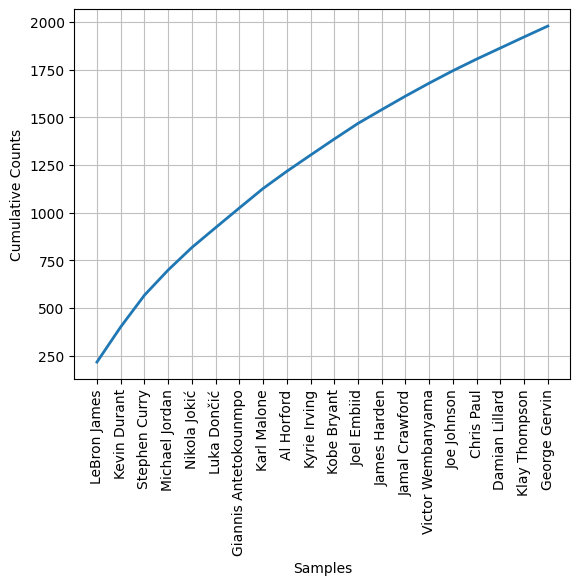

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [7]:
new_quote = nltk.Text([person for person in processed_persons_list if person != ']' and 
                       person != 'Kia Nurse' and person != 'Dan Issel' and person != 'Jeff Halliburton' and
                       person != 'Rudy LaRusso' and person != 'John Brisker' and person != 'Lenny Wilkens'])

frequency_distribution = FreqDist(new_quote)
most_common_persons = frequency_distribution.most_common(100)
frequency_distribution.plot(20, cumulative=True)

# Summary

As expected, the most mentioned player for this period is **LeBron James** (sorry, but GOAT for me, I'm too young and didn't see Jordan play). Next go KD, Steph, MJ and so on. The only thing I'm surprised about is that Victor Wembanyama is already ranked as high as 16th, and he hasn't even completed his first season in the **NBA**. It became interesting to see where he would be if we explored who is the most mentioned starting from the end of the previous play-off.

In [21]:
# full_df.reset_index(inplace=True)
new_timestap_df = full_df[full_df['date'].str.contains('2023-06-13')]

In [24]:
new_df = full_df[full_df.index <= max(new_timestap_df.index)]

In [25]:
new_df

,level_0,index,id,title,excerpt,date
0,0,0,1297409,"Starting 5, March 7: Wednesday was night of bi...",Last night saw four teams rally from 15+ point...,2024-03-07T14:43:30Z
1,1,1,1309690,Thunder's Bismack Biyombo appears to collapse ...,"Biyombo, who fell as the team went to the side...",2024-03-07T04:57:55Z
2,2,2,1309380,Cavaliers' Evan Mobley to miss at least 1 week...,The 6-foot-11 center suffered the ankle injury...,2024-03-07T01:08:48Z
3,3,3,1309277,NBA Fantasy: Yahoo DFS for Mar. 6,RotoWire breaks down the top Yahoo daily fanta...,2024-03-06T21:08:59Z
4,4,4,1309272,"Hornets introduce Jeff Peterson, new executive...",The 35-year-old replaces longtime executive Mi...,2024-03-06T18:48:58Z
...,...,...,...,...,...,...
1832,1832,32,1154641,5 takeaways: Nuggets drop Heat for 1st NBA cha...,"A closer look at how Denver was built, Jamal M...",2023-06-13T05:58:32Z
1833,1833,33,1154572,Numbers Game: 5 key stats from Nuggets' title-...,"Despite free-throw issues in Game 5, Denver cl...",2023-06-13T05:20:03Z
1834,1834,34,1154857,Nuggets celebrate after winning 2023 NBA champ...,The Nuggets created unforgettable scenes and m...,2023-06-13T04:36:20Z
1835,1835,35,1154792,Nuggets edge Heat in Game 5 to secure their 1s...,Miami exacts every last drop of effort before ...,2023-06-13T03:54:41Z


In [26]:
persons_list = []
full_quote = ''
for quote in new_df['excerpt'].to_list():
    print(quote)
    full_quote += ' ' + quote
    words_in_quote = word_tokenize(quote)
    words_in_quote = [word for word in words_in_quote if word.casefold() not in stop_words]
    pos_tags_in_quote = st.tag(words_in_quote)
    quote_tree = nltk.ne_chunk(pos_tags_in_quote)
    persons = list(" ".join(i[0] for i in t) for t in quote_tree if hasattr(t, "label") and t.label() == "PERSON")
    print(persons)
    if len(persons) > 1:
        for person in persons:
            persons_list.append(person if person != list() else '')
    else:
        persons_list.append(persons[0] if persons != list() else '')

processed_persons_list = processPersons(persons_list)

Last night saw four teams rally from 15+ points down to win, while the Warriors gave the Bucks their first loss since All-Star.
['Warriors', 'Bucks']
Biyombo, who fell as the team went to the sideline in a timeout, was helped off and headed for the locker room.
[]
The 6-foot-11 center suffered the ankle injury during the 3rd quarter of Tuesday's game against the Celtics.
[]
RotoWire breaks down the top Yahoo daily fantasy players at each position for Wednesday's 8-game NBA slate.
[]
The 35-year-old replaces longtime executive Mitch Kupchak, who stepped down to take an advisory role.
['Mitch Kupchak']
The former standout guard for the Boston Celtics was last in the NBA during the 2021-22 season.
[]
Victor Wembanyama continued his assault on the NBA and was named NBA Rookie of the Month for February.
['Victor']
B/R's Jonathan Wasserman has a full 2-round Mock Draft as the college postseason gets underway
['Jonathan Wasserman']
Cleveland became the first team to beat Boston in over a mont

['Heat']
Thrust into a bigger role every season amid roster changes, Maxey continues to exceed expectations in Philadelphia.
['Maxey']
RotoWire breaks down the best players to start at each position heading into Week 19 of the fantasy basketball season.
[]
Boston maintains its lead at No. 1 while Oklahoma City, Denver and Milwaukee are among the teams climbing this week.
['Denver Milwaukee']
Nikola Jokic makes some more history, Victor Wembanyama delivers a monster highlight and more from Sunday's slate.
['Nikola', 'Victor Wembanyama']
The Clippers' new uniforms, logo and court will pay homage to the team's history as it prepares to open the Intuit Dome in 2024-25.
['Clippers']
Miami's Thomas Bryant and New Orleans' Jose Alvarado receive multi-game suspensions for leaving the bench during the altercation and fighting.
['Thomas Bryant New Orleans', 'Jose Alvarado']
Atlanta's All-Star point guard will have surgery after suffering a tear of the radial collateral ligament (RCL) in the fift

[]
RotoWire breaks down the top players to consider on the waiver wire heading into Week 18 of the 2023-24 NBA season.
[]
Our writers predict whether the East or West will win the All-Star Game and who will earn MVP honors (8 ET, TNT).
[]
Our writers make their picks for each of the competitions during State Farm All-Star Saturday Night.
['Farm']
Our writers reveal their winning picks for the 2024 Panini Rising Stars.
['Panini Rising Stars']
All-Star Weekend 2024 is upon us - get ready for all the action with the Starting 5!
[]
An abundance of top candidates, including Luka Doncic and Shai Gilgeous-Alexander, will vie over the closing weeks. 
['Luka Doncic Shai']
An 8-time All-Star, Dave DeBusschere was a defensive stopper and the heart soul of the Knicks teams that won 2 NBA titles in the early 1970s.
['Dave']
From the NBA court to the pilot's seat, Coach Rick Carlisle reaches new heights.
['Coach Rick Carlisle']
Thompson thrives as a backup after making 727 consecutive regular-season

[]
Who will win Super Bowl LVIII? Kansas City Chiefs or San Francisco 49ers? NBA.com spoke with 8 players about their picks.
['Super Bowl', 'Kansas City Chiefs San Francisco']
Joel Embiid's injury has opened the door for a new face to join a Top 5 chase that is suddenly more fluid.
['Joel', 'Embiid']
Thursday included a trade deadline, Kobe's statue unveiling, All-Star Saturday participants announced, Steph's 11 3s and more. 
['Kobe', 'Steph']
The camp will bring together 40 top high school-aged prospects from 22 countries and territories.
[]
Highsmith, who was not injured, was going home after Miami's game against Orlando on Tuesday night when the accident happened.
['Miami', 'Orlando']
Take a closer look at all the action with every update from a busy NBA trade deadline.
[]
Gordon Hayward, an All-Star in 2016-17 with the Jazz, is headed back to the West to play for the Thunder.
['Gordon Hayward', 'Thunder']
The veteran big man is headed to Sacramento, where he is expected to be waive

['Cureton']
The French superstar adds to his growing list of accolades with Rookie of the Month honors & a Rising Stars roster spot. 
['Rookie Month']
The Milwaukee staff gets the All-Star nod because Joe Mazzulla of East-leading Boston is ineligible after coaching in the game last year.
['Joe Mazzulla']
The 2-time All-Star is expected to have surgery on his right foot next week, and he will be out 4-6 months.
[]
With this milestone, Westbrook joins LeBron James as the only other player to amass 25,000 points, 9,000 assists and 8,000 rebounds.
[]
The league will partner with Special Olympics of Indiana and Boys & Girls Clubs of Indianapolis as part of the 2024 NBA All-Star Game.
['Girls Clubs Indianapolis']
RotoWire breaks down the top players to consider on the waiver wire heading into Week 16 of the 2023-24 NBA season.
[]
Virginia Union and Winston-Salem State will each receive $100,000 as HBCU Classic's partnership with AT&T enters 3rd consecutive year.
[]
Nikola Jokic and Shai Gilg

['Cavs']
RotoWire breaks down the top 6 players to consider on the waiver wire heading into Week 15 of the 2023-24 NBA season.
[]
The Bucks star is being recognized for his local efforts during the NBA's Season of Giving.
[]
Lebron earns 20th straight All-Star start, while a trio earns their first All-Star starts in a jam-packed Thursday night
[]
Jayson Tatum climbs, Joel Embiid dominates and Giannis Antetokounmpo earns All-Star captain honors.
['Jayson', 'Tatum', 'Joel Embiid', 'Giannis Antetokounmpo']
LeBron James surpasses Kareem Abdul-Jabbar again, this time for most All-Star selections in NBA history.
['James', 'Kareem Abdul-Jabbar']
NBA Launchpad is a league initiative to source, evaluate and pilot emerging technologies that advance its top basketball and business priorities.
[]
FantasyPros breaks down the top DraftKings and FanDuel daily fantasy players for the Thursday's 7-game slate.
[]
In the 2nd Victor Wembanyama vs. Chet Holmgren showdown, the Spurs rookie proved why he is 

['Alex']
Golden State's game in Utah on Jan. 17 has been postponed after the sudden death of assistant coach Dejan Milojević.
['Golden', 'Utah', 'Dejan Milojević']
Breaking down the effectiveness of the players who turn it on in the clutch at the season's midpoint.
[]
Victor Wembanyama still reigns, but next week's showdown vs. Chet Holmgren could spark a change in our rookie rankings.
['Victor', 'Chet Holmgren']
The Pacers acquire All-Star Pascal Siakam from the Raptors in a trade that also involves the Pelicans.
[]
The Mavs-Lakers matchup will be the 3rd of 5 straight NBA Wednesdays on ABC primetime during January.
[]
Embiid wins MVP duel with Jokic, Suns close on a 32-8 run to shock Kings, and Paul George drops season-high 38 points vs. OKC. 
['Jokic', 'Paul George']
The Minnesota guard talks about the importance of family, the root of his competitiveness and describes his playing style
[]
Denver's plane was delayed after the engines were frozen by cold weather. 
[]
The All-Star gua

['Block Panther', 'Rock']
The Pacers lost Tyrese Haliburton, but still knocked off the NBA-leading Celtics. Plus, a photo history of the NBA in Paris. 
['Tyrese Haliburton', 'Celtics', 'Plus']
The Kings received the NBA Team of the Year Award for their achievements across team business operations.
[]
The two-time All-Star was averaging 25.1 points per game this season since returning from a league-mandated suspension.
[]
The Knicks guard and Rockets center take home the honors for Week 11.
[]
O NBA CrunchTime apresenta todos os destaques dos melhores jogos da liga em um só programa. 
[]
RotoWire breaks down the best players to start at each position heading into Week 12 of the fantasy basketball season.
[]
FantasyPros breaks down the top DraftKings and FanDuel daily fantasy players for the NBA's 6-game slate on Monday.
[]
Oklahoma City moves past Boston for the top spot as the West continues to hold an edge over the East this season.
[]
The NBA App original series, which premieres on J

['Heat', 'Jamie Jaquez Jr.']
The NBA on Wednesday approved Mark Cuban’s sale of a controlling interest in the Mavericks to the Adelson and Dumont families
['Mark Cuban', 'Mavericks Adelson Dumont']
The former Democratic U.S. senator from Wisconsin bought the Bucks in 1985 and owned them until 2014.
['Wisconsin']
RotoWire breaks down the top Yahoo daily fantasy players at each position for Wednesday's 6-game NBA slate.
[]
Denver's high-flying big man is out indefinitely after suffering his injuries on Christmas Day.
['Christmas']
The Grizzlies keep rolling with Ja Morant in the mix and a big anniversary is here for Luka Doncic
['Ja Morant', 'Luka Doncic']
Oklahoma City's star big man and Miami's standout wing continue to shine in the latest rookie rankings.
['Miami']
The NBA Board of Governors has approved the sale from Mark Cuban to the Adelson and Dumont families. 
['Board Governors', 'Mark Cuban Adelson Dumont']
Detroit's 27th consecutive defeat sets a new NBA single-season mark.
[]


['James Naismith']
Embiid drops a season-high 51 points against Minnesota, the Clippers stays undefeated in December and the Celtics roll.
['Minnesota', 'Clippers']
The offseason blockbuster trade of Paul George for Shai Gilgeous-Alexander in 2019 is still being felt by both teams.
['Paul George Shai']
Check out the all-time leaders for points and single-game scoring on Christmas Day.
['Christmas']
Take a look back at the results from every Christmas Day game in NBA history, starting with those played in the 1946-47 season.
[]
Joel Embiid's run is NBA's longest such streak since Kareem Abdul-Jabbar did it in 16 straight games during the 1971-72 season.
['Joel', 'Embiid', 'Kareem']
The arena is home to more than just Magic basketball. Last year it drew 1.3 million guests to 233 events.
['Magic']
The Nets say Simmons has shown consistent strength improvement in his back over the past 2 weeks.
['Simmons']
RotoWire breaks down the top Yahoo daily fantasy players at each position for Wednes

[]
Doncic became the youngest player to reach 1,000 3-pointers in NBA history. Also, Bradley Beal is expected to return on Tuesday.
['Doncic', 'Bradley Beal']
From the rise of the Magic to the surge of LeBron James, these things stand out at the season's quarter mark.
['Magic']
The NBA's Christmas Day brand campaign 'The Gift of Game' celebrates the timeless tradition and captures the magic of holiday hoops.
['Christmas']
RotoWire discusses the best players to start at each position heading into Week 8 of the fantasy basketball season.
[]
The NBA's leading offensive rebounder will be evaluated to return in 8-10 weeks.
[]
FantasyPros breaks down the top DraftKings and FanDuel daily fantasy players for the NBA's 13-game slate on Monday. 
[]
The inaugural All-Tournament Team, selected by a panel of media members, is based off performances throughout the Tournament. 
[]
Minnesota stays hot to rise to the top while the Lakers and Pacers climb into the Top 10.
[]
Before a 13-game night, catc

['Giannis', 'Kia MVP']
Kevin Durant is 17 points away from passing Moses Malone to reach the Top 10 in scoring. He could get there tonight.
['Kevin', 'Moses Malone']
Group Play games in the In-Season Tournament across ESPN and TNT averaged 1.5 million viewers.
['Group']
FantasyPros breaks down the top DraftKings and FanDuel daily fantasy players for Thursday's nine-game NBA slate.
[]
Breaking down the players who have seen a rise or fall in shooting accuracy to begin this season.
[]
The OKC big man went from a season-ending injury to a starring role. Here's how the time off shaped him.
[]
Checking in on the state of the Clippers after the first month with James Harden.
['James Harden']
The reigning Kia MVP, who is averaging 32.0 points and 11.3 rebounds, was ruled out about 30 minutes before tipoff.
['Kia MVP']
The Adelson and Dumont families have entered an agreement with Mark Cuban to purchase the franchise.
['Adelson', 'Mark Cuban']
RotoWire breaks down the top Yahoo daily fantasy p

['Jazz', 'James']
Mitchell, averaging 29.2 points this season, has been bothered by his right hamstring since the first week, sitting out three total games.
[]
As losing streak hits 8 games, young Spurs embrace learning experiences and the road ahead.
[]
The new In-Season Tournament is underway and the race for its MVP award is on.
[]
The rook gets an early iconic moment against the Warriors, as he and SGA combine for 76 to win in OT. Giannis, Wemby make history. KAT comes up clutch.
['Giannis', 'Wemby']
Harden’s clutch 4-point play in closing seconds highlights In-Season Tournament night 4.
[]
The Memphis guard suffered the injury in Tuesday's 134-107 loss to the Lakers in Los Angeles. 
[]
RotoWire breaks down the top six players to target on the waiver wire heading into Week 5.
[]
The Suns' guard last played on Nov. 12 and has been dealing with a back injury all season.
[]
Breaking down the records of teams with key victories against the 14 teams currently with winning records.
[]
Al

[]
FantasyPros considers the best player values for DraftKings and FanDuel NBA DFS for Thursday's two-game slate.
[]
Examining how several players who switched teams last summer are faring so far.
[]
Jokic goes off (again) as Nuggets halt. Dame drops 18 in 4th. Knicks, Nets get wins & the Mexico City game awaits.
['Dame', 'Knicks']
Victor Wembanyama is held to 14 points in a difficult Madison Square Garden debut as the Spurs lose, 126-105.
['Victor', 'Madison Square Garden']
Atlanta (4-3) and Orlando (4-3) will tip off the NBA's 32nd game in Mexico City.
['Mexico City']
Denver's star guard suffered the injury on Nov. 4 and the team will reportedly take a cautious approach in his recovery.
[]
Kessler, a first-team all-rookie selection last season, was injured during a season-opening loss to the Sacramento Kings on Oct. 25.
['Kessler']
Williamson leads the Pelicans in scoring, averaging 21.8 points through the team's first seven games of the season.
['Williamson']
The former All-Star sco

['Playhouse Square']
An ode to the Miami Heat’s franchise, the 2023-24 City Edition uniform puts “HEAT Culture” at the front and center of the team’s on-court identity.
['Miami Heat']
The Boston Celtics 2023-24 City Edition uniform is a nod to the origin of the game and the continued commitment to the craft.
[]
Pride and resiliency in Orlando continue to show the rise to conquer the basketball world through this year’s City Edition uniform.
['Orlando']
The Toronto Raptors 2023-24 City Edition uniform is an ode to Toronto’s vibrancy and passion for the game of basketball
[]
The Brooklyn Nets City Edition Jersey collaborates with renowned Brooklyn-based artist and Nets fan, KAWS.
[]
The 2023-24 Bulls' City Edition uniform pays homage to the old Chicago Stadium.
[]
The Detroit Pistons City Edition uniform takes inspiration from the team’s iconic championship history and pays tribute to the original fan-made “Detroit Bad Boys” logo.
['Detroit Bad']
The Philadelphia 76ers are proud to celeb

[]
The participation policy requires teams to demonstrate an approved reason for a star to miss national TV games.
[]
Viewership of the season-opening doubleheader featuring Celtics-Knicks and Mavericks-Spurs was up 80% from last year.

[]
NBA CrunchTime is back for another season, bringing you all the highlights from around the league in 1 place. 
[]
Phoenix will be without both of its star guards in a matchup against the Lakers in Los Angeles.
[]
Ayo Dosunmu spent his offseason working to bridge the gap of access to opportunity with more than 1,500 Chicago youth.
['Ayo', 'Dosunmu']
Milwaukee's new star duo should find plenty of creative ways to score. How will teams defend them? 
['Milwaukee']
Kevin Durant has changed teams twice since he last faced off against LeBron James in the regular season.
['Kevin', 'Durant']
Indiana coach Rick Carlisle is staying put after agreeing to an extension with the team.
['Rick Carlisle']
Catch up on everything that's happening in the NBA with the Sta

['Joel', 'Embiid Chet Holmgren']
Commissioner Silver says the league is looking at possibly returning to the traditional East vs. West All-Star Game format.
[]
The Sixers' star had hoped to try to play in Philadelphia's final preseason game on Friday.
[]
20-year NBA veteran Jamal Crawford answers 20+ questions to preview the 2023-24 season.
['Jamal Crawford']
Zion Williamson, Cade Cunningham and Chet Holmgren lead the list of impact players returning from injuries.
['Zion', 'Cade Cunningham Chet Holmgren']
The 1st quadruple-double. Boston 3 party. Early impressions of CP3/Poole. 5 players on All-Star cusp. WNBA Finals Game 4.
['Boston']
Devin Booker, Kevin Durant and Bradley Beal give Phoenix a star-rich lineup and options galore in the West.
['Devin', 'Kevin Durant Bradley Beal', 'Phoenix']
Peloton members subscribed to NBA League Pass will have access to live and on-demand NBA games directly on Peloton Bikes, Treads and Row
[]
The Thunder get 2 future second-round picks in trade with

[]
Breaking down the expectations for Minnesota before the 2023-24 season tips off.
[]
Breaking down the expectations for Memphis before the 2023-24 season tips off.
[]
Breaking down the expectations for Atlanta before the 2023-24 season tips off.
[]
Breaking down the expectations for Chicago before the 2023-24 season tips off.
[]
Breaking down the expectations for Cleveland before the 2023-24 season tips off.
[]
Breaking down the expectations for Toronto before the 2023-24 season tips off.
[]
Breaking down the expectations for Indiana before the 2023-24 season tips off.
[]
Breaking down the expectations for Houston before the 2023-24 season tips off.
[]
Breaking down the expectations for New York before the 2023-24 season tips off.
[]
Breaking down the expectations for Detroit before the 2023-24 season tips off.
[]
Breaking down the expectations for Milwaukee before the 2023-24 season tips off.
[]
Breaking down the expectations for Miami before the 2023-24 season tips off.
[]
Breaking

[]
The former Spurs draft pick was suspended by the league for conduct detrimental to the league.
[]
Cleveland's coach is excited about the team's new additions, having Year 2 with Donovan Mitchell and more.
['Donovan Mitchell']
The Suns add coach Frank Vogel and Bradley Beal in hopes of finding the final pieces of a championship-level squad.
['Frank Vogel Bradley Beal']
Lakers GM Rob Pelinka believes he has a roster in place that will help LeBron James get more rest this season.
['Rob Pelinka']
A day after being traded, Lillard takes time to thank everyone who made his 11 seasons in Portland memorable.
['Lillard']
The Timberwolves are banking on Rudy Gobert and Karl-Anthony Towns meshing better together in Year 2.
['Rudy Gobert']
RotoWire breaks down the biggest fantasy basketball risers and fallers from players on new teams for 2023-24.
[]
Perlmutter will oversee the league’s business and competition operations.
[]
New Orleans' coach believes his team has what it takes to battle thro

['Jamal Crawford', 'Kobe Bryant', 'Allen Iverson']
Take a look back at every induction class for the Naismith Memorial Basketball Hall of Fame.
['Naismith Memorial Basketball Hall Fame']
Adding Marcus Smart to Memphis' core may prove to be a vital offseason move for more than 1 reason.
['Marcus Smart Memphis']
The 2-time Kia MVP has added a new partner to his workout regime, announcing he's heading to Houston to train with Hakeem Olajuwon.
['Kia MVP', 'Houston', 'Hakeem Olajuwon']
Standouts in the NBA G League, Queen and Williams will compete for roster spots during training camp.
['Standouts', 'Queen Williams']
Big man Tristan Thompson is headed back to Cleveland for his 2nd career stint with the team.
['Tristan Thompson']
RotoWire breaks down the top rookies heading into the 2023-24 fantasy basketball season.
[]
After a flurry of moves this offseason, Houston faces a major test of piecing it all together in 2023-24.
['Houston']
The Houston guard was arrested Monday after allegedly at

[]
A career 40.3% shooter from 3-point range, Mykhailiuk joins his 7th team since entering the NBA in 2018.
['Mykhailiuk']
RotoWire breaks down the seven tiers of forwards to draft in the 2023-2024 fantasy basketball season.
[]
Take a look at the players who stood out the most during FIBA World Cup play on Aug. 31.
[]
Kristaps Porzingis remains a matchup nightmare on both ends, but is he the missing piece to Boston's championship puzzle?
['Kristaps', 'Porzingis', 'Boston']
The NBA announced that referee Eric Lewis has retired effective immediately. 
['Eric Lewis']
20-year NBA veteran Jamal Crawford answers your questions about the FIBA World Cup, the evolution of the NBA and more. 
['Jamal Crawford']
Anthony Edwards shines as Team USA dominates Jordan to finish 3-0 in the first round of Group Play in the FIBA World Cup.
['Anthony', 'Team USA', 'Group Play']
Take a look at the players who stood out the most during FIBA World Cup play on Aug. 30.
[]
The Oct. 10 matchup will pit Mavs All-

['Team USA']
The LA Clippers head coach joins an all-time great coaching staff set to represent Team USA in the FIBA World Cup.
['Team USA']
Burke and Rivers will join Mike Breen on ESPN and ABC’s top NBA broadcast crew.
['Burke', 'Mike Breen']
The competition will be fierce, but a few teams have what it takes to break back into the postseason. 
[]
Jalen Brunson scores 22 points and Jaren Jackson Jr. adds 14 as the U.S. takes control in the 4th quarter for the 98-88 win in Malaga.
['Jalen', 'Jaren Jackson', 'Malaga']
The new jersey represents Minnesota's rich culture of fun with family and friends on the water. 
['Minnesota']
Here's everything you need to know as USA faces Spain in an exhibition match on Sunday. 
[]
Selflessness, disbelief and a few tears are shared as 12 new members enter the Naismith Memorial Basketball Hall of Fame.
['Naismith Memorial Basketball Hall Fame']
Europeans Dirk Nowitzki, Tony Parker and Pau Gasol starred in the NBA, earning enshrinement in the Hall of Fa

[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-team breakdown of the 32 countries in the competition.
[]
Get ready for the FIBA Basketball World Cup with a team-by-te

['Summer League Final']
The Cleveland Cavaliers and the Houston Rockets are set to face off in the Summer League Championship Monday night.
['Summer League']
Veteran guard Cameron Payne has been dealt to San Antonio, while Phoenix also reportedly picks up Bol Bol in a separate transaction.
['Cameron Payne', 'San Antonio', 'Phoenix', 'Bol Bol']
With the closeout games beginning at the NBA 2K24 Summer League, Denver's Julian Strawther and Phoenix's Toumani Camara finish strong.
['Denver', 'Julian Strawther Phoenix', 'Toumani Camara']
No. 52 overall pick Toumani Camara drops a game-high 20 points, along with 10 rebounds, one assist and two blocks in the Suns' victory.
['Toumani Camara']
No. 29 overall pick Julian Strawther complements 25 points with nine rebounds, two assists, one steal and one block in Denver's win.
['Julian Strawther', 'Denver']
Days after announcing he'll be returning for a 21st season, LeBron James reveals he's going back to his original number.
[]
Jordan Walsh racks 

['Sam', 'Merrill']
Opening day of the 2023 NBA 2K24 Las Vegas Summer League on ESPN is the most-watched on record.
[]
General manager Joe Cronin reveals he hasn't spoken with the All-Star guard since he asked to be traded from Portland. 
['Joe Cronin']
The No. 1 pick played a combined 54 minutes in 2 games with the Spurs in Las Vegas. 
['Spurs Las Vegas']
The 38-year-old point guard says he has no intention of stepping away from the game any time soon. 
[]
From major signings to trades, here are some key storylines to follow after the 1st 10 days of free agency.
[]
The annual summer gathering continues to reach new heights for teams, players and fans.
[]
No. 1 overall pick Victor Wembanyama drops 27 points and 12 rebounds in a loss while Jabari Smith Jr. contributes 38 points on Sunday.
['Victor Wembanyama', 'Jabari Smith']
Dereon Seabron's 10-point 4th quarter closed out Day 3 with a win over the Warriors.
['Dereon', 'Seabron']
The Hawks strong 2nd quarter and offensive rebounding hel

[]
Bol played in 70 games last season with Orlando.
['Bol', 'Orlando']
Murray shot 8-for-17 from the field and hit an impressive 10-for-11 from the foul line.
['Murray']
Chet Holmgren's long-awaited return headlined a strong collective showing by members of the 2022 Draft class.
['Chet']
The former No. 2 overall pick made his presence felt on both ends in his Summer League return.
['Summer League']
Miami rides 58-40 first half to an easy win over Los Angeles in Summer League opener. 
[]
Julian Champagnie drops 30 points against No. 2 overall pick Brandon Miller and the Charlotte Hornets.
['Champagnie', 'Brandon Miller Charlotte Hornets']
Kenneth Lofton Jr. pours in 21 points and 13 rebounds in Memphis' narrow victory over Philadelphia.
['Kenneth', 'Lofton Jr.', 'Memphis']
Sacramento has revealed its Icon and Association Edition uniforms for next season.
['Icon Association']
Bridges will be eligible to become an unrestricted free agent next summer after signing a $7.9 million qualifying

[]
After 6 seasons with Atlanta, John Collins is headed to Utah in exchange for Rudy Gay and a future second-round pick.
['Atlanta', 'John Collins', 'Utah', 'Rudy Gay']
Will Chris Paul fit with the Warriors? What about Bradley Beal in Phoenix? Here are the key stats on players and teams involved. 
['Chris', 'Paul', 'Bradley Beal Phoenix']
No. 1 pick in 2023 Draft says he will not play in FIBA World Cup, but was not pressured by Spurs at all in his choice.
[]
The backup big man, who went undrafted in 2019, has inked a new contract to stay in Minnesota.
[]
Bilal Coulibaly and Rayan Rupert are two examples of the basketball renaissance in France that goes beyond just Victor Wembanyama.
['Bilal', 'Coulibaly Rayan Rupert', 'Victor Wembanyama']
Victor Wembanyama's 1st 24 hours in San Antonio includes a rally at the iconic River Walk and dinner with Spurs legends.
['Victor', 'San Antonio']
The San Antonio Spurs have officially introduced their No. 1 pick Victor Wembanyama to the city and thei

['Jamal Crawford', 'Denver']
Despite its lack of hardware, Denver boasts a rich hoops history including such legendary players as David Thompson, Dan Issel and Alex English. 
['Denver', 'David Thompson', 'Dan Issel Alex English']
Williams will assume leadership of a promising young core featuring Cade Cunningham, Jaden Ivey and Jalen Duren.
['Williams', 'Cade Cunningham', 'Jaden Ivey Jalen Duren']
Rajakovic, 44, replaces Nick Nurse, who was fired after Toronto went 41-41 and lost in the opening round of the Play-In Tournament.
['Nick Nurse', 'Toronto']
NBA Draft 2023 presented by State Farm will be held on June 22 at 8 ET (ABC/ESPN).
[]
NBA playoff games account for 9 of the 10 most-watched programs across all of television since the beginning of May.

[]
Attention turns to New York City, where on June 22, the San Antonio Spurs will be on the clock with the No. 1 pick.
['San Antonio']
Fans of the Finals MVP in Sombor, Serbia also were elated by tennis star Novak Djokovic's French Open 

Jalen Brunson
Jalen Brunson
Jalen Rose
-------------------------------------------------------------------

-------------------------------------------------------------------
James Harden
LeBron James
James Harden
-------------------------------------------------------------------
Chet Holmgren
Chet Walker
Chet Holmgren
-------------------------------------------------------------------
Max
Max
-------------------------------------------------------------------
Strus
Strus
-------------------------------------------------------------------
Chris Paul
Chris Paul
Dan Issel
-------------------------------------------------------------------
Max Strus
Max Strus
Nick Van Exel
-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Heat
------------------------------

Michael Cooper Walter Davis
Ray Allen
Michael Jordan
Wayne Cooper
Walter Davis
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Farm
Farm
-------------------------------------------------------------------
Panini Rising Stars
]
Lisa Risinger
Los Angeles Stars
-------------------------------------------------------------------

-------------------------------------------------------------------
Luka Doncic Shai
Luka Dončić
Shai Gilgeous-Alexander
-------------------------------------------------------------------
Dave
Dave
-------------------------------------------------------------------
Coach Rick Carlisle
]
Blackie Towery
Rick Barry
-------------------------------------------------------------------
Thompson
Thompson
--------------------------------------------

Orb Bowling
Michael Jordan
-------------------------------------------------------------------
Kansas City Chiefs San Francisco
]
Francisco García
Kansas City Kings
-------------------------------------------------------------------
Joel
Joel
-------------------------------------------------------------------
Embiid
Embiid
-------------------------------------------------------------------
Kobe
Kobe
-------------------------------------------------------------------
Steph
Steph
-------------------------------------------------------------------

-------------------------------------------------------------------
Miami
-------------------------------------------------------------------
Orlando
-------------------------------------------------------------------

-------------------------------------------------------------------
Gordon Hayward
Gordon Hayward
Eric Gordon
-------------------------------------------------------------------
Thunder
-------------------------------------------

Kia MVP
]
Kia Nurse
-------------------------------------------------------------------

-------------------------------------------------------------------
Cureton
Cureton
-------------------------------------------------------------------
Rookie Month
]
2023-24
-------------------------------------------------------------------
Joe Mazzulla
Joe Mazzulla
Larry Bird
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Girls Clubs Indianapolis
]
Indianapolis Jets
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Nikola
Nikola Jokic
-------------------------------------------------------------------
Jokic Shai
Nikola Jokić
Shai Gilgeous-Alexander
--------------------------------------


-------------------------------------------------------------------
Dejan Milojevic
Dejan Bodiroga
Dejan Milojevic
-------------------------------------------------------------------

-------------------------------------------------------------------
Wizards
-------------------------------------------------------------------
Wes Unseld
Wes Unseld
Jerry West
-------------------------------------------------------------------
Antonio
-------------------------------------------------------------------
Golden
-------------------------------------------------------------------
Utah
-------------------------------------------------------------------
Salt Lake City
Salt
-------------------------------------------------------------------

-------------------------------------------------------------------
Phoenix
-------------------------------------------------------------------
Knicks
-------------------------------------------------------------------
See
See
------------------------------


-------------------------------------------------------------------
Lillard
Lillard
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Clippers
-------------------------------------------------------------------
Ja Morant Marcus Smart
Ja Morant
Joe Johnson
Marcus Smart
-------------------------------------------------------------------

-------------------------------------------------------------------
San Antonio
-------------------------------------------------------------------
Gallinari Muscala
Danilo Gallinari
Mike Muscala
-------------------------------------------------------------------

-------------------------------------------------------------------
Charlotte
-------------------------------------------------------------------

-------------------------------------------------------------------

------------------------


-------------------------------------------------------------------
Rookie Year
2023-24
Wayne Yearwood International Stats
-------------------------------------------------------------------
Bulls
-------------------------------------------------------------------

-------------------------------------------------------------------
Jonathan Wasserman
JJ Redick
]
-------------------------------------------------------------------
Oklahoma City Indiana
-------------------------------------------------------------------
Mac
Mac
-------------------------------------------------------------------
Shaquille
Shaquille
-------------------------------------------------------------------
Slam Dunk
Rik Smits
Larry Nance
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Clippers Thunder
---------------------------------------------------------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

---------------------------------

Lillard
Lillard
-------------------------------------------------------------------
Lillard
Lillard
-------------------------------------------------------------------
Michael Redd
Michael Jordan
Michael Redd
-------------------------------------------------------------------

-------------------------------------------------------------------
Draymond Green
Draymond Green
Kevin Durant
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Oklahoma City
-------------------------------------------------------------------

-------------------------------------------------------------------
Doncic
Doncic
-------------------------------------------------------------------
Beal Booker
Bradley Beal
Devin Booker
-------------------------------------------------------------------

-----------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
James Harden
LeBron James
James Harden
-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------
Adelson
Adelson
-------------------------------------------------------------------
Mark Cuban
]
Mark Aguirre
-------------------------------------------------------------------

-------------------------------------------------------------------
Brandon Miller Blazers
Terrell Brandon
Reggie Miller
-------------------------------------------------------------------
Scoot Henderson
Kevin Porter Jr.
Gerald Henderson
-------------------------------------------------------------------
David Robinson
David Robinson
--------------

Wolves
Wolves
-------------------------------------------------------------------
Chris Paul
Chris Paul
Dan Issel
-------------------------------------------------------------------
Kia MVP
]
Kia Nurse
-------------------------------------------------------------------
Billy Donovan
Donovan Mitchell
Billy Cunningham
-------------------------------------------------------------------
Draymond Green
Draymond Green
Kevin Durant
-------------------------------------------------------------------
Oubre
Oubre
-------------------------------------------------------------------

-------------------------------------------------------------------
Bucks
-------------------------------------------------------------------
Tyrese Haliburton
Tyrese Maxey
Tyrese Haliburton
-------------------------------------------------------------------
Draft
Draft
-------------------------------------------------------------------
Victor Wembanyama San Antonio
Victor Wembanyama
-----------------------------------

Clippers
-------------------------------------------------------------------
Embiid
Embiid
-------------------------------------------------------------------
Rick Carlisle
Blackie Towery
Rick Barry
-------------------------------------------------------------------
Williams
Williams
-------------------------------------------------------------------
Jrue
Jrue
-------------------------------------------------------------------

-------------------------------------------------------------------
Chase Center
Chase Budinger
]
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Waiver Wire
]
-------------------------------------------------------------------
Golden State Boston
-------------------------------------------------------------------
James
James
-------------------------------------------------------------------
Miami
--------

Kareem
Kareem
-------------------------------------------------------------------

-------------------------------------------------------------------
Halloween
Halloween
-------------------------------------------------------------------

-------------------------------------------------------------------
Halloween
Halloween
-------------------------------------------------------------------
Jamal Crawford
Jamal Crawford
-------------------------------------------------------------------
Curry
Curry
-------------------------------------------------------------------
Dejounte
Dejounte
-------------------------------------------------------------------
Luka Joker
Nikola Jokić
Luka Dončić
-------------------------------------------------------------------
Clippers
-------------------------------------------------------------------
Damian Lillard
Damian Lillard
-------------------------------------------------------------------
Heat
--------------------------------------------------------

Monte Morris
Marcus Morris
Tree Rollins
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Brendan Malone
Karl Malone
Brendan Haywood
-------------------------------------------------------------------
Nuggets
-------------------------------------------------------------------
Michael Malone
Michael Jordan
Karl Malone
-------------------------------------------------------------------
Nikola Jokic
Nikola Jokić
-------------------------------------------------------------------

-------------------------------------------------------------------
Kia NBA
John Brisker
Kia Nurse
-------------------------------------------------------------------
Anthony Edwards Tyrese Haliburton
Karl Malone
Tyrese Maxey
Tyrese Haliburton
James Edwards
-------------------------------------------------------------------
Atlanta
----------------------------


-------------------------------------------------------------------
Dischinger
Dischinger
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Zion Williamson
Corliss Williamson
Zion Williamson
-------------------------------------------------------------------
Nikola Jokic Nuggets
Nikola Jokić
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Shane Battier
Shane Battier
-------------------------------------------------------------------

-------------------------------------------------------------------

----------------------------------------

Tim Duncan
Rafael Addison
-------------------------------------------------------------------
Porter
Porter
-------------------------------------------------------------------
Media
Media
-------------------------------------------------------------------
Bronny
Bronny
-------------------------------------------------------------------

-------------------------------------------------------------------
Memphis
-------------------------------------------------------------------
Manhattanville Factory District
]
Semi Ojeleye
-------------------------------------------------------------------
Daryl Morey
Daryl Macon
Dale Morey
-------------------------------------------------------------------
Harden
Harden
-------------------------------------------------------------------
Payne
Payne
-------------------------------------------------------------------
Golden
-------------------------------------------------------------------
Miami
--------------------------------------------------------

Black Educator Development
]
Kobe Bryant
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Jalen
Jalen
-------------------------------------------------------------------
Brunson
Brunson
-------------------------------------------------------------------
Ohio
Ohio
-------------------------------------------------------------------
Highway Patrol
]
Lee Patrone
-------------------------------------------------------------------
Altman
Altman
-------------------------------------------------------------------
Paolo
Paolo
-------------------------------------------------------------------
Orlando
-------------------------------------------------------------------
Classic Edition
]
Al Jefferson
-------------------------------------------------------------------

-------------------------------------------------------------------
Charlott

Leonard Paul George
George Gervin
Lenny Wilkens
Dan Issel
-------------------------------------------------------------------
Serbia
Serbia
-------------------------------------------------------------------
Lithuania
Lithuania
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Team
Team
-------------------------------------------------------------------

-------------------------------------------------------------------
Shai
Shai
-------------------------------------------------------------------
Paris Olympics
]
Robert Parish
-------------------------------------------------------------------
Lithuania FIBA

Jonas Valančiūnas
-------------------------------------------------------------------
Golden State
-------------------------------------------------------------------
Paris Olympics
]
Robert Parish
----------------------------

Porzingis
Porzingis
-------------------------------------------------------------------

-------------------------------------------------------------------
Group Play NBA
]
Paul George
John Brisker
-------------------------------------------------------------------

-------------------------------------------------------------------
Group Play
]
Paul George
-------------------------------------------------------------------
Team USA
]
Mark Wade
-------------------------------------------------------------------
Team USA
]
Mark Wade
-------------------------------------------------------------------
Burke
Burke
-------------------------------------------------------------------
Mike Breen
Michael Jordan
Breena Caldwell
-------------------------------------------------------------------

-------------------------------------------------------------------
Jalen
Jalen
-------------------------------------------------------------------
Jaren Jackson
Jaren Jackson Jr.
Jamaal Wilkes
--------


-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

---------------------------------

Julian Strawther
Julian Strawther
Julian Hammond
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------

-------------------------------------------------------------------
Vincent
Vincent
-------------------------------------------------------------------
Phoenix Mercury
Mercury
-------------------------------------------------------------------
Javon
Javon
-------------------------------------------------------------------
Bulls
-------------------------------------------------------------------
Milwaukee
-------------------------------------------------------------------
Joe Wieskamp
Joe Wieskamp
Larry Bird
-------------------------------------------------------------------
Gradey Dick Markquis Nowell
Jaylen Nowell
Gradey Dick
Dick Barnett
Markquis Nowell
-------------------------------------------------------------------
Golden State
--------------------------------------------------------------

Merrill
Merrill
-------------------------------------------------------------------

-------------------------------------------------------------------
Joe Cronin
Katie Cronin
Larry Bird
-------------------------------------------------------------------
Spurs Las Vegas
LaSalle Thompson
Las Vegas Aces
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Victor Wembanyama
Victor Wembanyama
-------------------------------------------------------------------
Jabari Smith
Randy Smith
Malik Rose
-------------------------------------------------------------------
Dereon
Dereon
-------------------------------------------------------------------
Seabron
Seabron
-------------------------------------------------------------------
Nuggets
---------------------------------------

Jamal Crawford
Jamal Crawford
-------------------------------------------------------------------
Giannis Antetokounmpo
Giannis Antetokounmpo
-------------------------------------------------------------------
Anthony Parker
Tony Parker
Karl Malone
-------------------------------------------------------------------
John Hammond
Tom Hammonds
John Havlicek
-------------------------------------------------------------------

-------------------------------------------------------------------
Bol
Bol
-------------------------------------------------------------------
Orlando
-------------------------------------------------------------------
Murray
Murray
-------------------------------------------------------------------
Chet
Chet
-------------------------------------------------------------------
Summer League
Harold Pressley
Rudy LaRusso
-------------------------------------------------------------------

-------------------------------------------------------------------
Champagnie
Cha

Doug Collins
John Havlicek
-------------------------------------------------------------------
Utah
-------------------------------------------------------------------
Rudy Gay
Rudy Gay
Elgin Baylor
-------------------------------------------------------------------
Chris
Chris
-------------------------------------------------------------------
Paul
Paul
-------------------------------------------------------------------
Bradley Beal Phoenix
Bradley Beal
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------------------------------------------
Bilal
Bilal
-------------------------------------------------------------------
Coulibaly Rayan Rupert
Rayan Rupert
Bilal Coulibaly
-------------------------------------------------------------------
Victor Wembanyama
Victor Wembanyama
-------------------------------------------------------------------
Victor
Victor Wembanyama
------

Denver
-------------------------------------------------------------------
Denver
-------------------------------------------------------------------
David Thompson
David Robinson
Klay Thompson
-------------------------------------------------------------------
Dan Issel Alex English
Alex English
Dan Issel
-------------------------------------------------------------------
Williams
Williams
-------------------------------------------------------------------
Cade Cunningham
Cade Cunningham
Billy Cunningham
-------------------------------------------------------------------
Jaden Ivey Jalen Duren
Jaden McDaniels
Jalen Rose
Jalen Duren
Jaden Ivey
-------------------------------------------------------------------
Nick Nurse
Nick Van Exel
Kia Nurse
-------------------------------------------------------------------
Toronto
-------------------------------------------------------------------

-------------------------------------------------------------------

-------------------------------

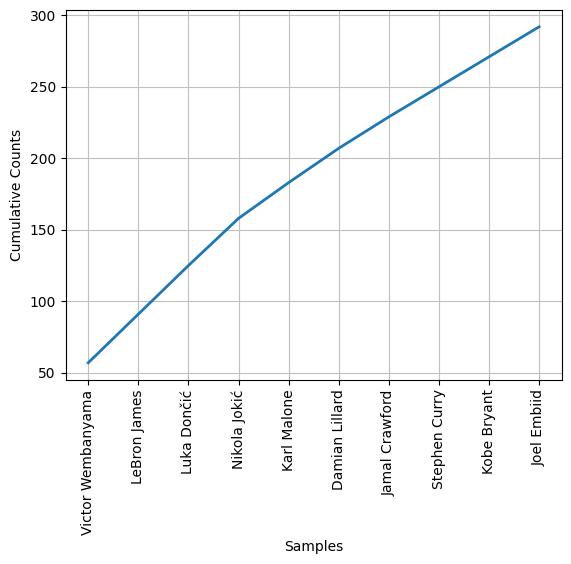

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [27]:
new_quote = nltk.Text([person for person in processed_persons_list if person != ']' and 
                       person != 'Kia Nurse' and person != 'Dan Issel' and person != 'Jeff Halliburton' and
                       person != 'Rudy LaRusso' and person != 'John Brisker' and person != 'Lenny Wilkens'])

frequency_distribution = FreqDist(new_quote)
most_common_persons = frequency_distribution.most_common(100)
frequency_distribution.plot(10, cumulative=True)

In [43]:
frq_df = pd.DataFrame(frequency_distribution.most_common(10))
freq_df.columns = ['Player', 'Number of mentions']
freq_df

,Player,Number of mentions
0,Victor Wembanyama,57
1,LeBron James,34
2,Luka Dončić,34
3,Nikola Jokić,33
4,Karl Malone,25
5,Damian Lillard,24
6,Jamal Crawford,22
7,Stephen Curry,21
8,Kobe Bryant,21
9,Joel Embiid,21


And in this period Victor Wembanyama is the most frequently mentioned player, which can't help but impress, especially since he deserves so much attention, at least he's already done **5-by-5**, has a little more than **60% true shooting** since the beginning of the year, and still a lot of different very rare things for a rookie.